## Probabilistic resolver

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import gym
%matplotlib inline
import cv2

def preprocess(image):
    def_h = 84
    def_w = 84
    img = 0.299*image[:,:,0] + 0.587*image[:,:,1] + 0.114*image[:,:,2]
    img = cv2.resize(img, (def_h, def_w))
    img = np.expand_dims(img, axis=2)
    return img

def preprocess_tensor(tensor):
    def_h = 84
    def_w = 84
    tnsr = np.zeros((tensor.shape[0], tensor.shape[1], def_w, def_h, 1))
    for i in xrange(tensor.shape[0]):
        for j in xrange(tensor.shape[1]):
            img = 0.299*tensor[i,j,:,:,0] + 0.587*tensor[i,j,:,:,1] + 0.114*tensor[i,j,:,:,2]
            tnsr[i,j,:,:,0] = cv2.resize(img, (def_h, def_w))
    return tnsr

def preprocess_tensor4(tensor):
    def_h = 84
    def_w = 84
    tnsr = np.zeros((tensor.shape[0], def_w, def_h, 1))
    for i in xrange(tensor.shape[0]):
        img = 0.299*tensor[i,:,:,0] + 0.587*tensor[i,:,:,1] + 0.114*tensor[i,:,:,2]
        tnsr[i,:,:,0] = cv2.resize(img, (def_h, def_w))
    return tnsr

### Game parameters

In [8]:
experiment_setup_name = "tutorial.gym.atari.MsPacman-v0.cnn"
GAME_TITLE = 'MsPacman-v0'
N_PARALLEL_GAMES = 16
replay_seq_len = 64

atari = gym.make(GAME_TITLE)
atari.reset()
n_actions = atari.action_space.n
observation_shape = (None,) + (84, 84, 1)
action_names = ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']
print action_names

['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


In [9]:
observation_shape

(None, 84, 84, 1)

In [10]:
del atari

### Observations

In [12]:
import lasagne
from lasagne.layers import InputLayer, DimshuffleLayer


observation_layer = InputLayer(observation_shape, name="images input")
observation_reshape = DimshuffleLayer(observation_layer,(0,3,1,2))

### Memory layer

In [13]:
from agentnet.memory import WindowAugmentation
window_size = 4

prev_window = InputLayer((None,window_size)+tuple(observation_reshape.output_shape[1:]),
                        name = "previous window state")

window = WindowAugmentation(observation_reshape,
                            prev_window,
                            name = "new window state")

memory_dict = {window:prev_window}

### Policy

In [14]:
from lasagne.layers import ExpressionLayer, DenseLayer

window_max = ExpressionLayer(window,
                             lambda a: a.max(axis=1),
                             output_shape = (None,)+window.output_shape[2:])

nn = lasagne.layers.Conv2DLayer(window_max, num_filters=16, filter_size=(8, 8), stride=(4, 4))
nn = lasagne.layers.BatchNormLayer(nn)
nn = lasagne.layers.Conv2DLayer(nn, num_filters=32, filter_size=(4, 4), stride=(2, 2))
nn = lasagne.layers.BatchNormLayer(nn)
nn = lasagne.layers.DenseLayer(nn, num_units=256)
nn = lasagne.layers.BatchNormLayer(nn)

### Resolver

In [15]:
from agentnet.resolver import ProbabilisticResolver

q_eval = DenseLayer(nn,
                   num_units = n_actions,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="QEvaluator")
resolver = ProbabilisticResolver(q_eval,name="resolver")

### Putting it together

In [17]:
from agentnet.agent import Agent
agent = Agent(observation_layer,
              memory_dict,
              q_eval,resolver)

weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 W,
 b,
 beta,
 gamma,
 QEvaluator.W,
 QEvaluator.b]

### step function

In [18]:
applier_fun = agent.get_react_function()

def step(observation, prev_memories = 'zeros', batch_size = N_PARALLEL_GAMES):
    """ returns actions and new states given observation and prev state
    Prev state in default setup should be [prev window,]"""

    if prev_memories == 'zeros':
        prev_memories = agent.get_zeros_like_memory(batch_size=batch_size)
    
    obs = preprocess_tensor4(np.array(observation))
    if len(np.array(prev_memories).shape) == 5:
        res = applier_fun(obs, *[prev_memories])
    else:
        res = applier_fun(obs, *prev_memories)
    
    action = res[0]
    memories = res[1:]
    return action, memories[0]

### Environment, pool and all other stuff

In [19]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent, n_games=N_PARALLEL_GAMES, make_env=GAME_TITLE, agent_step=step)

[2017-05-24 01:18:33,299] Making new env: MsPacman-v0
[2017-05-24 01:18:33,519] Making new env: MsPacman-v0
[2017-05-24 01:18:33,692] Making new env: MsPacman-v0
[2017-05-24 01:18:33,866] Making new env: MsPacman-v0
[2017-05-24 01:18:34,039] Making new env: MsPacman-v0
[2017-05-24 01:18:34,209] Making new env: MsPacman-v0
[2017-05-24 01:18:34,368] Making new env: MsPacman-v0
[2017-05-24 01:18:34,528] Making new env: MsPacman-v0
[2017-05-24 01:18:34,687] Making new env: MsPacman-v0
[2017-05-24 01:18:34,846] Making new env: MsPacman-v0
[2017-05-24 01:18:35,005] Making new env: MsPacman-v0
[2017-05-24 01:18:35,164] Making new env: MsPacman-v0
[2017-05-24 01:18:35,325] Making new env: MsPacman-v0
[2017-05-24 01:18:35,484] Making new env: MsPacman-v0
[2017-05-24 01:18:35,644] Making new env: MsPacman-v0
[2017-05-24 01:18:35,803] Making new env: MsPacman-v0


In [20]:
%%time
observation_log,action_log,reward_log,_,_,_  = pool.interact(50)

print(np.array(action_names)[np.array(action_log)[:3,:5]])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


[['NOOP' 'NOOP' 'NOOP' 'NOOP' 'DOWNRIGHT']
 ['NOOP' 'NOOP' 'NOOP' 'NOOP' 'RIGHT']
 ['NOOP' 'NOOP' 'NOOP' 'NOOP' 'DOWN']]
CPU times: user 776 ms, sys: 64 ms, total: 840 ms
Wall time: 839 ms


In [23]:
from agentnet.environment import SessionPoolEnvironment
env = SessionPoolEnvironment(observations = observation_layer,
                             actions=resolver,
                             agent_memories=agent.agent_states)

def update_pool(env, pool,n_steps=100):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""

    preceding_memory_states = list(pool.prev_memory_states)
    
    observation_tensor,action_tensor,reward_tensor,_,is_alive_tensor,_= pool.interact(n_steps=n_steps)
    observation_tensor = preprocess_tensor(observation_tensor)
    
    env.load_sessions(observation_tensor,action_tensor,reward_tensor,is_alive_tensor,preceding_memory_states)
    
update_pool(env,pool,replay_seq_len)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


### Loss

In [24]:
from agentnet.learning import sarsa
from lasagne.regularization import regularize_network_params, l2

#get agent's Qvalues obtained via experience replay
_,_,_,_,qvalues_seq = agent.get_sessions(
    env,
    session_length=replay_seq_len,
    batch_size=env.batch_size,
    optimize_experience_replay=True,
)

scaled_reward_seq = env.rewards
elwise_mse_loss = sarsa.get_elementwise_objective(qvalues_seq,
                                                        env.actions[0],
                                                        scaled_reward_seq,
                                                        env.is_alive,
                                                        n_steps=10,
                                                        gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
mse_loss = elwise_mse_loss.sum() / env.is_alive.sum()
reg_l2 = regularize_network_params(resolver,l2)*10**-4
loss = mse_loss + reg_l2

updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.01)

mean_session_reward = env.rewards.sum(axis=1).mean()

/home/vishimtsev/.local/lib/python2.7/site-packages/agentnet/utils/logging.py:14: UserWarning: [Verbose>=1] optimize_experience_replay is deprecated and will be removed in 1.0.2. Use experience_replay parameter.
  default_warn("[Verbose>=%s] %s"%(verbosity_level,message),**kwargs)


In [31]:
import theano
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)
evaluation_fun = theano.function([],[loss,mse_loss,reg_l2,mean_session_reward])

### Training

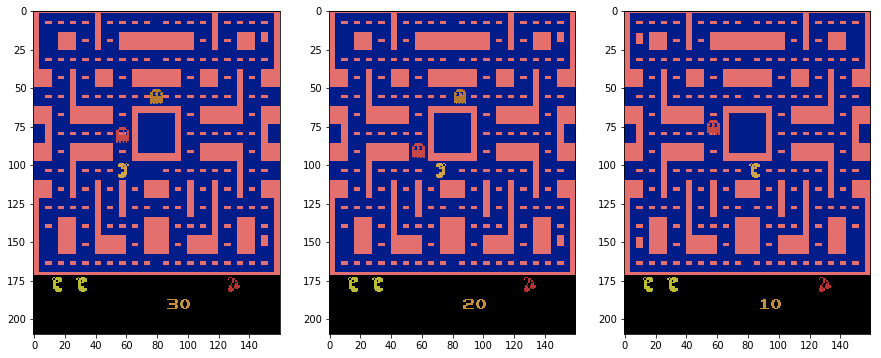

In [33]:
def display_sessions(max_n_sessions = 3):
    """just draw random images"""
    
    plt.figure(figsize=[15,8])
    
    pictures = [atari.render("rgb_array") for atari in pool.envs[:max_n_sessions]]
    for i,pic in enumerate(pictures):
        plt.subplot(1,max_n_sessions,i+1)
        plt.imshow(pic)
    plt.show()
    
#visualize untrained network performance (which is mostly random)
display_sessions()

# Training loop

In [36]:
import os
from agentnet.display import Metrics

score_log = Metrics()
epoch_counter = 1
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


epoch 10, loss 39.93889, reward 2.00000 
rec 39.762 reg 0.177
epoch 20, loss 64.04042, reward 5.55000 
rec 63.789 reg 0.251
epoch 30, loss 73.40385, reward 8.49500 
rec 73.111 reg 0.293
epoch 40, loss 82.90590, reward 10.83300 
rec 82.588 reg 0.318
epoch 50, loss 80.53179, reward 11.62470 
rec 80.197 reg 0.335
epoch 60, loss 87.45588, reward 13.14973 
rec 87.109 reg 0.347
epoch 70, loss 63.31443, reward 13.70976 
rec 62.950 reg 0.365
epoch 80, loss 64.10481, reward 15.40128 
rec 63.729 reg 0.376
epoch 90, loss 50.96562, reward 16.29865 
rec 50.584 reg 0.382
epoch 100, loss 51.17495, reward 16.66879 
rec 50.788 reg 0.387
Learning curves:


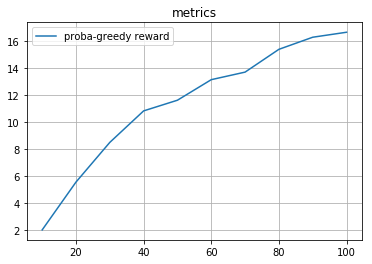

Random session examples


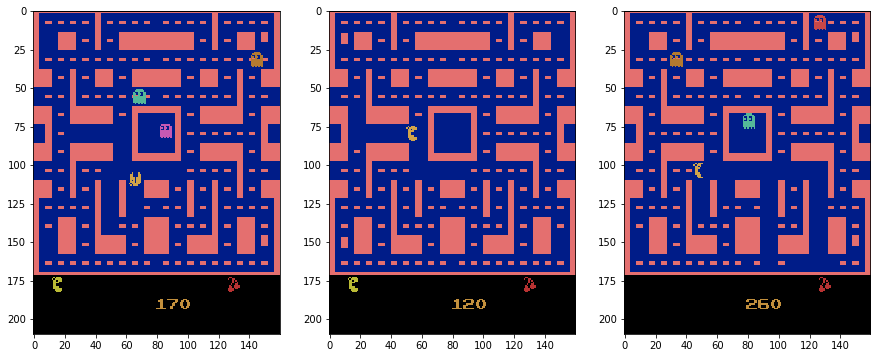

epoch 110, loss 50.52627, reward 17.06441 
rec 50.137 reg 0.390
epoch 120, loss 43.43381, reward 16.92047 
rec 43.045 reg 0.389
epoch 130, loss 45.15804, reward 17.79092 
rec 44.769 reg 0.389
epoch 140, loss 47.96537, reward 18.07433 
rec 47.576 reg 0.390
epoch 150, loss 41.77157, reward 18.39190 
rec 41.381 reg 0.391
epoch 160, loss 33.17433, reward 17.80271 
rec 32.759 reg 0.415
epoch 170, loss 47.92082, reward 17.77244 
rec 47.448 reg 0.473
epoch 180, loss 782.55425, reward 21.74519 
rec 782.040 reg 0.514
epoch 190, loss 77.09965, reward 21.13317 
rec 76.541 reg 0.559
epoch 200, loss 65.40028, reward 20.58236 
rec 64.803 reg 0.597
Learning curves:


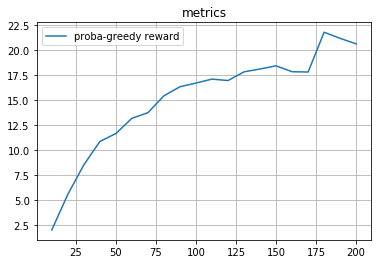

Random session examples


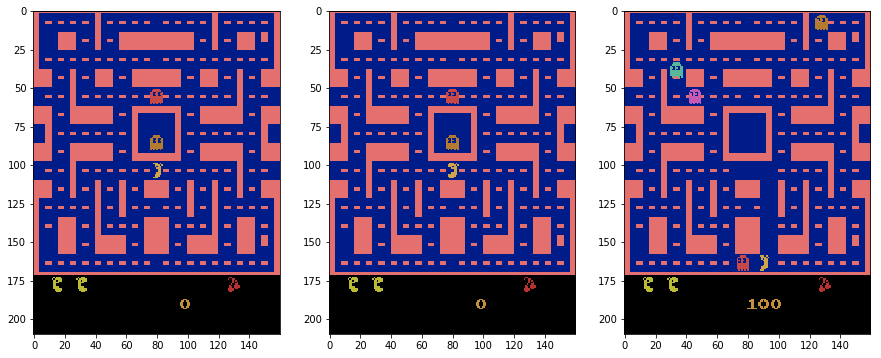

epoch 210, loss 48.46583, reward 20.46162 
rec 47.841 reg 0.625
epoch 220, loss 51.58656, reward 20.85296 
rec 50.947 reg 0.639
epoch 230, loss 50.39656, reward 20.33016 
rec 49.750 reg 0.647
epoch 240, loss 48.05734, reward 20.10965 
rec 47.404 reg 0.653
epoch 250, loss 47.88633, reward 20.66118 
rec 47.230 reg 0.656
epoch 260, loss 46.75408, reward 20.53256 
rec 46.097 reg 0.657
epoch 270, loss 43.20525, reward 20.91681 
rec 42.550 reg 0.656
epoch 280, loss 51.14899, reward 20.57513 
rec 50.493 reg 0.656
epoch 290, loss 52.68927, reward 20.76761 
rec 52.034 reg 0.655
epoch 300, loss 48.61847, reward 21.25335 
rec 47.965 reg 0.653
Learning curves:


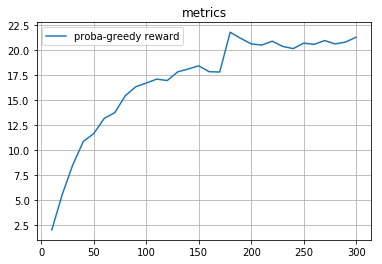

Random session examples


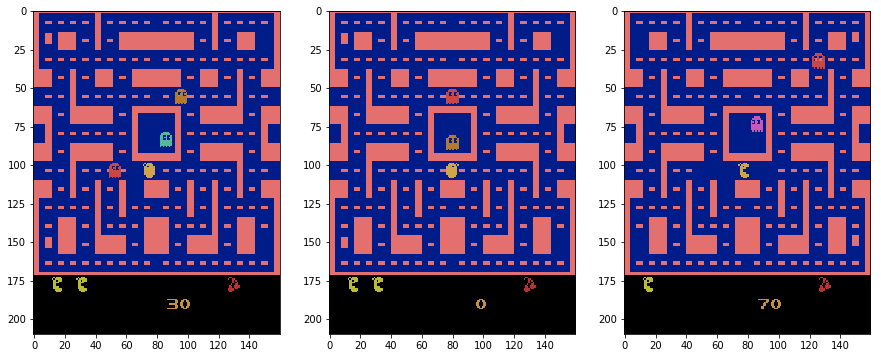

epoch 310, loss 54.63151, reward 21.81552 
rec 53.981 reg 0.650
epoch 320, loss 44.09693, reward 21.19647 
rec 43.450 reg 0.646
epoch 330, loss 54.01804, reward 21.70182 
rec 53.373 reg 0.645
epoch 340, loss 41.72934, reward 21.40664 
rec 41.085 reg 0.645
epoch 350, loss 44.36426, reward 21.26597 
rec 43.719 reg 0.645
epoch 360, loss 5255.94150, reward 27.51438 
rec 5255.295 reg 0.646
epoch 370, loss 62.80338, reward 26.76294 
rec 62.140 reg 0.663
epoch 380, loss 79.40977, reward 27.58664 
rec 78.729 reg 0.681
epoch 390, loss 50.16035, reward 26.64048 
rec 49.466 reg 0.694
epoch 400, loss 48.88982, reward 26.47643 
rec 48.190 reg 0.700
Learning curves:


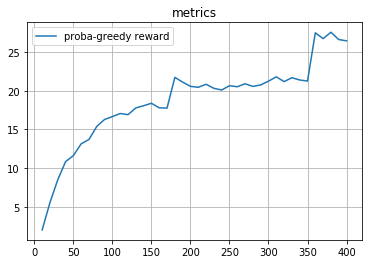

Random session examples


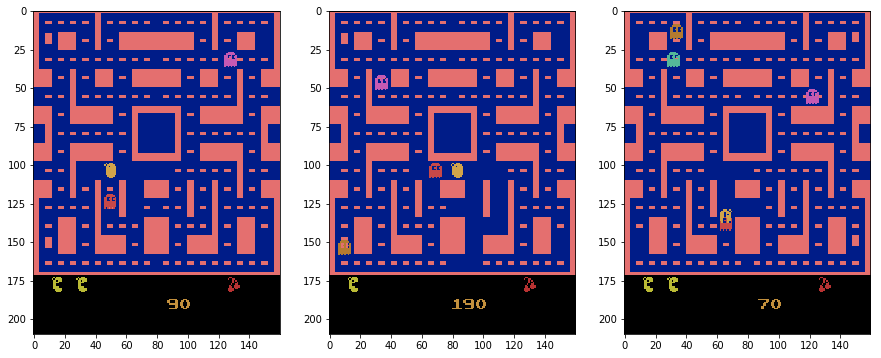

epoch 410, loss 41.89472, reward 25.76629 
rec 41.195 reg 0.699
epoch 420, loss 47.14976, reward 26.18966 
rec 46.452 reg 0.698
epoch 430, loss 59.86806, reward 27.44569 
rec 59.167 reg 0.701
epoch 440, loss 57.61473, reward 28.32612 
rec 56.913 reg 0.702
epoch 450, loss 52.82230, reward 26.93101 
rec 52.122 reg 0.700
epoch 460, loss 73.46988, reward 27.86291 
rec 72.768 reg 0.702
epoch 470, loss 58.52122, reward 27.51412 
rec 57.819 reg 0.702
epoch 480, loss 56.51123, reward 27.88771 
rec 55.812 reg 0.699
epoch 490, loss 37.77860, reward 26.91144 
rec 37.083 reg 0.695
epoch 500, loss 39.85894, reward 26.03279 
rec 39.167 reg 0.692
Learning curves:


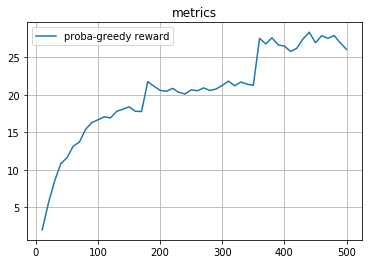

Random session examples


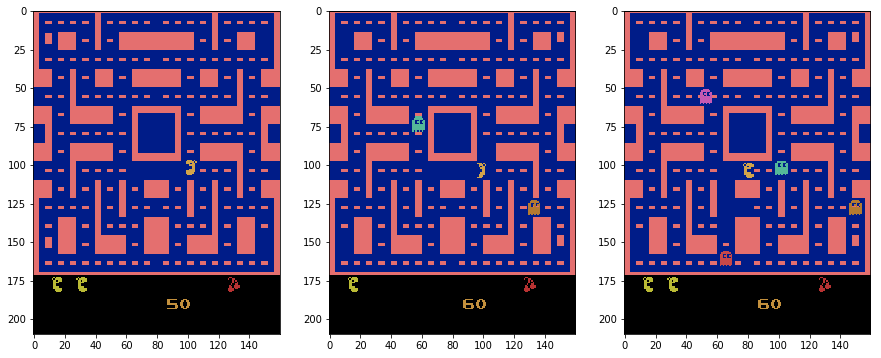

epoch 510, loss 37.51807, reward 25.42951 
rec 36.831 reg 0.687
epoch 520, loss 41.52472, reward 25.38656 
rec 40.842 reg 0.683
epoch 530, loss 45.39219, reward 24.72291 
rec 44.713 reg 0.679
epoch 540, loss 32.24772, reward 23.62562 
rec 31.574 reg 0.674
epoch 550, loss 42.41450, reward 22.70055 
rec 41.744 reg 0.671
epoch 560, loss 52.21245, reward 22.11800 
rec 51.546 reg 0.666
epoch 570, loss 46.01484, reward 22.59370 
rec 45.350 reg 0.664
epoch 580, loss 32.36568, reward 21.83433 
rec 31.703 reg 0.662
epoch 590, loss 48.54050, reward 21.65090 
rec 47.882 reg 0.658
epoch 600, loss 67.01501, reward 22.48581 
rec 66.361 reg 0.654
Learning curves:


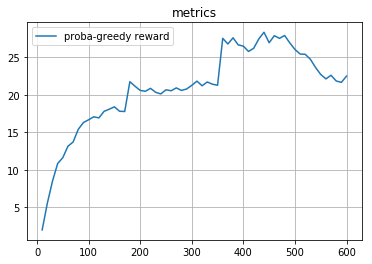

Random session examples


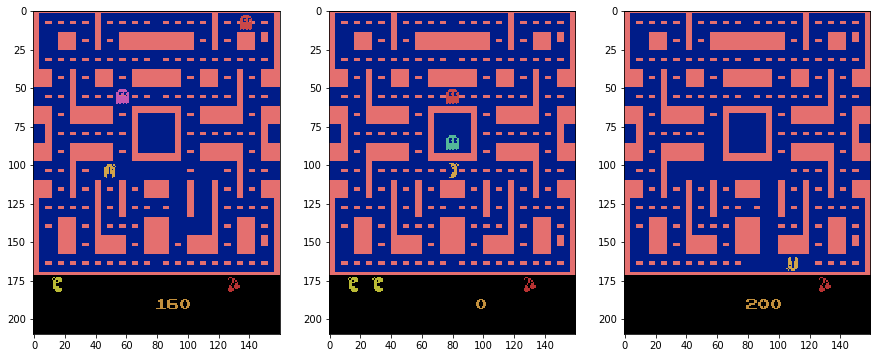

epoch 610, loss 45.96807, reward 22.17473 
rec 45.315 reg 0.653
epoch 620, loss 49.48402, reward 22.33225 
rec 48.829 reg 0.655
epoch 630, loss 43.96960, reward 22.03653 
rec 43.314 reg 0.656
epoch 640, loss 47.60748, reward 22.77038 
rec 46.953 reg 0.655
epoch 650, loss 44.99634, reward 22.49334 
rec 44.345 reg 0.652
epoch 660, loss 44.08700, reward 23.24400 
rec 43.438 reg 0.649
epoch 670, loss 54.63603, reward 24.10710 
rec 53.991 reg 0.645
epoch 680, loss 99.55564, reward 24.88389 
rec 98.910 reg 0.645
epoch 690, loss 61.69654, reward 24.33300 
rec 61.050 reg 0.647
epoch 700, loss 37.07929, reward 23.27470 
rec 36.435 reg 0.644
Learning curves:


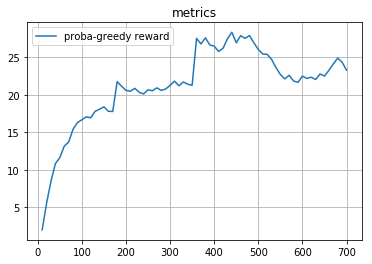

Random session examples


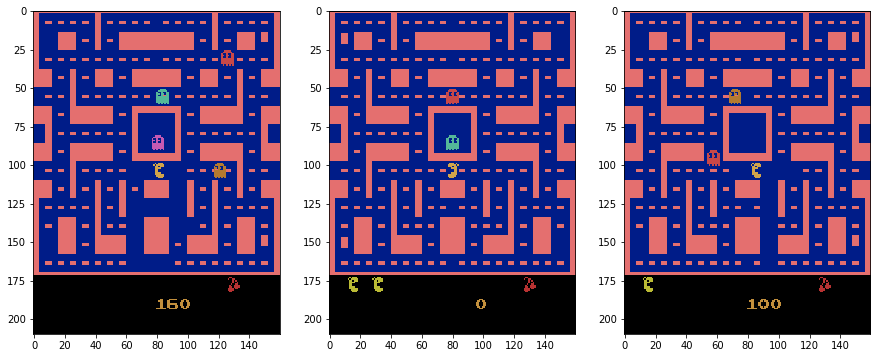

epoch 710, loss 148.79204, reward 24.57223 
rec 148.148 reg 0.644
epoch 720, loss 51.06745, reward 24.24001 
rec 50.424 reg 0.643
epoch 730, loss 44.17684, reward 23.50351 
rec 43.537 reg 0.640
epoch 740, loss 34.83859, reward 23.09066 
rec 34.204 reg 0.634
epoch 750, loss 42.59876, reward 22.90659 
rec 41.968 reg 0.631
epoch 760, loss 42.57336, reward 22.67843 
rec 41.945 reg 0.628
epoch 770, loss 41.04545, reward 22.78559 
rec 40.420 reg 0.625
epoch 780, loss 60.92692, reward 23.25703 
rec 60.305 reg 0.622
epoch 790, loss 46.58350, reward 23.11883 
rec 45.963 reg 0.620
epoch 800, loss 39.99248, reward 22.61944 
rec 39.375 reg 0.617
Learning curves:


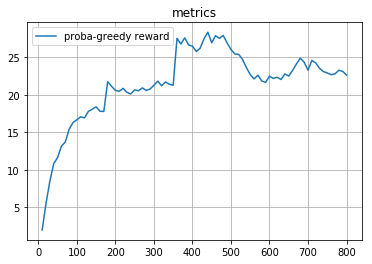

Random session examples


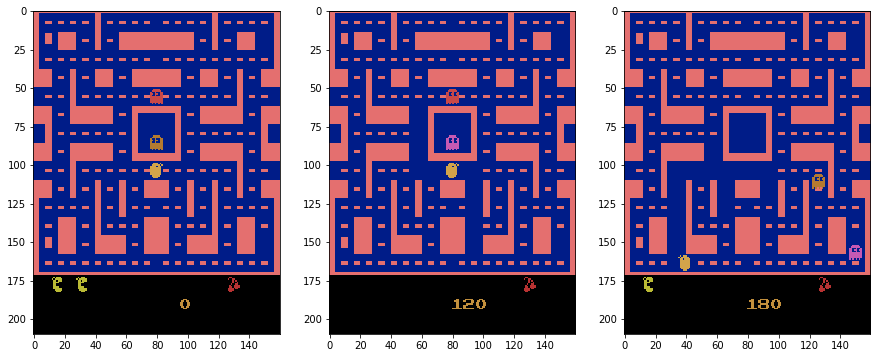

epoch 810, loss 49.46311, reward 23.23250 
rec 48.850 reg 0.613
epoch 820, loss 52.09002, reward 23.53425 
rec 51.480 reg 0.610
epoch 830, loss 52.31335, reward 23.99333 
rec 51.707 reg 0.607
epoch 840, loss 48.39852, reward 24.15649 
rec 47.795 reg 0.603
epoch 850, loss 36.77237, reward 22.67834 
rec 36.173 reg 0.600
epoch 860, loss 53.10027, reward 22.47301 
rec 52.502 reg 0.598
epoch 870, loss 47.69030, reward 22.60071 
rec 47.094 reg 0.596
epoch 880, loss 35.43032, reward 21.59064 
rec 34.838 reg 0.592
epoch 890, loss 44.77325, reward 21.43157 
rec 44.185 reg 0.588
epoch 900, loss 46.81401, reward 22.03842 
rec 46.228 reg 0.586
Learning curves:


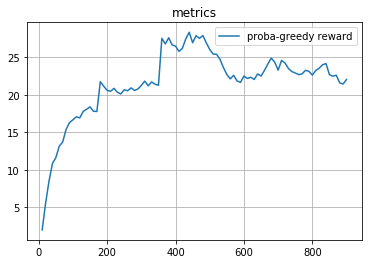

Random session examples


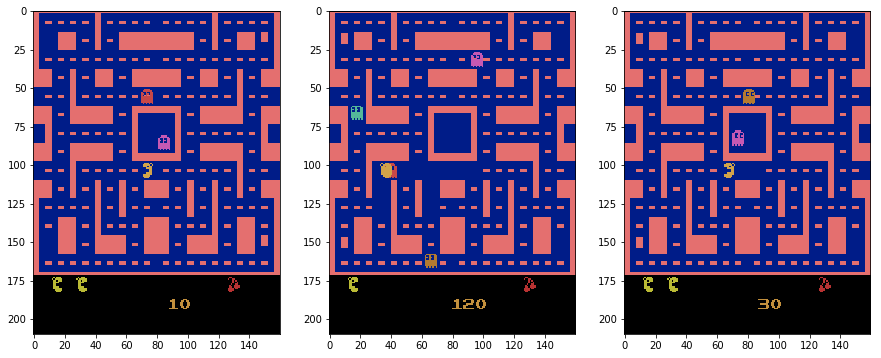

epoch 910, loss 45.74105, reward 21.64707 
rec 45.157 reg 0.584
epoch 920, loss 42.92062, reward 21.23237 
rec 42.335 reg 0.585
epoch 930, loss 61.79096, reward 21.42163 
rec 61.205 reg 0.586
epoch 940, loss 160.16792, reward 22.65447 
rec 159.580 reg 0.588
epoch 950, loss 49.07682, reward 22.51402 
rec 48.483 reg 0.594
epoch 960, loss 44.42544, reward 22.82512 
rec 43.825 reg 0.600
epoch 970, loss 35.79253, reward 22.29261 
rec 35.187 reg 0.605
epoch 980, loss 54.17249, reward 23.12585 
rec 53.566 reg 0.607
epoch 990, loss 46.89706, reward 22.43826 
rec 46.291 reg 0.606
epoch 1000, loss 39.48265, reward 22.19444 
rec 38.881 reg 0.602
Learning curves:


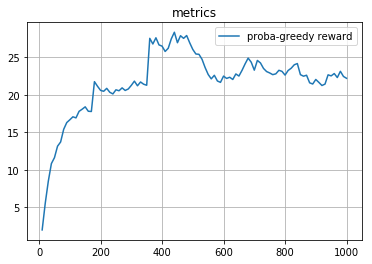

Random session examples


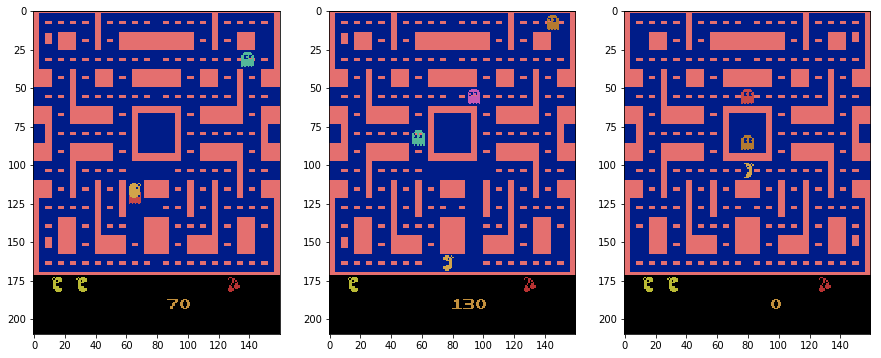

[2017-05-24 01:47:02,611] Making new env: MsPacman-v0
[2017-05-24 01:47:02,794] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.0.6612.video000000.mp4
[2017-05-24 01:47:04,168] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.0.6612.video000001.mp4


Episode finished after 680 timesteps, rw = 170.0
Episode finished after 723 timesteps, rw = 270.0
Episode finished after 579 timesteps, rw = 170.0
Episode finished after 607 timesteps, rw = 270.0
Episode finished after 672 timesteps, rw = 220.0
Episode finished after 654 timesteps, rw = 200.0
Episode finished after 584 timesteps, rw = 230.0


[2017-05-24 01:47:11,333] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.0.6612.video000008.mp4


Episode finished after 683 timesteps, rw = 210.0
Episode finished after 551 timesteps, rw = 160.0
Episode finished after 547 timesteps, rw = 240.0
Episode finished after 682 timesteps, rw = 250.0
Episode finished after 525 timesteps, rw = 210.0
Episode finished after 602 timesteps, rw = 210.0
Episode finished after 716 timesteps, rw = 280.0
Episode finished after 612 timesteps, rw = 220.0
Episode finished after 782 timesteps, rw = 280.0
Episode finished after 717 timesteps, rw = 210.0
Episode finished after 602 timesteps, rw = 240.0
Episode finished after 651 timesteps, rw = 260.0


[2017-05-24 01:47:23,278] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/proba_videos')


Episode finished after 626 timesteps, rw = 160.0
Mean 223.0, Var 1421.0
epoch 1010, loss 57.59556, reward 22.72499 
rec 56.997 reg 0.598
epoch 1020, loss 32.43255, reward 21.88999 
rec 31.836 reg 0.597
epoch 1030, loss 35.65724, reward 21.57599 
rec 35.063 reg 0.595
epoch 1040, loss 52.48950, reward 22.04339 
rec 51.897 reg 0.592
epoch 1050, loss 47.82982, reward 22.08905 
rec 47.236 reg 0.594
epoch 1060, loss 59.14112, reward 22.63015 
rec 58.549 reg 0.592
epoch 1070, loss 41.91322, reward 22.42963 
rec 41.323 reg 0.590
epoch 1080, loss 61.46183, reward 23.06167 
rec 60.875 reg 0.587
epoch 1090, loss 57.15272, reward 23.63050 
rec 56.567 reg 0.585
epoch 1100, loss 55.74938, reward 23.57995 
rec 55.153 reg 0.597
Learning curves:


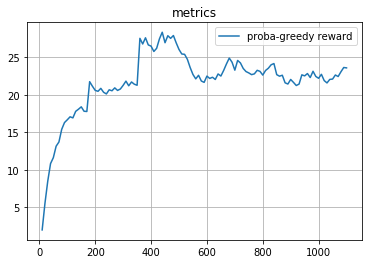

Random session examples


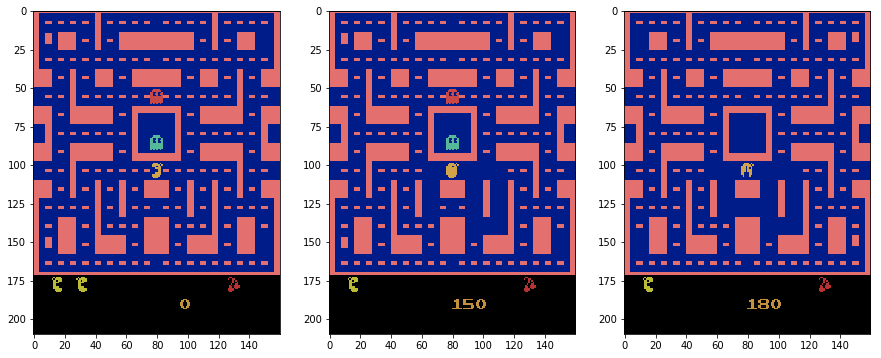

epoch 1110, loss 47.29548, reward 22.90946 
rec 46.667 reg 0.628
epoch 1120, loss 53.64538, reward 23.18101 
rec 52.970 reg 0.675
epoch 1130, loss 46.92121, reward 23.17541 
rec 46.204 reg 0.718
epoch 1140, loss 62.22374, reward 24.10787 
rec 61.486 reg 0.738
epoch 1150, loss 54.60274, reward 24.00958 
rec 53.856 reg 0.746
epoch 1160, loss 45.09931, reward 23.42112 
rec 44.353 reg 0.747
epoch 1170, loss 54.32105, reward 23.45401 
rec 53.576 reg 0.745
epoch 1180, loss 47.62798, reward 22.98361 
rec 46.885 reg 0.743
epoch 1190, loss 63.89579, reward 23.74775 
rec 63.155 reg 0.741
epoch 1200, loss 46.08106, reward 23.87297 
rec 45.346 reg 0.735
Learning curves:


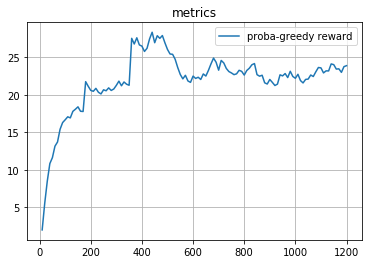

Random session examples


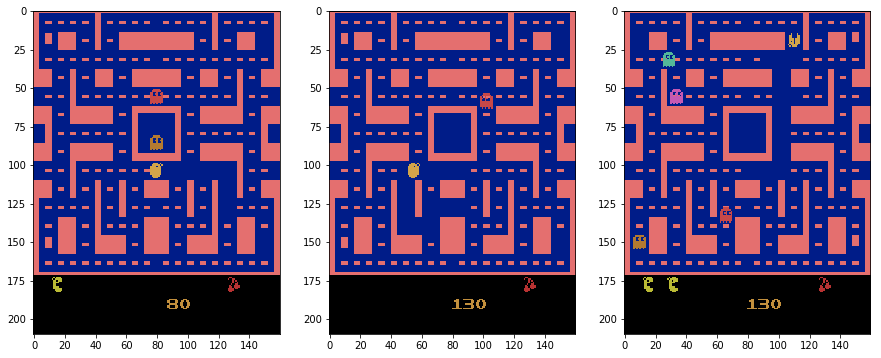

epoch 1210, loss 54.73556, reward 24.04818 
rec 54.005 reg 0.731
epoch 1220, loss 39.43583, reward 23.14336 
rec 38.710 reg 0.726
epoch 1230, loss 51.53657, reward 22.76652 
rec 50.817 reg 0.720
epoch 1240, loss 46.75275, reward 22.92737 
rec 46.039 reg 0.713
epoch 1250, loss 54.80665, reward 23.25963 
rec 54.096 reg 0.710
epoch 1260, loss 49.89183, reward 22.62117 
rec 49.178 reg 0.713
epoch 1270, loss 45.81560, reward 22.60905 
rec 45.098 reg 0.718
epoch 1280, loss 62.52194, reward 22.53565 
rec 61.799 reg 0.723
epoch 1290, loss 52.52113, reward 22.40708 
rec 51.798 reg 0.723
epoch 1300, loss 54.64960, reward 22.16638 
rec 53.924 reg 0.725
Learning curves:


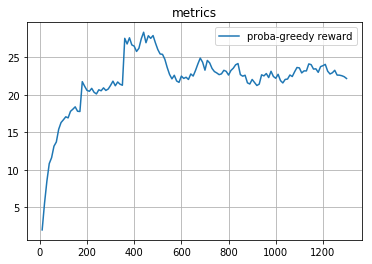

Random session examples


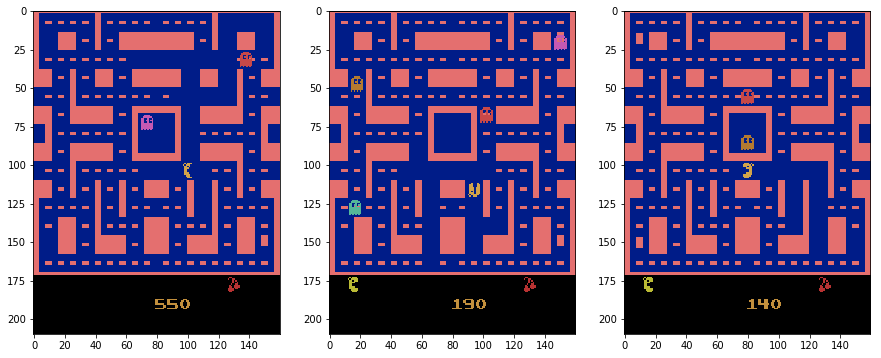

epoch 1310, loss 47.83962, reward 21.63724 
rec 47.109 reg 0.731
epoch 1320, loss 44.96482, reward 21.72351 
rec 44.235 reg 0.730
epoch 1330, loss 35.91769, reward 21.17616 
rec 35.192 reg 0.726
epoch 1340, loss 37.79208, reward 20.55855 
rec 37.071 reg 0.722
epoch 1740, loss 49.15744, reward 21.35511 
rec 48.465 reg 0.693
epoch 1750, loss 53.37091, reward 21.28210 
rec 52.679 reg 0.692
epoch 1760, loss 343.06865, reward 22.96639 
rec 342.379 reg 0.690
epoch 1770, loss 55.16739, reward 22.73225 
rec 54.467 reg 0.700
epoch 1780, loss 194.78434, reward 24.39653 
rec 194.074 reg 0.711
epoch 1790, loss 54.56243, reward 24.58187 
rec 53.844 reg 0.718
epoch 1800, loss 47.22907, reward 23.56119 
rec 46.510 reg 0.719
Learning curves:


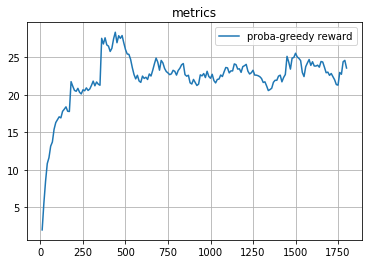

Random session examples


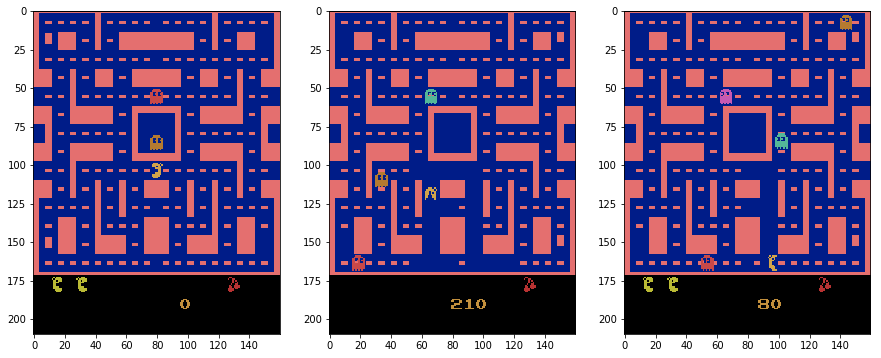

epoch 1810, loss 44.52601, reward 22.76757 
rec 43.796 reg 0.730
epoch 1820, loss 51.11944, reward 21.86581 
rec 50.382 reg 0.737
epoch 1830, loss 56.74996, reward 21.99173 
rec 56.013 reg 0.737
epoch 1840, loss 47.57020, reward 21.85506 
rec 46.836 reg 0.734
epoch 1850, loss 49.30990, reward 22.16955 
rec 48.581 reg 0.729
epoch 1860, loss 41.29683, reward 22.01510 
rec 40.573 reg 0.724
epoch 1870, loss 117.29069, reward 23.37609 
rec 116.571 reg 0.719
epoch 1880, loss 47.54624, reward 23.16348 
rec 46.831 reg 0.716
epoch 1890, loss 39.39786, reward 22.65963 
rec 38.687 reg 0.711
epoch 1900, loss 48.78775, reward 22.58117 
rec 48.076 reg 0.712
Learning curves:


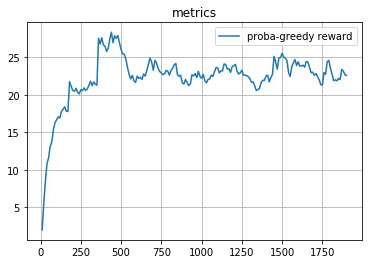

Random session examples


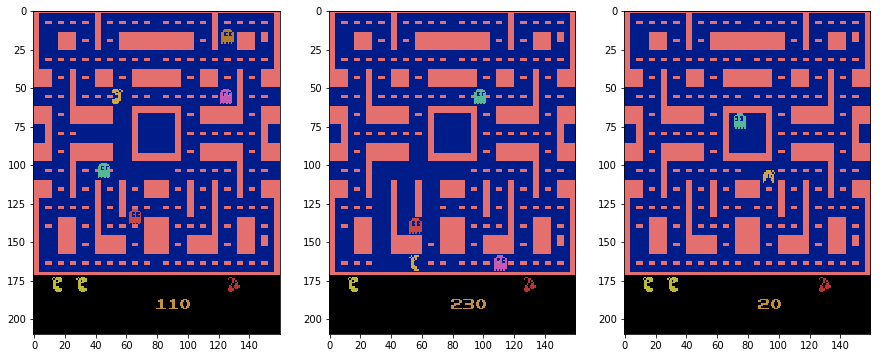

epoch 1910, loss 48.01830, reward 21.69805 
rec 47.307 reg 0.711
epoch 1920, loss 53.65283, reward 21.40325 
rec 52.944 reg 0.709
epoch 1930, loss 44.45903, reward 21.32542 
rec 43.753 reg 0.706
epoch 1940, loss 49.58829, reward 20.31788 
rec 48.886 reg 0.702
epoch 1950, loss 58.11542, reward 20.28609 
rec 57.416 reg 0.699
epoch 1960, loss 41.76777, reward 19.75748 
rec 41.073 reg 0.694
epoch 1970, loss 42.80441, reward 20.15673 
rec 42.116 reg 0.688
epoch 1980, loss 59.94206, reward 20.39106 
rec 59.258 reg 0.684
epoch 1990, loss 50.02287, reward 19.85195 
rec 49.342 reg 0.681
epoch 2000, loss 40.97483, reward 19.99176 
rec 40.299 reg 0.676
Learning curves:


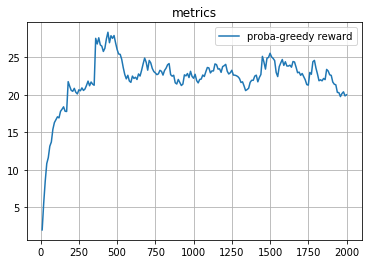

Random session examples


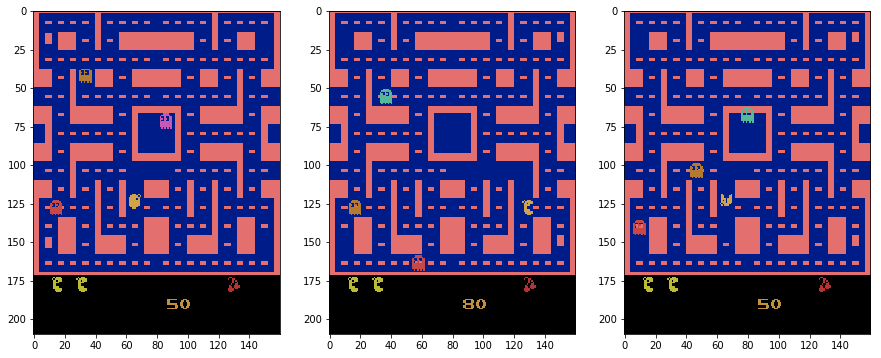

[2017-05-24 02:08:21,701] Making new env: MsPacman-v0
[2017-05-24 02:08:21,870] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 02:08:21,878] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.1.6612.video000000.mp4
[2017-05-24 02:08:23,803] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.1.6612.video000001.mp4


Episode finished after 979 timesteps, rw = 1030.0
Episode finished after 614 timesteps, rw = 230.0
Episode finished after 685 timesteps, rw = 200.0
Episode finished after 442 timesteps, rw = 100.0
Episode finished after 718 timesteps, rw = 290.0
Episode finished after 743 timesteps, rw = 170.0
Episode finished after 694 timesteps, rw = 190.0


[2017-05-24 02:08:30,596] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.1.6612.video000008.mp4


Episode finished after 462 timesteps, rw = 140.0
Episode finished after 805 timesteps, rw = 250.0
Episode finished after 663 timesteps, rw = 210.0
Episode finished after 793 timesteps, rw = 260.0
Episode finished after 821 timesteps, rw = 210.0
Episode finished after 648 timesteps, rw = 160.0
Episode finished after 625 timesteps, rw = 120.0
Episode finished after 929 timesteps, rw = 1750.0
Episode finished after 667 timesteps, rw = 240.0
Episode finished after 685 timesteps, rw = 240.0
Episode finished after 634 timesteps, rw = 170.0
Episode finished after 631 timesteps, rw = 260.0


[2017-05-24 02:08:43,395] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/proba_videos')


Episode finished after 551 timesteps, rw = 130.0
Mean 317.5, Var 143288.75
epoch 2010, loss 42.38537, reward 20.49258 
rec 41.713 reg 0.673
epoch 2020, loss 43.26888, reward 20.63082 
rec 42.597 reg 0.672
epoch 2030, loss 38.83517, reward 20.06774 
rec 38.167 reg 0.668
epoch 2040, loss 42.06197, reward 19.18597 
rec 41.396 reg 0.666
epoch 2050, loss 49.05359, reward 20.20487 
rec 48.392 reg 0.662
epoch 2060, loss 52.46044, reward 20.87188 
rec 51.801 reg 0.659
epoch 2070, loss 55.66026, reward 20.97220 
rec 55.004 reg 0.657
epoch 2080, loss 48.35034, reward 19.99998 
rec 47.698 reg 0.652
epoch 2090, loss 39.88952, reward 19.31248 
rec 39.242 reg 0.647
epoch 2100, loss 45.90882, reward 19.13123 
rec 45.263 reg 0.646
Learning curves:


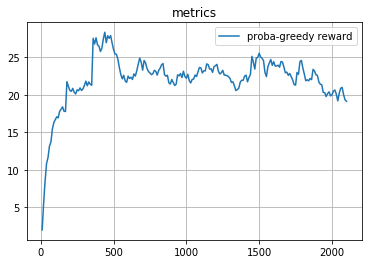

Random session examples


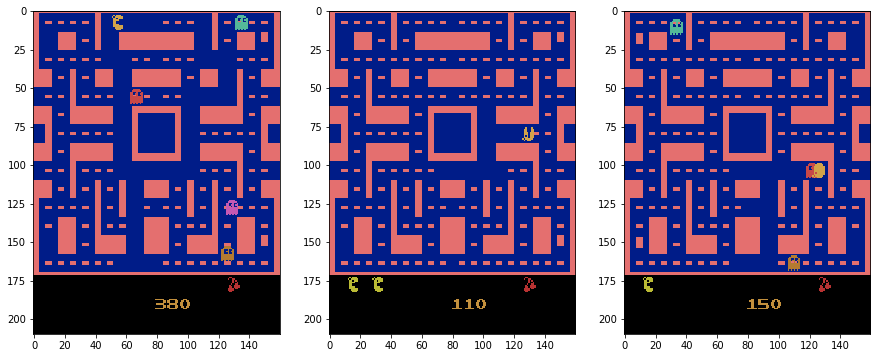

epoch 2110, loss 48.91924, reward 18.90561 
rec 48.276 reg 0.644
epoch 2120, loss 42.33470, reward 19.26505 
rec 41.696 reg 0.639
epoch 2130, loss 52.68878, reward 20.58854 
rec 52.051 reg 0.637
epoch 2140, loss 40.26433, reward 20.52969 
rec 39.628 reg 0.636
epoch 2150, loss 43.97871, reward 20.03922 
rec 43.343 reg 0.635
epoch 2160, loss 49.75241, reward 19.97280 
rec 49.113 reg 0.639
epoch 2170, loss 50.30647, reward 20.41302 
rec 49.665 reg 0.641
epoch 2180, loss 44.17483, reward 20.05922 
rec 43.535 reg 0.640
epoch 2190, loss 55.58898, reward 20.74079 
rec 54.953 reg 0.636
epoch 2200, loss 53.13694, reward 21.16671 
rec 52.505 reg 0.632
Learning curves:


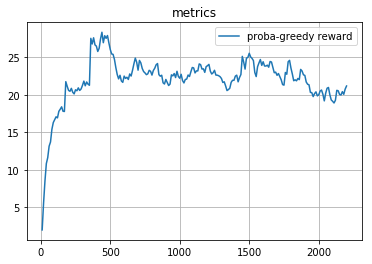

Random session examples


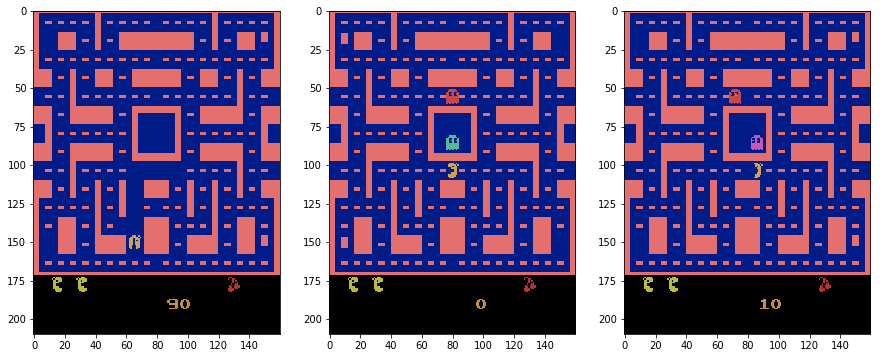

epoch 2210, loss 68.05767, reward 22.23754 
rec 67.430 reg 0.628
epoch 2220, loss 1031.91453, reward 26.20129 
rec 1031.289 reg 0.625
epoch 2230, loss 62.50124, reward 24.95616 
rec 61.867 reg 0.635
epoch 2240, loss 44.53956, reward 23.71054 
rec 43.896 reg 0.644
epoch 2250, loss 45.44592, reward 23.40199 
rec 44.792 reg 0.654
epoch 2260, loss 401.90722, reward 24.24929 
rec 401.248 reg 0.660
epoch 2270, loss 57.44233, reward 24.38686 
rec 56.774 reg 0.668
epoch 2280, loss 48.25046, reward 24.44818 
rec 47.579 reg 0.672
epoch 2290, loss 42.07474, reward 24.37836 
rec 41.406 reg 0.669
epoch 2300, loss 39.17886, reward 24.00302 
rec 38.512 reg 0.667
Learning curves:


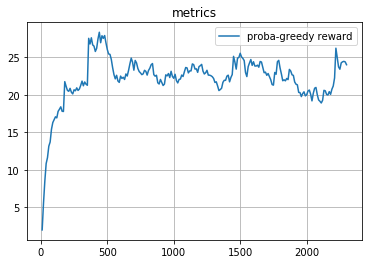

Random session examples


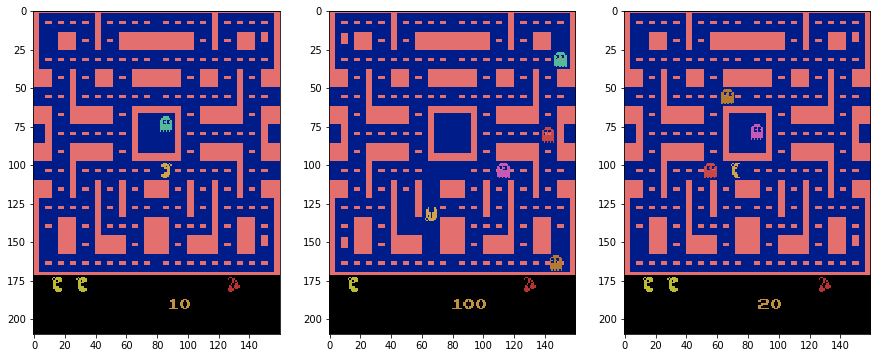

epoch 2310, loss 52.50735, reward 23.41522 
rec 51.843 reg 0.664
epoch 2320, loss 46.82781, reward 22.76120 
rec 46.168 reg 0.660
epoch 2330, loss 44.84956, reward 22.42258 
rec 44.193 reg 0.656
epoch 2340, loss 51.17611, reward 22.24282 
rec 50.524 reg 0.652
epoch 2350, loss 52.37834, reward 22.26854 
rec 51.730 reg 0.648
epoch 2360, loss 47.41594, reward 22.29168 
rec 46.771 reg 0.645
epoch 2370, loss 50.22775, reward 22.81252 
rec 49.586 reg 0.641
epoch 2380, loss 47.46449, reward 22.65626 
rec 46.827 reg 0.638
epoch 2390, loss 42.97066, reward 22.89064 
rec 42.335 reg 0.635
epoch 2400, loss 55.60144, reward 24.10157 
rec 54.971 reg 0.631
Learning curves:


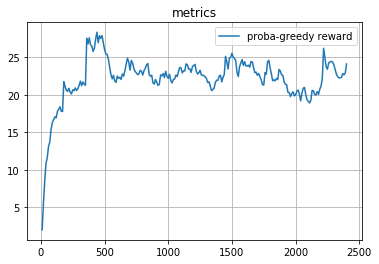

Random session examples


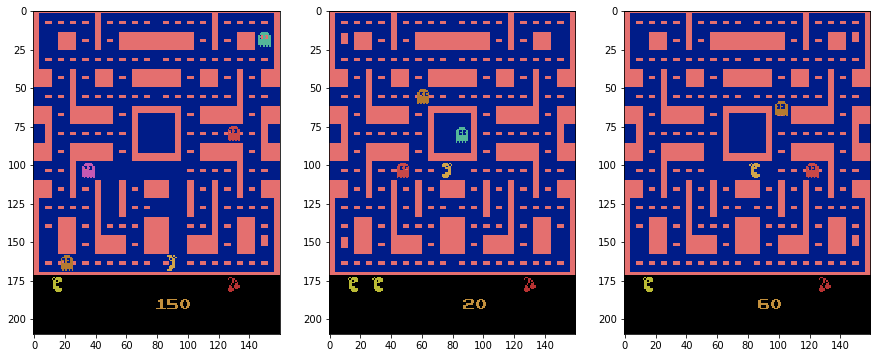

epoch 2410, loss 42.73218, reward 23.50392 
rec 42.105 reg 0.627
epoch 2420, loss 48.96655, reward 22.40353 
rec 48.341 reg 0.626
epoch 2430, loss 57.45840, reward 22.35067 
rec 56.830 reg 0.629
epoch 2440, loss 79.86782, reward 21.99061 
rec 79.238 reg 0.630
epoch 2450, loss 63.59866, reward 22.54154 
rec 62.971 reg 0.628
epoch 2460, loss 47.62828, reward 22.59989 
rec 47.001 reg 0.627
epoch 2470, loss 50.00961, reward 21.77740 
rec 49.383 reg 0.626
epoch 2480, loss 60.45574, reward 21.91216 
rec 59.832 reg 0.624
epoch 2490, loss 48.61247, reward 21.90845 
rec 47.991 reg 0.621
epoch 2500, loss 66.58397, reward 22.40510 
rec 65.956 reg 0.628
Learning curves:


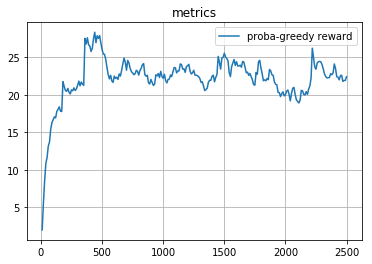

Random session examples


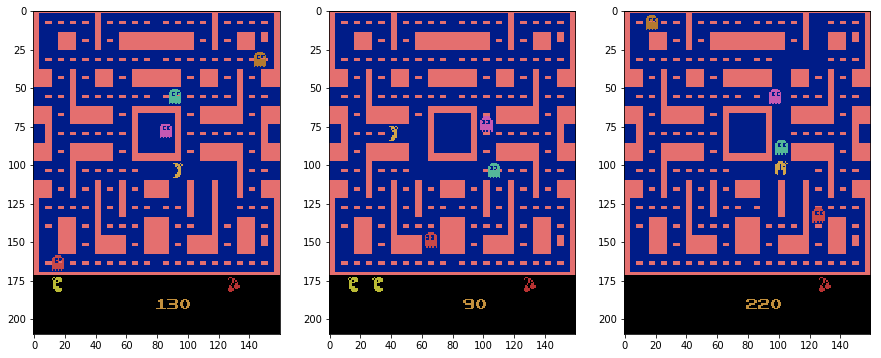

epoch 2510, loss 76.98496, reward 21.91459 
rec 76.343 reg 0.642
epoch 2520, loss 54.44962, reward 22.84813 
rec 53.805 reg 0.645
epoch 2530, loss 59.06366, reward 23.68832 
rec 58.416 reg 0.647
epoch 2540, loss 55.44826, reward 23.94449 
rec 54.780 reg 0.669
epoch 2550, loss 55.24019, reward 23.30004 
rec 54.549 reg 0.691
epoch 2560, loss 51.84592, reward 22.90753 
rec 51.145 reg 0.701
epoch 2570, loss 56.32974, reward 23.80428 
rec 55.629 reg 0.701
epoch 2580, loss 42.05043, reward 23.54885 
rec 41.350 reg 0.700
epoch 2590, loss 41.62961, reward 23.38147 
rec 40.927 reg 0.702
epoch 2600, loss 51.01547, reward 23.10582 
rec 50.314 reg 0.702
Learning curves:


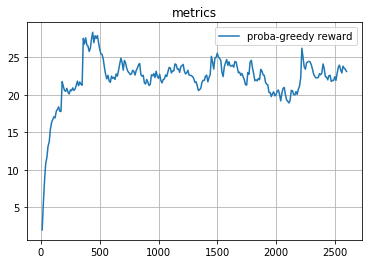

Random session examples


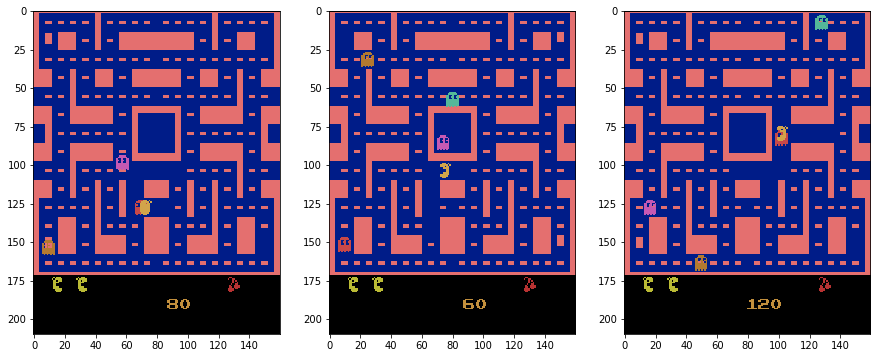

epoch 2610, loss 66.11213, reward 23.35774 
rec 65.410 reg 0.702
epoch 2620, loss 58.91410, reward 23.27196 
rec 58.200 reg 0.714
epoch 2630, loss 44.68953, reward 22.50727 
rec 43.971 reg 0.718
epoch 2640, loss 52.88630, reward 23.31904 
rec 52.168 reg 0.719
epoch 2650, loss 55.65773, reward 23.79964 
rec 54.941 reg 0.717
epoch 2660, loss 47.91241, reward 23.79467 
rec 47.200 reg 0.713
epoch 2670, loss 45.36999, reward 24.54021 
rec 44.663 reg 0.707
epoch 2680, loss 45.39946, reward 24.39869 
rec 44.696 reg 0.703
epoch 2690, loss 46.61860, reward 23.14632 
rec 45.919 reg 0.699
epoch 2700, loss 46.17413, reward 22.14419 
rec 45.476 reg 0.698
Learning curves:


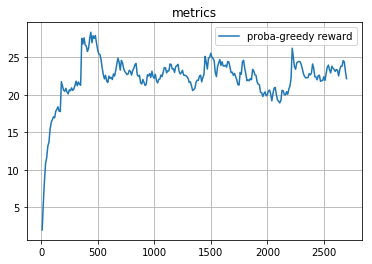

Random session examples


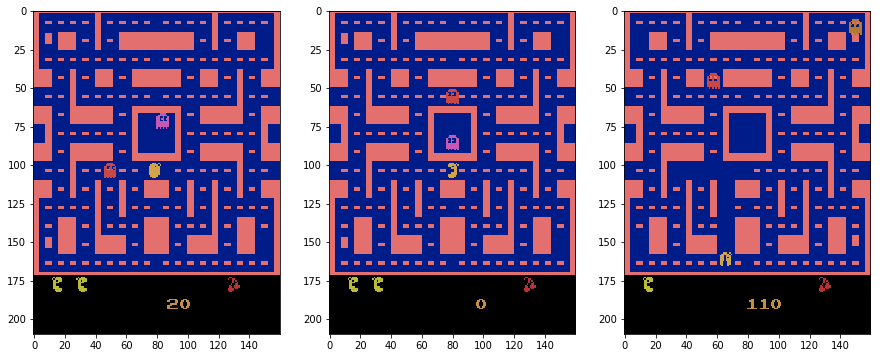

epoch 2710, loss 383.92696, reward 24.11727 
rec 383.230 reg 0.697
epoch 2720, loss 58.60824, reward 23.89304 
rec 57.912 reg 0.696
epoch 2730, loss 56.12949, reward 23.62874 
rec 55.430 reg 0.700
epoch 2740, loss 58.75202, reward 23.57836 
rec 58.048 reg 0.704
epoch 2750, loss 38.57689, reward 22.53303 
rec 37.876 reg 0.701
epoch 2760, loss 38.66575, reward 21.90472 
rec 37.969 reg 0.697
epoch 2770, loss 52.16246, reward 22.90175 
rec 51.468 reg 0.694
epoch 2780, loss 46.89719, reward 22.92408 
rec 46.206 reg 0.691
epoch 2790, loss 66.56786, reward 22.63167 
rec 65.876 reg 0.692
epoch 2800, loss 72.30148, reward 22.36850 
rec 71.606 reg 0.696
Learning curves:


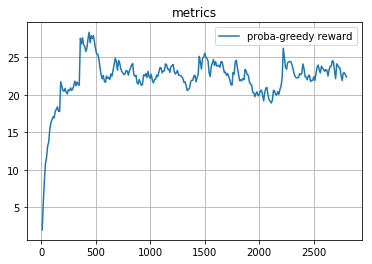

Random session examples


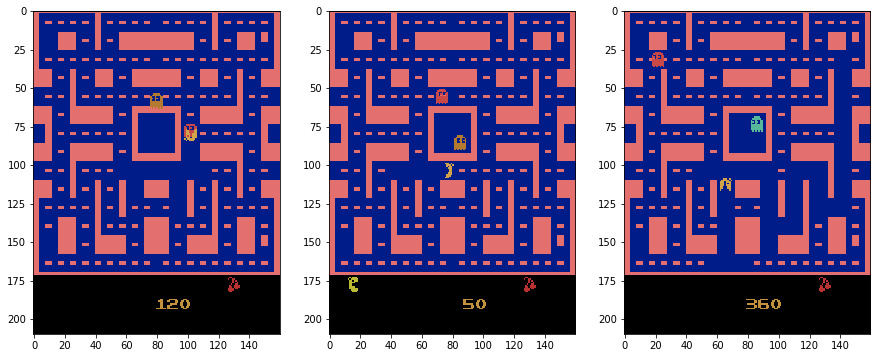

epoch 2810, loss 45.01493, reward 22.19415 
rec 44.320 reg 0.695
epoch 2820, loss 34.52057, reward 21.59974 
rec 33.828 reg 0.692
epoch 2830, loss 36.08310, reward 20.93976 
rec 35.389 reg 0.694
epoch 2840, loss 63.04688, reward 21.90829 
rec 62.350 reg 0.697
epoch 2850, loss 48.32349, reward 22.09246 
rec 47.626 reg 0.698
epoch 2860, loss 54.66812, reward 22.25821 
rec 53.971 reg 0.697
epoch 2870, loss 42.17380, reward 21.28239 
rec 41.479 reg 0.695
epoch 2880, loss 41.83673, reward 21.09165 
rec 41.146 reg 0.691
epoch 2890, loss 50.49922, reward 21.48249 
rec 49.812 reg 0.687
epoch 2900, loss 56.07844, reward 21.64674 
rec 55.396 reg 0.682
Learning curves:


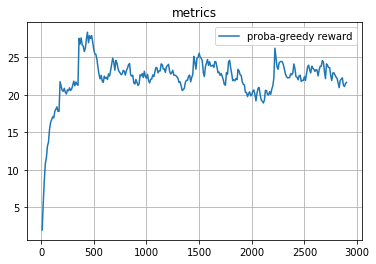

Random session examples


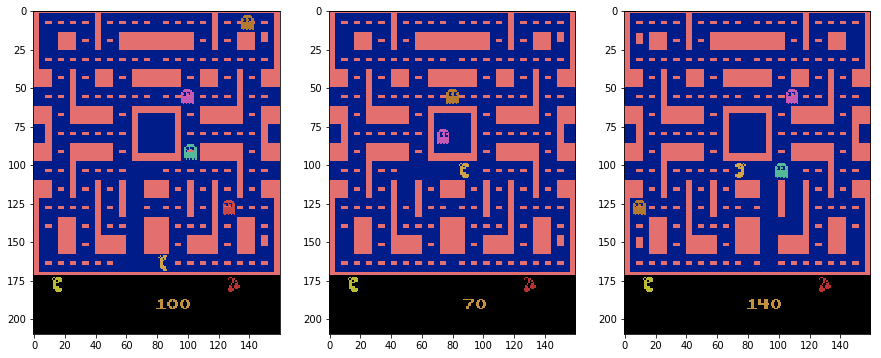

epoch 2910, loss 50.06564, reward 21.73206 
rec 49.388 reg 0.678
epoch 2920, loss 56.55811, reward 23.05886 
rec 55.884 reg 0.674
epoch 2930, loss 53.70885, reward 23.75297 
rec 53.039 reg 0.670
epoch 2940, loss 83.37074, reward 24.69017 
rec 82.700 reg 0.671
epoch 2950, loss 65.65316, reward 24.53366 
rec 64.972 reg 0.682
epoch 2960, loss 56.57114, reward 23.51779 
rec 55.876 reg 0.695
epoch 2970, loss 55.81927, reward 23.10351 
rec 55.119 reg 0.700
epoch 2980, loss 44.37809, reward 23.35566 
rec 43.679 reg 0.699
epoch 2990, loss 42.24115, reward 23.08260 
rec 41.543 reg 0.698
epoch 3000, loss 50.15491, reward 23.58684 
rec 49.460 reg 0.695
Learning curves:


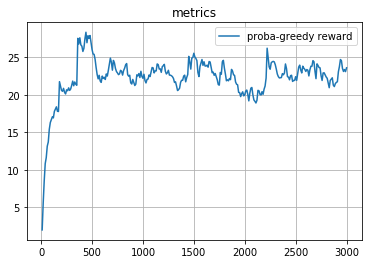

Random session examples


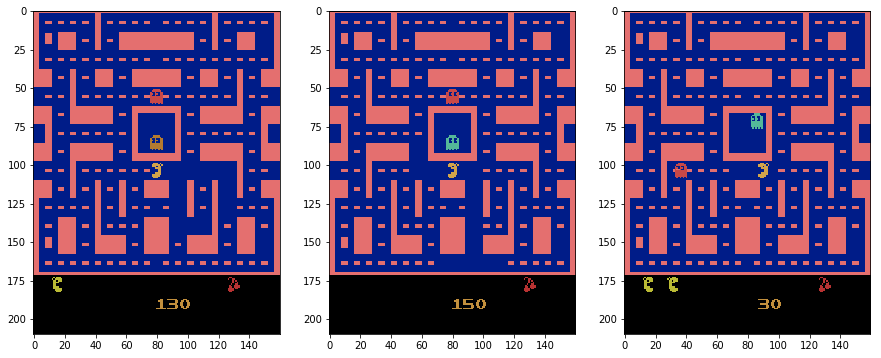

[2017-05-24 02:29:37,680] Making new env: MsPacman-v0
[2017-05-24 02:29:37,844] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 02:29:37,854] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.2.6612.video000000.mp4
[2017-05-24 02:29:39,364] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.2.6612.video000001.mp4


Episode finished after 703 timesteps, rw = 240.0
Episode finished after 744 timesteps, rw = 220.0
Episode finished after 632 timesteps, rw = 240.0
Episode finished after 570 timesteps, rw = 160.0
Episode finished after 514 timesteps, rw = 120.0
Episode finished after 671 timesteps, rw = 300.0
Episode finished after 657 timesteps, rw = 200.0


[2017-05-24 02:29:46,504] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.2.6612.video000008.mp4


Episode finished after 450 timesteps, rw = 140.0
Episode finished after 947 timesteps, rw = 1800.0
Episode finished after 569 timesteps, rw = 100.0
Episode finished after 623 timesteps, rw = 150.0
Episode finished after 636 timesteps, rw = 190.0
Episode finished after 572 timesteps, rw = 140.0
Episode finished after 664 timesteps, rw = 230.0
Episode finished after 776 timesteps, rw = 280.0
Episode finished after 746 timesteps, rw = 190.0
Episode finished after 647 timesteps, rw = 170.0
Episode finished after 537 timesteps, rw = 200.0
Episode finished after 696 timesteps, rw = 300.0


[2017-05-24 02:29:59,524] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/proba_videos')


Episode finished after 628 timesteps, rw = 190.0
Mean 278.0, Var 124906.0
epoch 3010, loss 37.16443, reward 22.54065 
rec 36.465 reg 0.700
epoch 3020, loss 47.13523, reward 22.66159 
rec 46.434 reg 0.701
epoch 3030, loss 45.76315, reward 22.33293 
rec 45.064 reg 0.699
epoch 3040, loss 300.86906, reward 23.22464 
rec 300.172 reg 0.697
epoch 3050, loss 57.99491, reward 23.71467 
rec 57.300 reg 0.695
epoch 3060, loss 51.15996, reward 23.84320 
rec 50.469 reg 0.691
epoch 3070, loss 151.78093, reward 24.95888 
rec 151.093 reg 0.688
epoch 3080, loss 48.95183, reward 24.15050 
rec 48.258 reg 0.694
epoch 3090, loss 35.59872, reward 23.79795 
rec 34.897 reg 0.701
epoch 3100, loss 49.14845, reward 24.29315 
rec 48.445 reg 0.704
Learning curves:


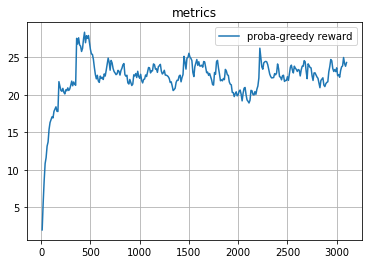

Random session examples


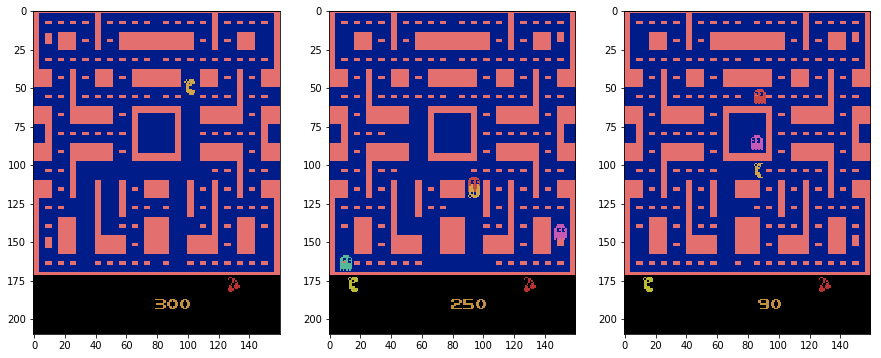

epoch 3110, loss 76.48241, reward 25.11384 
rec 75.780 reg 0.702
epoch 3120, loss 217.79656, reward 26.41495 
rec 217.089 reg 0.707
epoch 3130, loss 64.88098, reward 26.08596 
rec 64.166 reg 0.715
epoch 3140, loss 54.37113, reward 25.66486 
rec 53.653 reg 0.718
epoch 3150, loss 58.77440, reward 24.72338 
rec 58.052 reg 0.723
epoch 3160, loss 61.69999, reward 23.93854 
rec 60.967 reg 0.732
epoch 3170, loss 59.47464, reward 23.35718 
rec 58.738 reg 0.736
epoch 3180, loss 36.33369, reward 22.58397 
rec 35.598 reg 0.735
epoch 3190, loss 57.39010, reward 23.45057 
rec 56.657 reg 0.733
epoch 3200, loss 45.81324, reward 22.73051 
rec 45.083 reg 0.730
Learning curves:


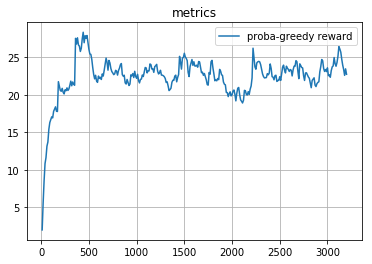

Random session examples


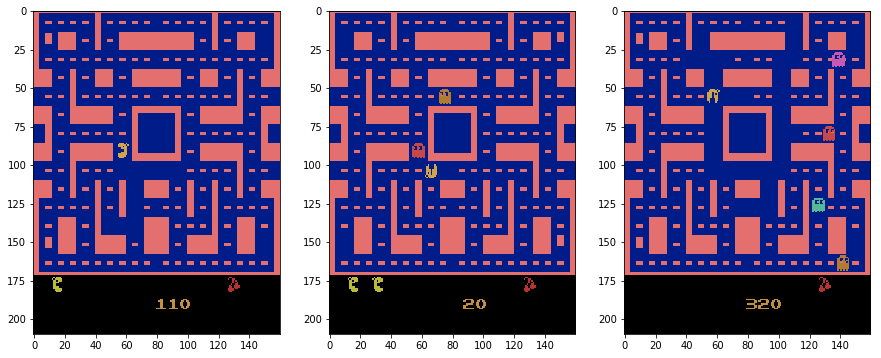

epoch 3210, loss 55.79533, reward 22.95746 
rec 55.069 reg 0.726
epoch 3220, loss 53.36772, reward 23.97421 
rec 52.645 reg 0.723
epoch 3230, loss 55.17265, reward 24.20179 
rec 54.440 reg 0.732
epoch 3240, loss 53.10539, reward 24.46911 
rec 52.365 reg 0.740
epoch 3250, loss 47.40398, reward 23.33470 
rec 46.662 reg 0.742
epoch 3260, loss 46.29855, reward 22.43873 
rec 45.557 reg 0.741
epoch 3270, loss 51.37495, reward 22.50736 
rec 50.636 reg 0.739
epoch 3280, loss 48.16078, reward 21.81912 
rec 47.426 reg 0.734
epoch 3290, loss 50.79758, reward 21.51221 
rec 50.069 reg 0.729
epoch 3300, loss 38.44321, reward 21.23599 
rec 37.720 reg 0.723
Learning curves:


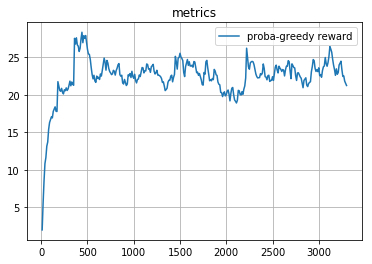

Random session examples


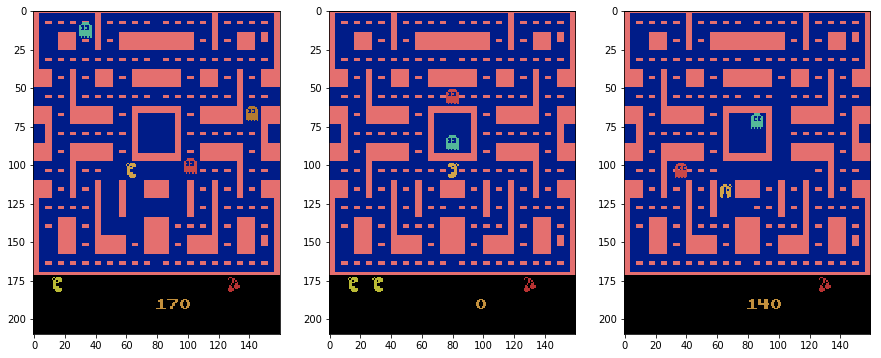

epoch 3310, loss 53.82247, reward 21.79989 
rec 53.104 reg 0.718
epoch 3320, loss 48.50625, reward 21.36990 
rec 47.790 reg 0.716
epoch 3330, loss 41.72291, reward 21.60791 
rec 41.009 reg 0.714
epoch 3340, loss 170.30317, reward 23.50962 
rec 169.592 reg 0.711
epoch 3350, loss 52.52412, reward 23.84616 
rec 51.816 reg 0.708
epoch 3360, loss 50.69832, reward 23.64904 
rec 49.994 reg 0.705
epoch 3370, loss 52.50274, reward 24.03414 
rec 51.804 reg 0.699
epoch 3380, loss 46.40174, reward 23.38072 
rec 45.707 reg 0.694
epoch 3390, loss 53.79503, reward 23.35515 
rec 53.105 reg 0.690
epoch 3400, loss 60.86799, reward 23.70714 
rec 60.183 reg 0.685
Learning curves:


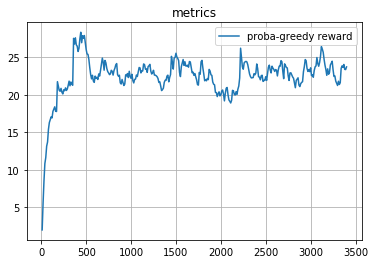

Random session examples


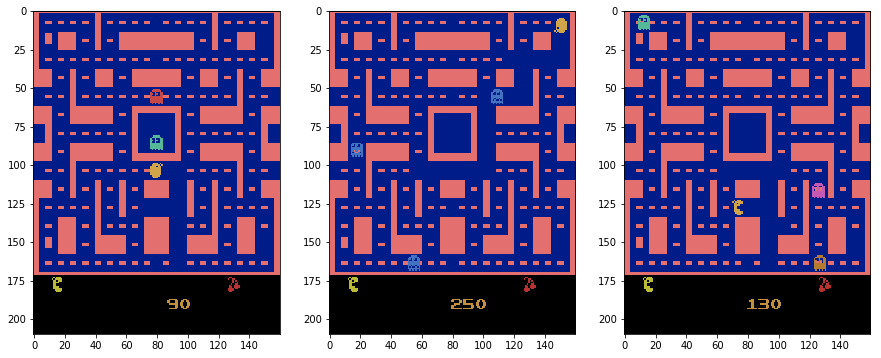

epoch 3410, loss 313.44829, reward 25.83642 
rec 312.764 reg 0.684
epoch 3420, loss 53.52462, reward 25.87778 
rec 52.840 reg 0.685
epoch 3430, loss 48.03920, reward 25.54000 
rec 47.356 reg 0.684
epoch 3440, loss 56.39744, reward 25.73600 
rec 55.717 reg 0.681
epoch 3450, loss 45.04060, reward 25.59990 
rec 44.364 reg 0.677
epoch 3460, loss 46.46211, reward 25.28991 
rec 45.788 reg 0.674
epoch 3470, loss 43.02273, reward 25.26092 
rec 42.349 reg 0.673
epoch 3480, loss 44.89020, reward 24.17233 
rec 44.219 reg 0.671
epoch 3490, loss 48.44773, reward 23.75510 
rec 47.776 reg 0.672
epoch 3500, loss 40.22856, reward 23.19209 
rec 39.557 reg 0.672
Learning curves:


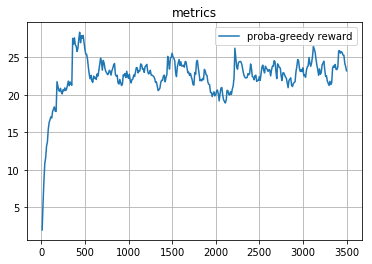

Random session examples


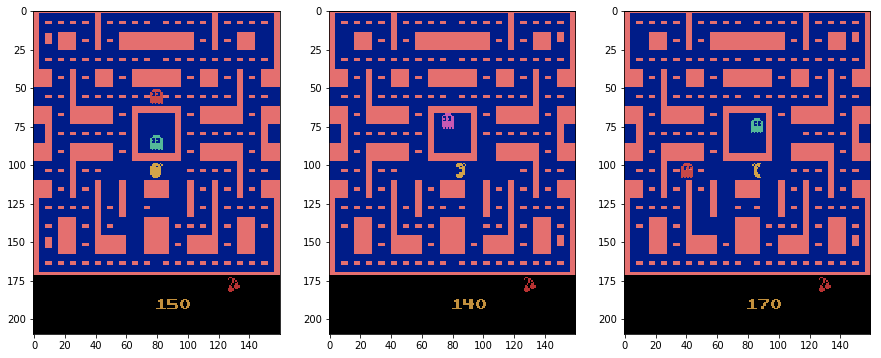

epoch 3510, loss 48.86463, reward 22.74788 
rec 48.195 reg 0.670
epoch 3520, loss 42.86473, reward 22.59809 
rec 42.196 reg 0.669
epoch 3530, loss 50.65113, reward 22.58828 
rec 49.983 reg 0.668
epoch 3540, loss 48.96862, reward 22.32945 
rec 48.302 reg 0.667
epoch 3550, loss 57.26119, reward 22.28401 
rec 56.594 reg 0.667
epoch 3560, loss 45.12248, reward 21.93061 
rec 44.448 reg 0.674
epoch 3570, loss 52.05036, reward 22.61255 
rec 51.375 reg 0.676
epoch 3580, loss 44.89383, reward 22.60129 
rec 44.220 reg 0.674
epoch 3590, loss 47.77863, reward 22.27866 
rec 47.106 reg 0.672
epoch 3600, loss 42.10783, reward 22.05080 
rec 41.439 reg 0.669
Learning curves:


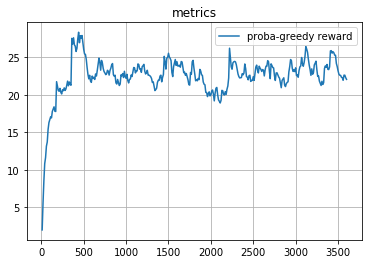

Random session examples


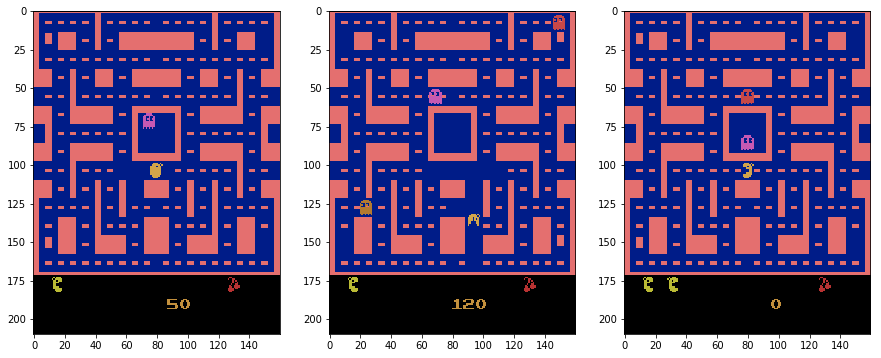

epoch 3610, loss 51.35388, reward 22.72072 
rec 50.689 reg 0.665
epoch 3620, loss 68.44467, reward 23.19864 
rec 67.772 reg 0.673
epoch 3630, loss 112.67439, reward 22.62878 
rec 111.964 reg 0.711
epoch 3640, loss 61.64295, reward 22.86590 
rec 60.897 reg 0.746
epoch 3650, loss 36.87029, reward 22.32931 
rec 36.089 reg 0.782
epoch 3660, loss 44.83365, reward 22.53388 
rec 44.022 reg 0.812
epoch 3670, loss 48.38573, reward 21.84299 
rec 47.561 reg 0.825
epoch 3680, loss 51.33480, reward 21.97119 
rec 50.508 reg 0.827
epoch 3690, loss 49.12397, reward 22.58657 
rec 48.299 reg 0.825
epoch 3700, loss 40.94328, reward 22.26542 
rec 40.123 reg 0.820
Learning curves:


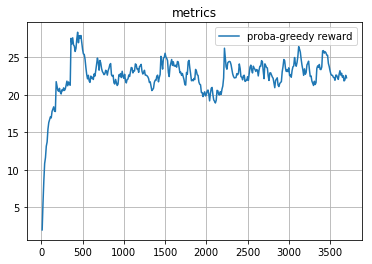

Random session examples


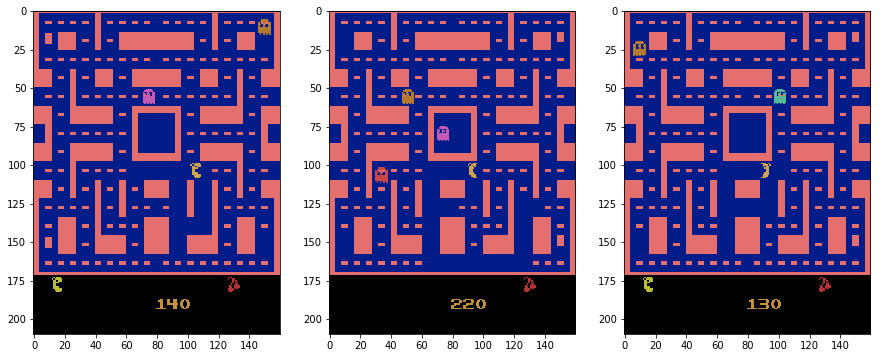

epoch 3710, loss 51.37419, reward 22.22638 
rec 50.559 reg 0.815
epoch 3720, loss 45.17165, reward 21.87874 
rec 44.362 reg 0.810
epoch 3730, loss 51.30698, reward 22.19086 
rec 50.505 reg 0.802
epoch 3740, loss 59.11200, reward 23.59678 
rec 58.318 reg 0.794
epoch 3750, loss 48.78491, reward 23.67460 
rec 47.997 reg 0.788
epoch 3760, loss 60.95742, reward 23.49464 
rec 60.176 reg 0.782
epoch 3770, loss 49.82088, reward 23.20768 
rec 49.044 reg 0.777
epoch 3780, loss 50.95684, reward 22.76191 
rec 50.182 reg 0.775
epoch 3790, loss 44.10124, reward 22.17322 
rec 43.331 reg 0.770
epoch 3800, loss 40.74897, reward 22.58090 
rec 39.985 reg 0.764
Learning curves:


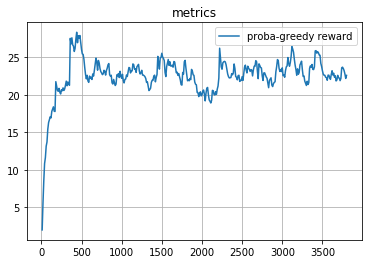

Random session examples


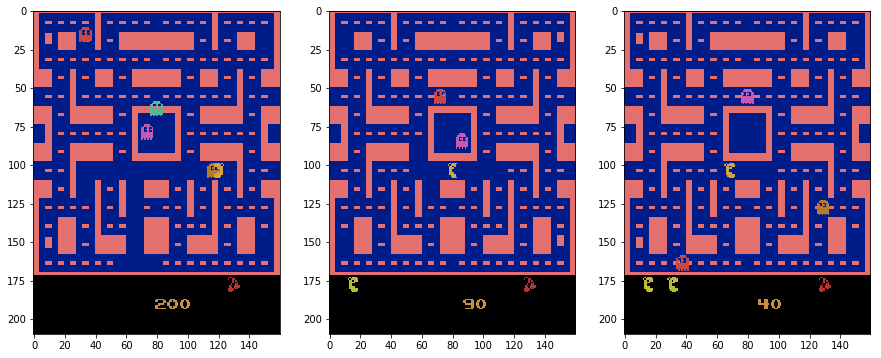

epoch 3810, loss 54.08255, reward 23.19781 
rec 53.321 reg 0.761
epoch 3820, loss 66.11640, reward 23.31553 
rec 65.353 reg 0.764
epoch 3830, loss 59.91667, reward 23.42147 
rec 59.154 reg 0.763
epoch 3840, loss 60.42377, reward 24.01683 
rec 59.664 reg 0.760
epoch 3850, loss 50.25041, reward 23.61514 
rec 49.495 reg 0.756
epoch 3860, loss 49.97077, reward 23.87863 
rec 49.219 reg 0.751
epoch 3870, loss 39.31244, reward 23.30327 
rec 38.566 reg 0.746
epoch 3880, loss 41.85118, reward 23.53544 
rec 41.110 reg 0.741
epoch 3890, loss 45.08541, reward 23.68190 
rec 44.351 reg 0.735
epoch 3900, loss 48.96167, reward 23.50121 
rec 48.233 reg 0.728
Learning curves:


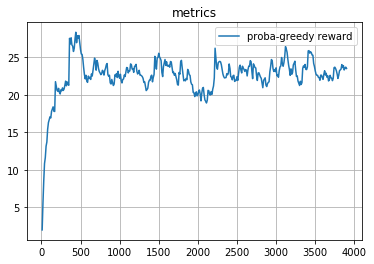

Random session examples


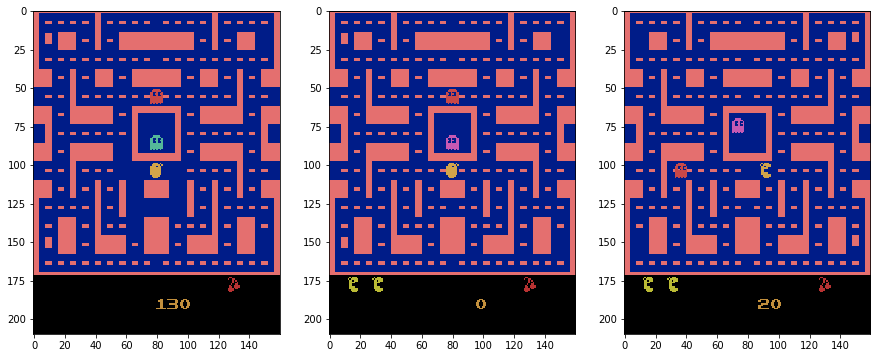

epoch 3910, loss 48.18470, reward 23.33859 
rec 47.462 reg 0.723
epoch 3920, loss 48.05443, reward 23.44223 
rec 47.336 reg 0.718
epoch 3930, loss 42.29861, reward 22.84800 
rec 41.584 reg 0.714
epoch 3940, loss 46.43497, reward 23.12570 
rec 45.724 reg 0.711
epoch 3950, loss 54.18000, reward 23.93813 
rec 53.473 reg 0.707
epoch 3960, loss 71.24700, reward 23.29432 
rec 70.535 reg 0.712
epoch 3970, loss 62.51620, reward 23.52739 
rec 61.798 reg 0.718
epoch 3980, loss 53.27411, reward 23.54965 
rec 52.552 reg 0.722
epoch 3990, loss 50.74086, reward 23.06968 
rec 50.017 reg 0.724
epoch 4000, loss 50.22264, reward 23.38772 
rec 49.500 reg 0.722
Learning curves:


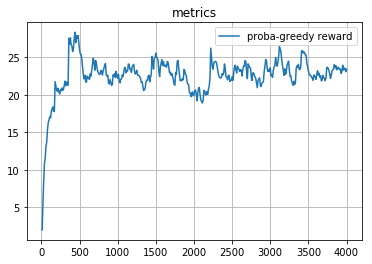

Random session examples


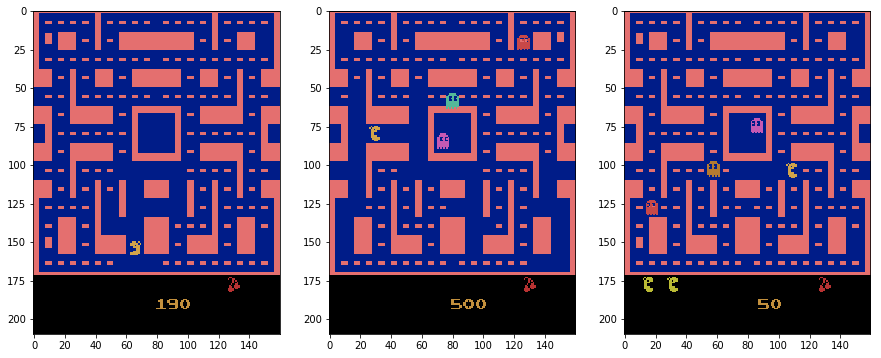

[2017-05-24 02:51:06,486] Making new env: MsPacman-v0
[2017-05-24 02:51:06,747] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 02:51:06,756] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.3.6612.video000000.mp4
[2017-05-24 02:51:08,059] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.3.6612.video000001.mp4


Episode finished after 586 timesteps, rw = 260.0
Episode finished after 520 timesteps, rw = 150.0
Episode finished after 636 timesteps, rw = 150.0
Episode finished after 831 timesteps, rw = 480.0
Episode finished after 553 timesteps, rw = 110.0
Episode finished after 667 timesteps, rw = 230.0
Episode finished after 665 timesteps, rw = 240.0


[2017-05-24 02:51:15,177] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.3.6612.video000008.mp4


Episode finished after 672 timesteps, rw = 230.0
Episode finished after 611 timesteps, rw = 230.0
Episode finished after 678 timesteps, rw = 170.0
Episode finished after 708 timesteps, rw = 240.0
Episode finished after 576 timesteps, rw = 220.0
Episode finished after 648 timesteps, rw = 200.0
Episode finished after 639 timesteps, rw = 180.0
Episode finished after 644 timesteps, rw = 170.0
Episode finished after 725 timesteps, rw = 320.0
Episode finished after 595 timesteps, rw = 220.0
Episode finished after 680 timesteps, rw = 170.0
Episode finished after 520 timesteps, rw = 200.0


[2017-05-24 02:51:26,488] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/proba_videos')


Episode finished after 480 timesteps, rw = 150.0
Mean 216.0, Var 5834.0
epoch 4010, loss 42.85450, reward 23.11144 
rec 42.134 reg 0.720
epoch 4020, loss 36.00109, reward 23.05030 
rec 35.283 reg 0.718
epoch 4030, loss 49.37237, reward 23.05777 
rec 48.655 reg 0.718
epoch 4040, loss 45.94625, reward 23.25199 
rec 45.231 reg 0.715
epoch 4050, loss 54.65733, reward 22.48929 
rec 53.944 reg 0.713
epoch 4060, loss 37.78711, reward 21.36536 
rec 37.076 reg 0.711
epoch 4070, loss 42.34741, reward 21.29133 
rec 41.638 reg 0.709
epoch 4080, loss 49.71489, reward 20.97470 
rec 49.009 reg 0.706
epoch 4090, loss 46.95381, reward 20.50223 
rec 46.252 reg 0.701
epoch 4100, loss 43.42205, reward 20.63950 
rec 42.726 reg 0.696
Learning curves:


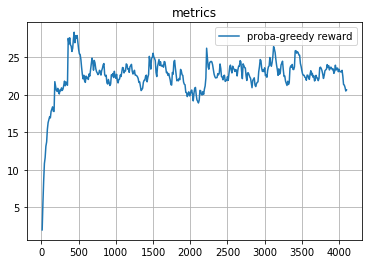

Random session examples


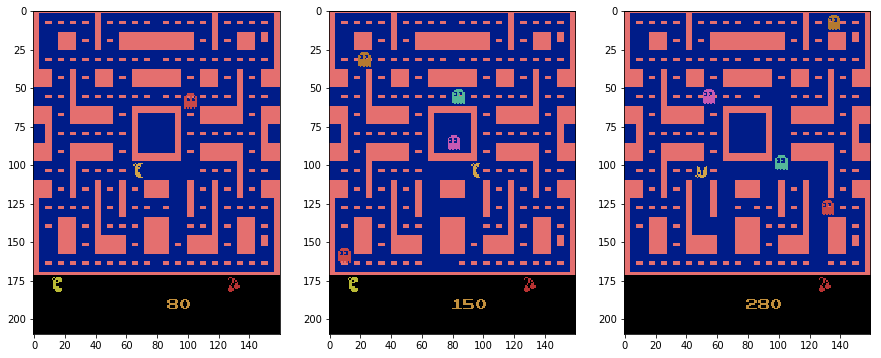

epoch 4110, loss 39.26067, reward 20.51305 
rec 38.569 reg 0.691
epoch 4120, loss 52.53228, reward 20.46175 
rec 51.845 reg 0.687
epoch 4130, loss 50.52484, reward 20.97807 
rec 49.843 reg 0.682
epoch 4140, loss 282.54211, reward 23.00527 
rec 281.865 reg 0.678
epoch 4150, loss 53.97005, reward 23.39224 
rec 53.291 reg 0.679
epoch 4160, loss 49.17097, reward 23.42801 
rec 48.494 reg 0.677
epoch 4170, loss 54.50212, reward 23.39771 
rec 53.828 reg 0.674
epoch 4180, loss 53.55278, reward 24.12044 
rec 52.880 reg 0.672
epoch 4190, loss 49.42601, reward 23.58340 
rec 48.756 reg 0.670
epoch 4200, loss 50.10750, reward 23.72506 
rec 49.440 reg 0.668
Learning curves:


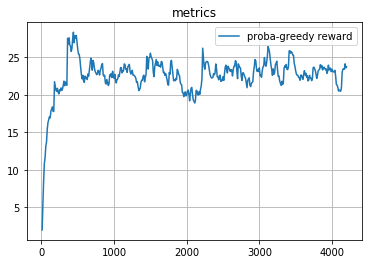

Random session examples


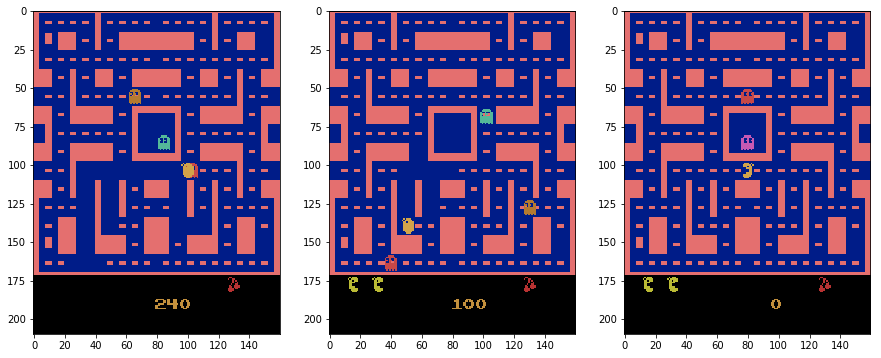

epoch 4210, loss 55.20751, reward 23.85255 
rec 54.540 reg 0.668
epoch 4220, loss 50.19205, reward 23.96730 
rec 49.526 reg 0.666
epoch 4230, loss 47.33188, reward 23.38307 
rec 46.669 reg 0.663
epoch 4240, loss 47.41875, reward 22.85726 
rec 46.759 reg 0.660
epoch 4250, loss 50.79814, reward 23.07153 
rec 50.142 reg 0.656
epoch 4260, loss 52.71515, reward 22.95188 
rec 52.063 reg 0.652
epoch 4270, loss 45.50585, reward 22.53169 
rec 44.857 reg 0.649
epoch 4280, loss 126.40793, reward 23.84102 
rec 125.761 reg 0.647
epoch 4290, loss 50.66678, reward 23.83192 
rec 50.017 reg 0.650
epoch 4300, loss 129.91999, reward 24.88623 
rec 129.270 reg 0.650
Learning curves:


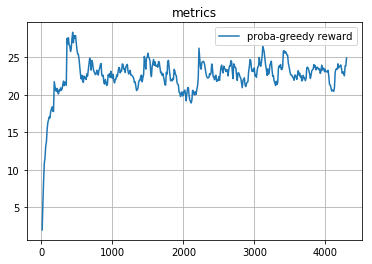

Random session examples


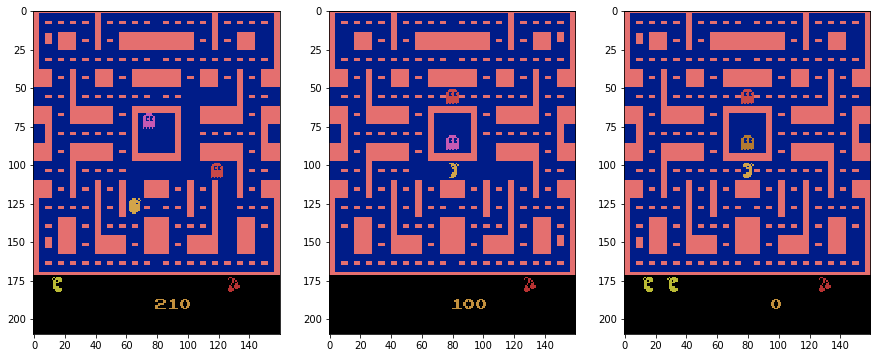

epoch 4310, loss 41.01440, reward 24.02261 
rec 40.364 reg 0.651
epoch 4320, loss 50.51128, reward 23.68285 
rec 49.856 reg 0.655
epoch 4330, loss 53.68126, reward 23.75206 
rec 53.024 reg 0.657
epoch 4340, loss 57.92896, reward 24.06435 
rec 57.271 reg 0.658
epoch 4350, loss 809.72969, reward 27.78292 
rec 809.070 reg 0.659
epoch 4360, loss 66.16567, reward 28.87963 
rec 65.501 reg 0.664
epoch 4370, loss 47.32898, reward 27.67916 
rec 46.666 reg 0.663
epoch 4380, loss 54.34402, reward 27.41125 
rec 53.682 reg 0.662
epoch 4390, loss 50.15983, reward 26.73262 
rec 49.497 reg 0.663
epoch 4400, loss 47.34980, reward 26.18436 
rec 46.690 reg 0.660
Learning curves:


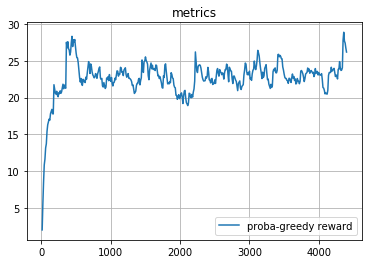

Random session examples


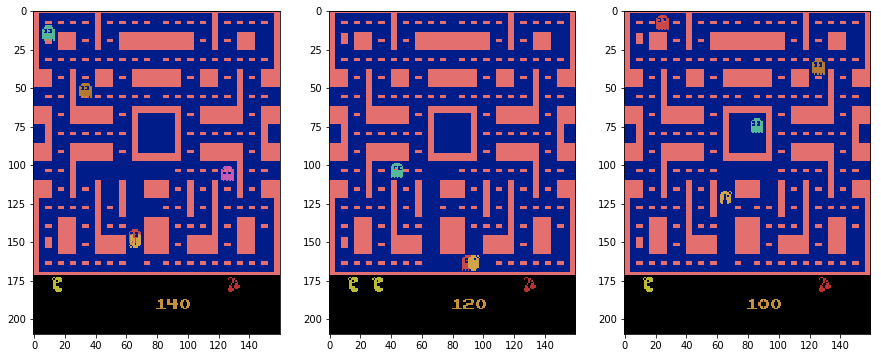

epoch 4410, loss 45.64569, reward 25.94093 
rec 44.985 reg 0.661
epoch 4420, loss 41.03884, reward 25.40933 
rec 40.358 reg 0.681
epoch 4430, loss 48.85769, reward 25.43090 
rec 48.156 reg 0.701
epoch 4440, loss 48.15345, reward 24.88781 
rec 47.444 reg 0.710
epoch 4450, loss 51.02799, reward 25.02403 
rec 50.317 reg 0.711
epoch 4460, loss 51.07940, reward 24.70913 
rec 50.371 reg 0.708
epoch 4470, loss 57.19593, reward 24.61321 
rec 56.490 reg 0.706
epoch 4480, loss 71.31546, reward 25.15189 
rec 70.607 reg 0.709
epoch 4490, loss 58.57405, reward 25.44920 
rec 57.867 reg 0.707
epoch 4500, loss 54.91005, reward 25.27928 
rec 54.206 reg 0.704
Learning curves:


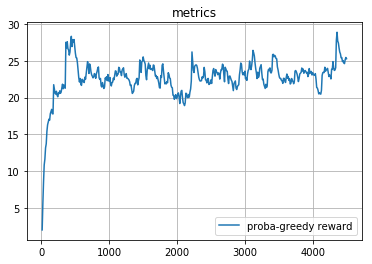

Random session examples


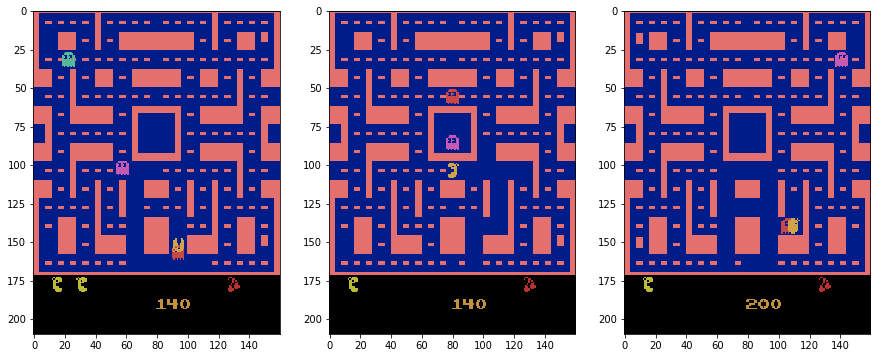

epoch 4510, loss 37.59591, reward 24.43885 
rec 36.894 reg 0.701
epoch 4520, loss 46.02973, reward 23.80747 
rec 45.332 reg 0.698
epoch 4530, loss 55.56512, reward 24.11422 
rec 54.871 reg 0.694
epoch 4540, loss 45.38600, reward 23.95280 
rec 44.693 reg 0.693
epoch 4550, loss 46.73638, reward 23.05752 
rec 46.042 reg 0.695
epoch 4560, loss 52.79401, reward 23.12677 
rec 52.096 reg 0.698
epoch 4570, loss 52.69037, reward 22.50159 
rec 51.992 reg 0.699
epoch 4580, loss 67.51122, reward 23.06393 
rec 66.813 reg 0.698
epoch 4590, loss 75.95387, reward 24.75754 
rec 75.260 reg 0.694
epoch 4600, loss 59.19076, reward 25.34428 
rec 58.498 reg 0.693
Learning curves:


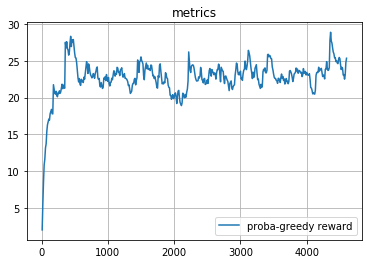

Random session examples


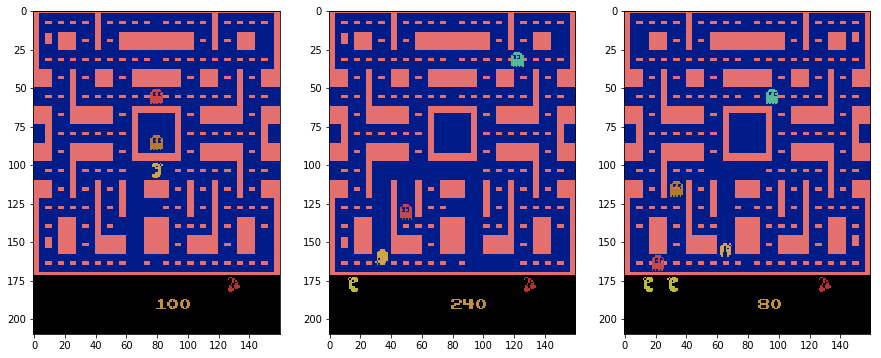

epoch 4610, loss 52.17806, reward 25.18486 
rec 51.482 reg 0.696
epoch 4620, loss 393.49172, reward 27.35387 
rec 392.793 reg 0.699
epoch 4630, loss 56.41769, reward 25.99348 
rec 55.717 reg 0.701
epoch 4640, loss 50.81608, reward 25.51914 
rec 50.113 reg 0.703
epoch 4650, loss 42.90276, reward 24.46722 
rec 42.200 reg 0.703
epoch 4660, loss 47.07972, reward 24.39550 
rec 46.377 reg 0.702
epoch 4670, loss 46.50577, reward 23.83095 
rec 45.806 reg 0.700
epoch 4680, loss 40.74298, reward 23.76035 
rec 40.045 reg 0.698
epoch 4690, loss 60.38849, reward 24.38432 
rec 59.693 reg 0.696
epoch 4700, loss 54.34120, reward 24.25839 
rec 53.648 reg 0.693
Learning curves:


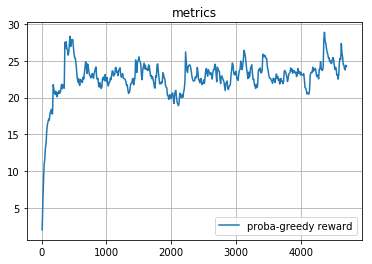

Random session examples


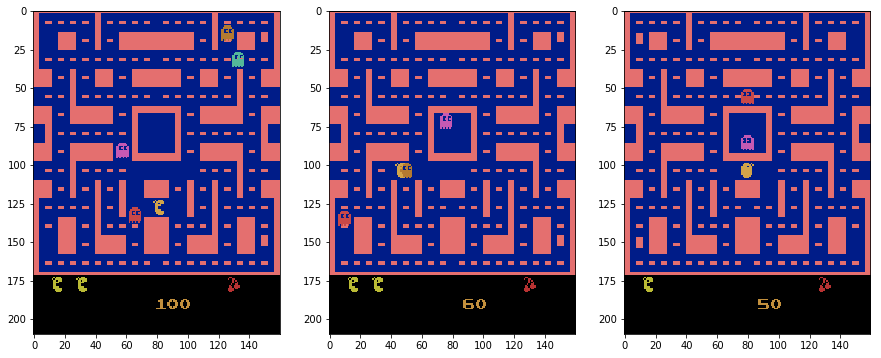

epoch 4710, loss 212.99958, reward 26.33255 
rec 212.310 reg 0.690
epoch 4720, loss 39.00301, reward 24.88679 
rec 38.315 reg 0.688
epoch 4730, loss 49.04453, reward 24.96061 
rec 48.360 reg 0.685
epoch 4740, loss 60.87033, reward 25.77705 
rec 60.188 reg 0.683
epoch 4750, loss 46.72879, reward 25.01185 
rec 46.047 reg 0.682
epoch 4760, loss 48.56439, reward 25.13566 
rec 47.884 reg 0.680
epoch 4770, loss 52.06597, reward 25.37210 
rec 51.388 reg 0.678
epoch 4780, loss 58.00109, reward 25.27239 
rec 57.324 reg 0.677
epoch 4790, loss 49.14117, reward 25.05765 
rec 48.467 reg 0.674
epoch 4800, loss 48.22280, reward 25.30188 
rec 47.552 reg 0.671
Learning curves:


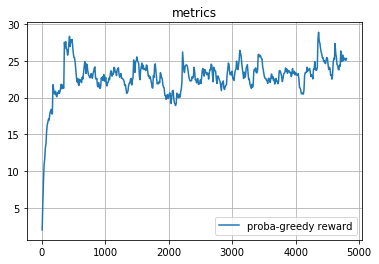

Random session examples


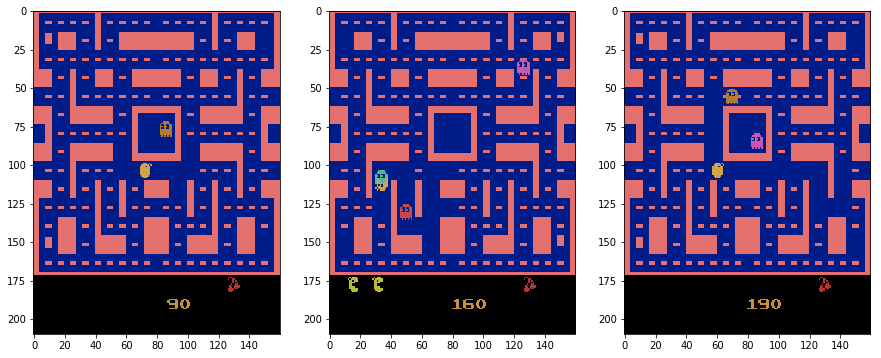

epoch 4810, loss 45.36053, reward 25.14670 
rec 44.692 reg 0.669
epoch 4820, loss 50.41376, reward 24.06953 
rec 49.742 reg 0.672
epoch 4830, loss 87.91076, reward 23.72507 
rec 87.228 reg 0.682
epoch 4840, loss 83.80452, reward 25.22757 
rec 83.114 reg 0.691
epoch 4850, loss 59.02372, reward 24.64231 
rec 58.326 reg 0.697
epoch 4860, loss 90.49996, reward 24.24058 
rec 89.781 reg 0.719
epoch 4870, loss 81.75185, reward 24.31652 
rec 80.998 reg 0.753
epoch 4880, loss 64.85603, reward 24.44737 
rec 64.082 reg 0.774
epoch 4890, loss 42.08893, reward 24.00263 
rec 41.299 reg 0.790
epoch 4900, loss 34.92206, reward 23.47737 
rec 34.120 reg 0.803
Learning curves:


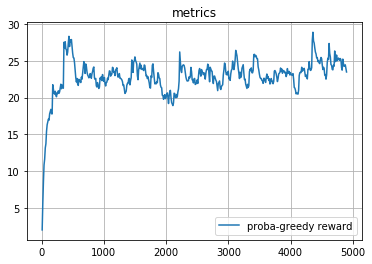

Random session examples


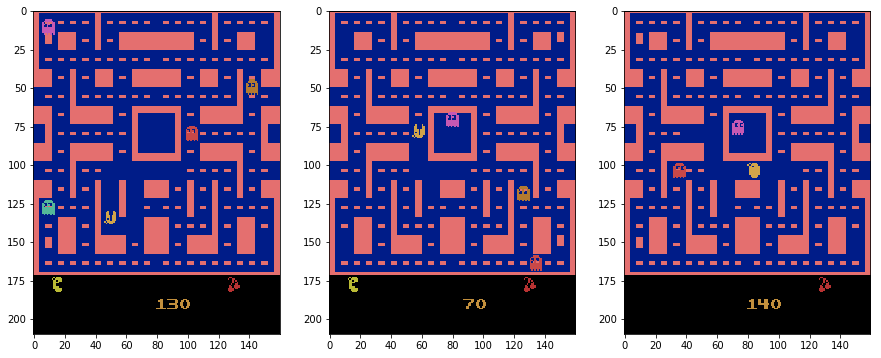

epoch 4910, loss 43.53410, reward 23.69213 
rec 42.724 reg 0.811
epoch 4920, loss 45.88713, reward 23.63542 
rec 45.072 reg 0.815
epoch 4930, loss 52.01157, reward 24.20938 
rec 51.193 reg 0.819
epoch 4940, loss 46.87995, reward 23.78844 
rec 46.056 reg 0.824
epoch 4950, loss 45.70501, reward 24.22209 
rec 44.878 reg 0.827
epoch 4960, loss 50.17355, reward 23.92489 
rec 49.347 reg 0.827
epoch 4970, loss 45.09088, reward 23.53240 
rec 44.265 reg 0.826
epoch 4980, loss 45.03291, reward 22.67916 
rec 44.206 reg 0.827
epoch 4990, loss 62.04403, reward 22.41124 
rec 61.209 reg 0.835
epoch 5000, loss 44.59791, reward 21.98262 
rec 43.763 reg 0.835
Learning curves:


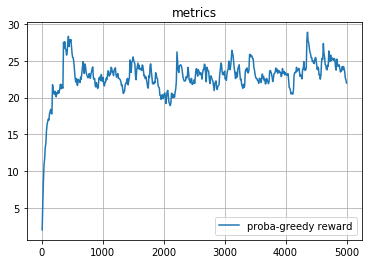

Random session examples


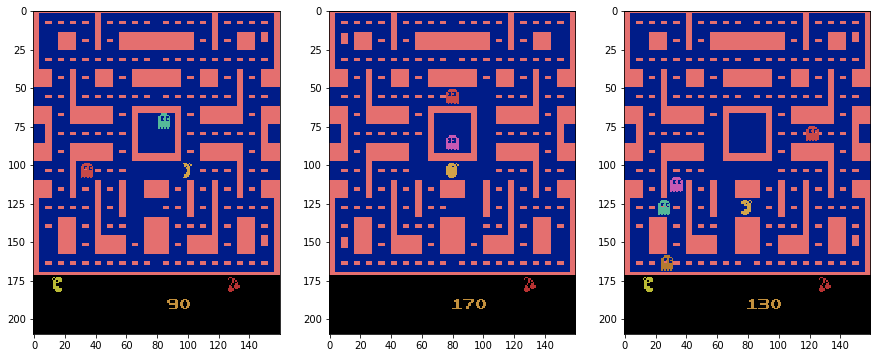

[2017-05-24 03:13:03,389] Making new env: MsPacman-v0
[2017-05-24 03:13:03,563] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 03:13:03,577] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.4.6612.video000000.mp4
[2017-05-24 03:13:05,184] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.4.6612.video000001.mp4


Episode finished after 780 timesteps, rw = 510.0
Episode finished after 685 timesteps, rw = 200.0
Episode finished after 630 timesteps, rw = 240.0
Episode finished after 519 timesteps, rw = 50.0
Episode finished after 689 timesteps, rw = 140.0
Episode finished after 509 timesteps, rw = 130.0
Episode finished after 739 timesteps, rw = 250.0


[2017-05-24 03:13:12,293] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.4.6612.video000008.mp4


Episode finished after 591 timesteps, rw = 300.0
Episode finished after 621 timesteps, rw = 170.0
Episode finished after 689 timesteps, rw = 250.0
Episode finished after 523 timesteps, rw = 150.0
Episode finished after 652 timesteps, rw = 140.0
Episode finished after 942 timesteps, rw = 390.0
Episode finished after 636 timesteps, rw = 170.0
Episode finished after 669 timesteps, rw = 160.0
Episode finished after 600 timesteps, rw = 240.0
Episode finished after 708 timesteps, rw = 220.0
Episode finished after 755 timesteps, rw = 240.0
Episode finished after 644 timesteps, rw = 110.0


[2017-05-24 03:13:25,105] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/proba_videos')


Episode finished after 626 timesteps, rw = 230.0
Mean 214.5, Var 9884.75
epoch 5010, loss 43.29598, reward 21.84686 
rec 42.467 reg 0.829
epoch 5020, loss 43.92205, reward 21.53717 
rec 43.095 reg 0.827
epoch 5030, loss 44.56015, reward 21.25845 
rec 43.738 reg 0.822
epoch 5040, loss 50.86333, reward 21.94511 
rec 50.047 reg 0.816
epoch 5050, loss 57.21795, reward 23.37560 
rec 56.408 reg 0.810
epoch 5060, loss 42.61731, reward 23.10054 
rec 41.815 reg 0.802
epoch 5070, loss 44.71145, reward 22.54048 
rec 43.914 reg 0.797
epoch 5080, loss 44.83085, reward 21.78644 
rec 44.039 reg 0.792
epoch 5090, loss 47.77558, reward 22.35779 
rec 46.991 reg 0.784
epoch 5100, loss 36.51669, reward 21.62201 
rec 35.739 reg 0.778
Learning curves:


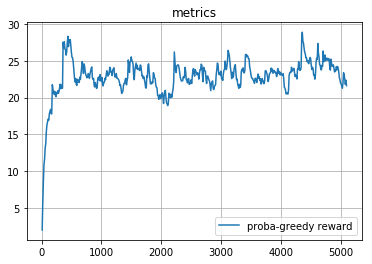

Random session examples


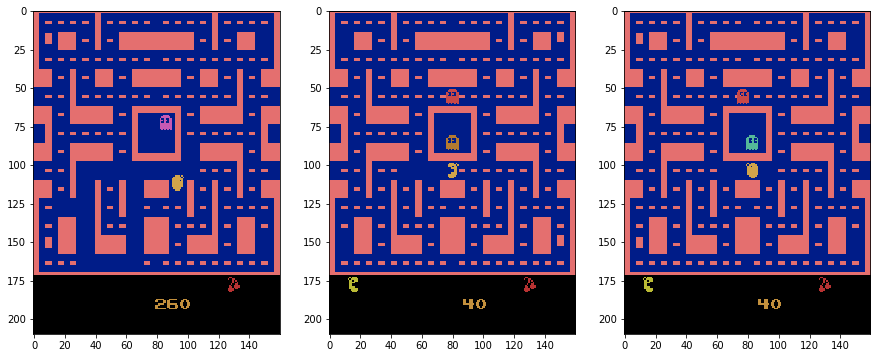

epoch 5110, loss 50.55277, reward 21.33481 
rec 49.780 reg 0.772
epoch 5120, loss 57.52367, reward 20.88883 
rec 56.754 reg 0.769
epoch 5130, loss 66.22004, reward 21.73745 
rec 65.450 reg 0.770
epoch 5140, loss 47.15342, reward 20.93870 
rec 46.387 reg 0.767
epoch 5150, loss 67.55342, reward 22.40733 
rec 66.792 reg 0.762
epoch 5160, loss 41.83046, reward 21.72910 
rec 41.072 reg 0.758
epoch 5170, loss 45.56829, reward 21.49369 
rec 44.813 reg 0.755
epoch 5180, loss 48.85787, reward 21.78182 
rec 48.106 reg 0.752
epoch 5190, loss 38.29084, reward 20.97864 
rec 37.543 reg 0.748
epoch 5200, loss 39.24171, reward 20.44327 
rec 38.498 reg 0.744
Learning curves:


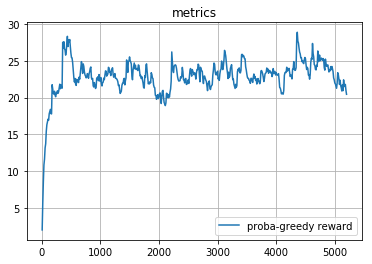

Random session examples


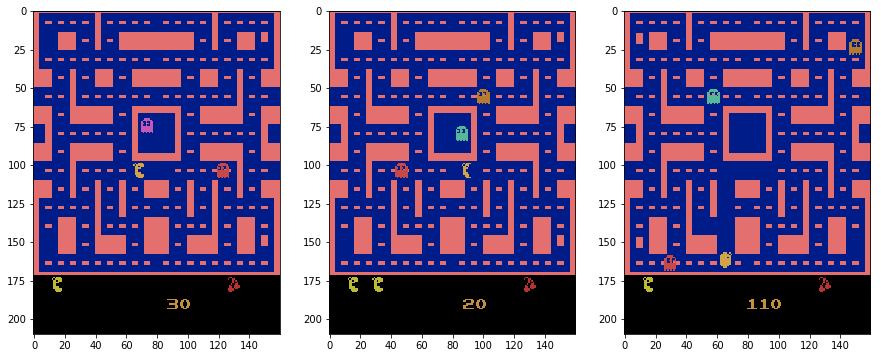

epoch 5210, loss 34.60230, reward 19.39895 
rec 33.863 reg 0.739
epoch 5220, loss 46.68499, reward 20.02155 
rec 45.951 reg 0.734
epoch 5230, loss 163.43438, reward 21.26940 
rec 162.704 reg 0.730
epoch 5240, loss 47.87113, reward 20.76746 
rec 47.144 reg 0.727
epoch 5250, loss 57.20526, reward 20.69071 
rec 56.482 reg 0.724
epoch 5260, loss 47.28743, reward 20.49664 
rec 46.568 reg 0.720
epoch 5270, loss 43.71913, reward 21.19698 
rec 43.003 reg 0.716
epoch 5280, loss 46.99630, reward 20.82728 
rec 46.282 reg 0.714
epoch 5290, loss 29.05006, reward 19.99455 
rec 28.338 reg 0.712
epoch 5300, loss 70.52594, reward 20.55760 
rec 69.815 reg 0.711
Learning curves:


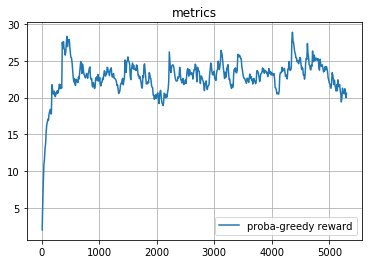

Random session examples


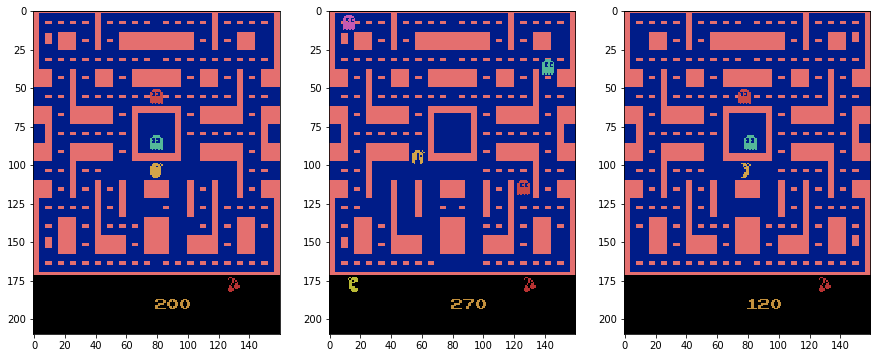

epoch 5310, loss 53.13605, reward 20.93934 
rec 52.426 reg 0.710
epoch 5320, loss 40.37503, reward 20.59540 
rec 39.664 reg 0.711
epoch 5330, loss 343.94515, reward 23.03586 
rec 343.233 reg 0.712
epoch 5340, loss 63.74583, reward 23.73228 
rec 63.034 reg 0.712
epoch 5350, loss 54.03172, reward 23.79655 
rec 53.320 reg 0.712
epoch 5360, loss 58.89753, reward 24.29189 
rec 58.189 reg 0.708
epoch 5370, loss 55.67472, reward 24.80020 
rec 54.969 reg 0.705
epoch 5380, loss 49.14748, reward 25.38268 
rec 48.441 reg 0.706
epoch 5390, loss 60.46961, reward 25.78192 
rec 59.766 reg 0.704
epoch 5400, loss 46.47353, reward 25.95372 
rec 45.775 reg 0.699
Learning curves:


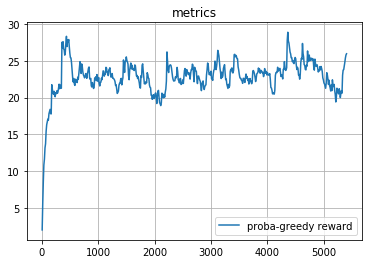

Random session examples


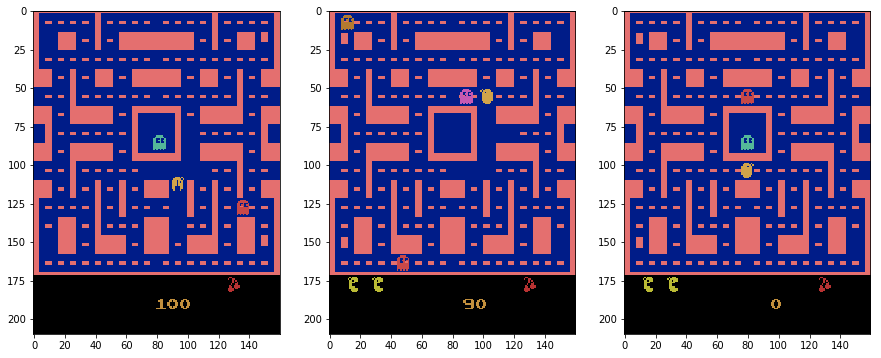

epoch 5410, loss 56.34397, reward 26.04585 
rec 55.650 reg 0.694
epoch 5420, loss 45.82087, reward 25.50377 
rec 45.131 reg 0.689
epoch 5430, loss 46.41235, reward 25.07839 
rec 45.729 reg 0.684
epoch 5440, loss 46.64573, reward 24.57055 
rec 45.967 reg 0.679
epoch 5450, loss 49.55784, reward 24.67600 
rec 48.883 reg 0.675
epoch 5460, loss 58.94421, reward 24.95840 
rec 58.272 reg 0.673
epoch 5470, loss 51.11740, reward 24.40006 
rec 50.448 reg 0.670
epoch 5480, loss 43.83211, reward 24.64755 
rec 43.166 reg 0.666
epoch 5490, loss 52.08602, reward 24.80780 
rec 51.418 reg 0.668
epoch 5500, loss 59.95442, reward 24.57702 
rec 59.279 reg 0.675
Learning curves:


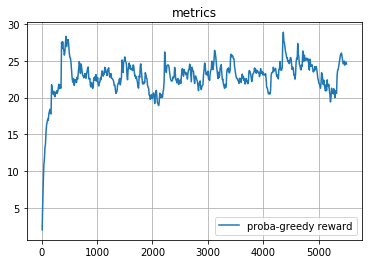

Random session examples


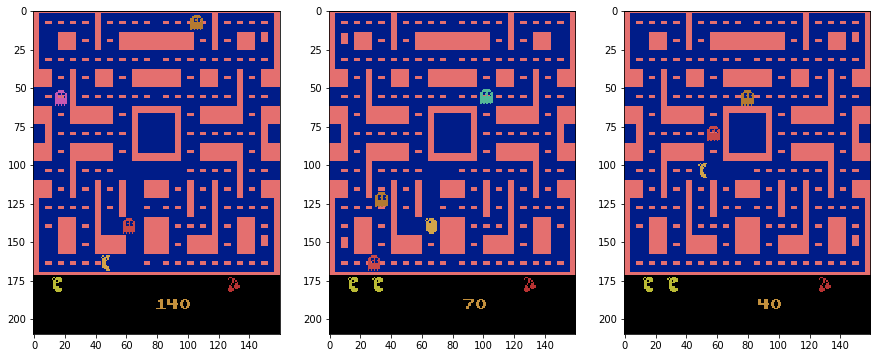

epoch 5510, loss 63.10472, reward 24.43181 
rec 62.429 reg 0.676
epoch 5520, loss 199.71328, reward 25.61363 
rec 199.037 reg 0.676
epoch 5530, loss 45.35089, reward 24.86477 
rec 44.672 reg 0.679
epoch 5540, loss 46.76546, reward 23.94079 
rec 46.083 reg 0.682
epoch 5550, loss 52.46974, reward 23.35921 
rec 51.784 reg 0.686
epoch 5560, loss 59.01672, reward 23.77329 
rec 58.332 reg 0.685
epoch 5570, loss 68.81776, reward 24.02096 
rec 68.136 reg 0.682
epoch 5580, loss 45.98399, reward 23.11887 
rec 45.304 reg 0.680
epoch 5590, loss 42.69019, reward 22.43198 
rec 42.015 reg 0.676
epoch 5600, loss 44.09804, reward 21.43878 
rec 43.427 reg 0.671
Learning curves:


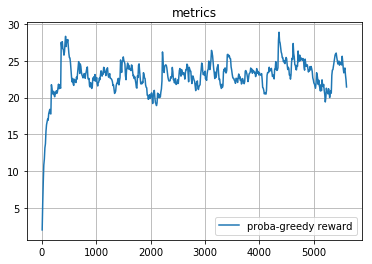

Random session examples


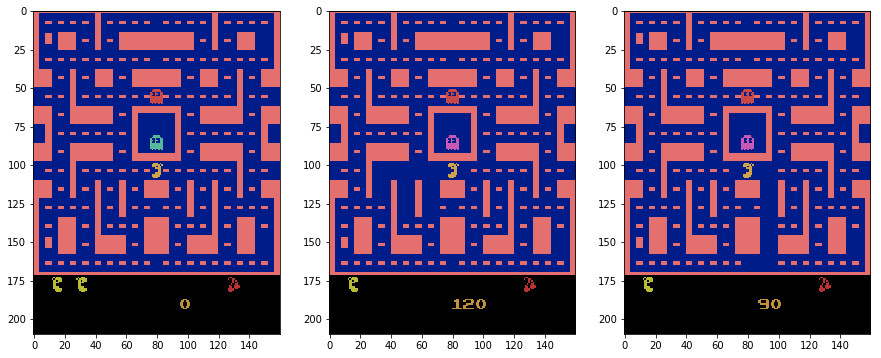

epoch 5610, loss 51.10849, reward 21.98240 
rec 50.440 reg 0.668
epoch 5620, loss 41.96991, reward 21.72166 
rec 41.304 reg 0.666
epoch 5630, loss 45.68271, reward 22.54950 
rec 45.019 reg 0.663
epoch 5640, loss 43.72198, reward 22.10705 
rec 43.062 reg 0.660
epoch 5650, loss 54.14096, reward 22.33384 
rec 53.485 reg 0.656
epoch 5660, loss 55.42557, reward 22.16296 
rec 54.771 reg 0.655
epoch 5670, loss 59.77876, reward 22.69666 
rec 59.125 reg 0.654
epoch 5680, loss 48.04240, reward 22.42700 
rec 47.389 reg 0.653
epoch 5690, loss 57.27432, reward 22.74680 
rec 56.623 reg 0.652
epoch 5700, loss 42.87141, reward 21.40962 
rec 42.221 reg 0.651
Learning curves:


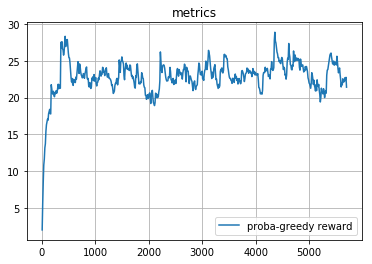

Random session examples


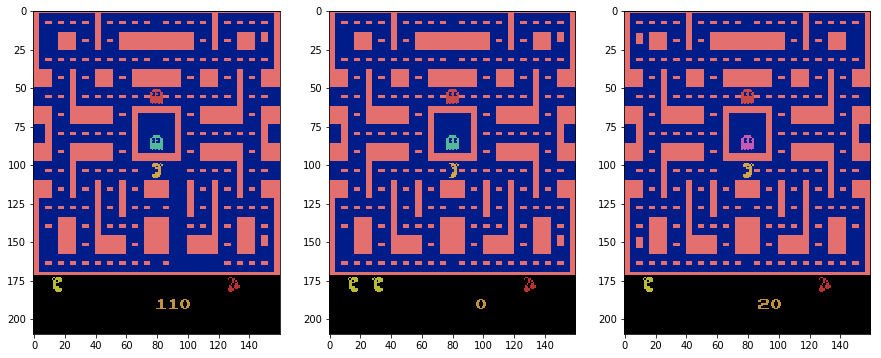

epoch 5710, loss 51.55332, reward 21.58116 
rec 50.904 reg 0.649
epoch 5720, loss 34.23176, reward 21.11054 
rec 33.585 reg 0.646
epoch 5730, loss 47.43839, reward 20.99949 
rec 46.795 reg 0.643
epoch 5740, loss 54.51060, reward 20.52454 
rec 53.867 reg 0.644
epoch 5750, loss 60.95525, reward 20.90958 
rec 60.312 reg 0.644
epoch 6050, loss 64.47189, reward 23.45232 
rec 63.835 reg 0.637
epoch 6060, loss 61.41323, reward 24.04459 
rec 60.771 reg 0.642
epoch 6070, loss 55.72489, reward 24.07763 
rec 55.080 reg 0.645
epoch 6080, loss 54.17151, reward 24.48237 
rec 53.526 reg 0.645
epoch 6090, loss 50.33006, reward 24.15913 
rec 49.686 reg 0.644
epoch 6100, loss 53.86016, reward 24.05572 
rec 53.217 reg 0.643
Learning curves:


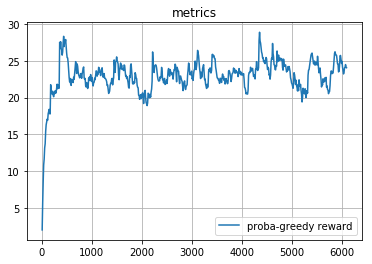

Random session examples


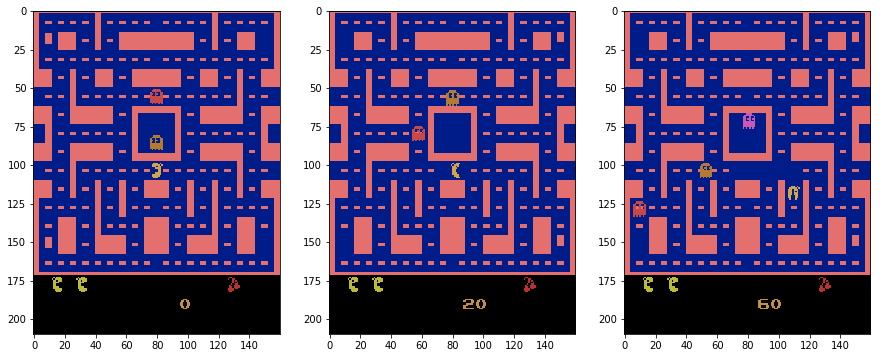

epoch 6110, loss 54.21299, reward 24.90015 
rec 53.572 reg 0.641
epoch 6120, loss 41.97299, reward 24.16013 
rec 41.334 reg 0.639
epoch 6130, loss 64.48348, reward 24.61912 
rec 63.840 reg 0.644
epoch 6140, loss 51.83597, reward 24.21971 
rec 51.179 reg 0.657
epoch 6150, loss 63.19527, reward 24.17274 
rec 62.534 reg 0.661
epoch 6160, loss 40.04347, reward 24.13046 
rec 39.382 reg 0.661
epoch 6170, loss 47.54229, reward 24.46742 
rec 46.884 reg 0.659
epoch 6180, loss 44.36128, reward 23.20817 
rec 43.707 reg 0.655
epoch 6190, loss 47.94735, reward 22.69986 
rec 47.296 reg 0.651
epoch 6200, loss 63.67949, reward 23.86737 
rec 63.033 reg 0.647
Learning curves:


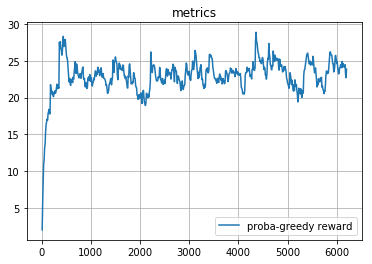

Random session examples


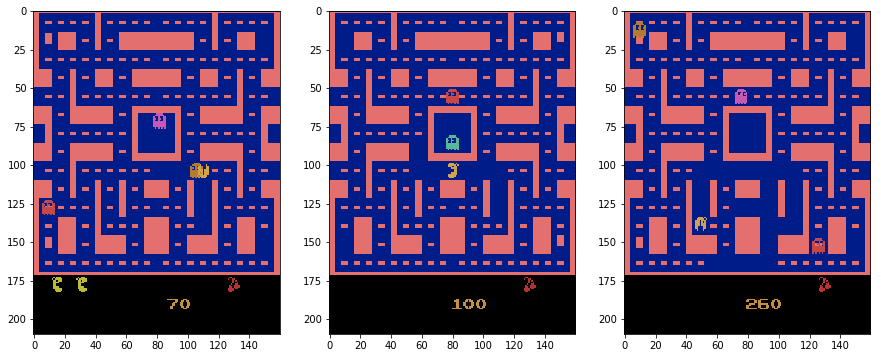

epoch 6210, loss 59.06061, reward 24.10563 
rec 58.414 reg 0.646
epoch 6220, loss 63.33401, reward 24.25757 
rec 62.687 reg 0.647
epoch 6230, loss 51.17463, reward 24.01931 
rec 50.531 reg 0.644
epoch 6240, loss 48.00017, reward 24.36738 
rec 47.358 reg 0.643
epoch 6250, loss 43.72276, reward 23.43064 
rec 43.077 reg 0.646
epoch 6260, loss 50.39786, reward 23.33758 
rec 49.746 reg 0.652
epoch 6270, loss 63.68007, reward 24.75382 
rec 63.025 reg 0.655
epoch 6280, loss 52.36416, reward 25.15344 
rec 51.711 reg 0.654
epoch 6290, loss 38.58759, reward 24.26310 
rec 37.939 reg 0.649
epoch 6300, loss 40.62376, reward 24.39929 
rec 39.979 reg 0.645
Learning curves:


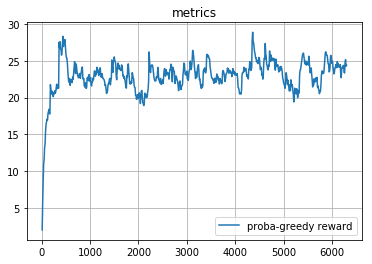

Random session examples


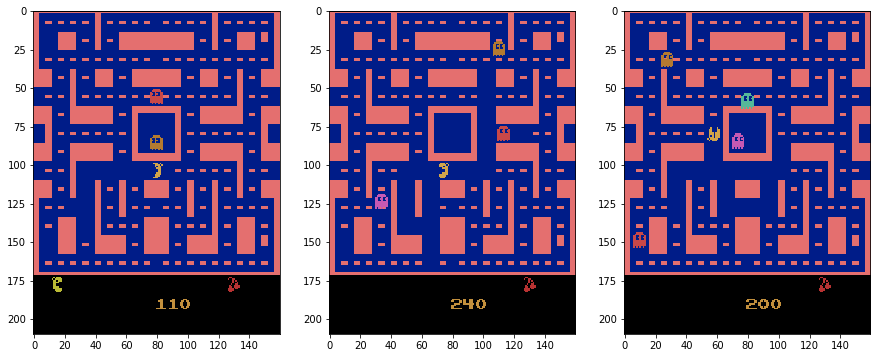

epoch 6310, loss 58.71888, reward 25.14686 
rec 58.077 reg 0.642
epoch 6320, loss 55.67648, reward 24.94467 
rec 55.037 reg 0.639
epoch 6330, loss 71.22625, reward 25.82520 
rec 70.589 reg 0.637
epoch 6340, loss 46.78740, reward 25.24268 
rec 46.153 reg 0.635
epoch 6350, loss 70.65579, reward 25.96842 
rec 70.019 reg 0.637
epoch 6360, loss 47.14945, reward 25.12157 
rec 46.503 reg 0.646
epoch 6370, loss 79.11645, reward 25.92192 
rec 78.465 reg 0.652
epoch 6380, loss 63.43580, reward 26.39222 
rec 62.782 reg 0.654
epoch 6390, loss 41.10777, reward 25.69050 
rec 40.447 reg 0.661
epoch 6400, loss 39.86080, reward 24.62145 
rec 39.190 reg 0.671
Learning curves:


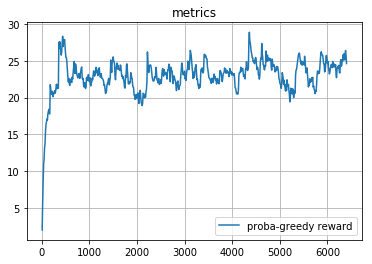

Random session examples


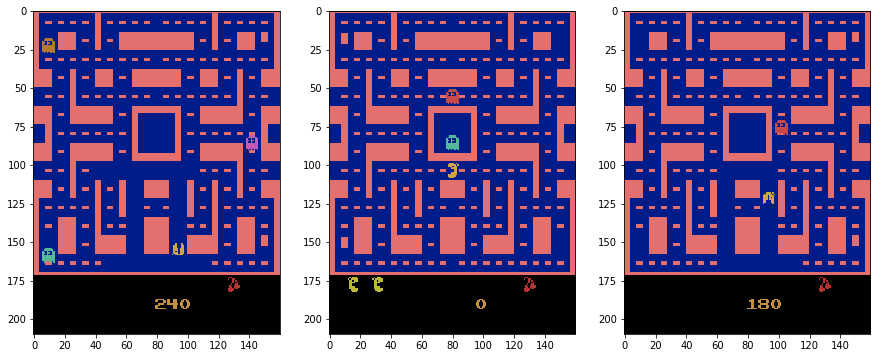

epoch 6410, loss 34.13830, reward 23.65931 
rec 33.465 reg 0.673
epoch 6420, loss 46.14061, reward 23.04338 
rec 45.470 reg 0.670
epoch 6430, loss 44.71218, reward 22.67654 
rec 44.044 reg 0.668
epoch 6440, loss 39.69997, reward 22.22138 
rec 39.031 reg 0.669
epoch 6450, loss 41.02767, reward 21.74925 
rec 40.359 reg 0.669
epoch 6460, loss 49.38790, reward 21.63682 
rec 48.720 reg 0.668
epoch 6470, loss 56.69430, reward 21.53564 
rec 56.023 reg 0.671
epoch 6480, loss 76.00622, reward 21.13208 
rec 75.314 reg 0.693
epoch 6490, loss 80.25373, reward 21.14387 
rec 79.548 reg 0.705
epoch 6500, loss 54.05664, reward 20.77948 
rec 53.341 reg 0.716
Learning curves:


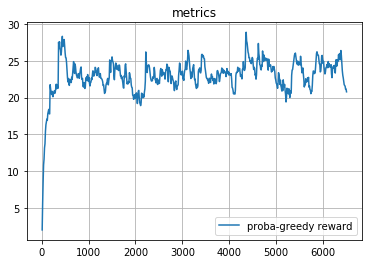

Random session examples


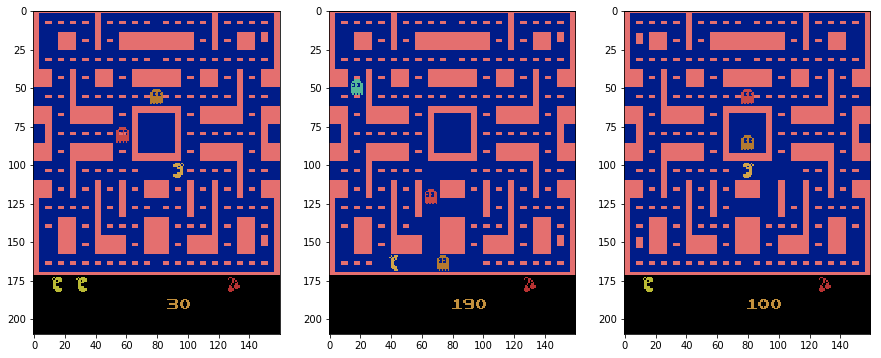

epoch 6510, loss 48.74636, reward 20.76403 
rec 48.023 reg 0.723
epoch 6520, loss 59.99662, reward 21.87513 
rec 59.271 reg 0.725
epoch 6530, loss 65.42864, reward 22.25012 
rec 64.703 reg 0.726
epoch 6540, loss 53.03100, reward 22.02511 
rec 52.306 reg 0.725
epoch 6550, loss 54.21037, reward 23.01009 
rec 53.489 reg 0.721
epoch 6560, loss 50.27649, reward 22.89659 
rec 49.559 reg 0.717
epoch 6570, loss 75.57659, reward 23.66943 
rec 74.862 reg 0.714
epoch 6580, loss 61.31231, reward 24.61498 
rec 60.590 reg 0.722
epoch 6590, loss 39.40565, reward 23.46599 
rec 38.682 reg 0.723
epoch 6600, loss 42.22056, reward 22.99439 
rec 41.502 reg 0.719
Learning curves:


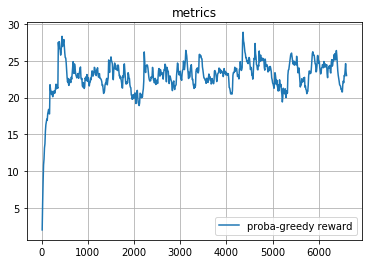

Random session examples


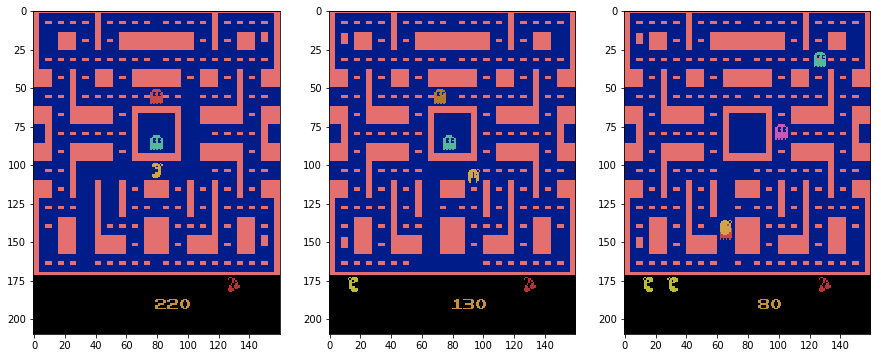

epoch 6610, loss 46.67674, reward 22.50745 
rec 45.964 reg 0.712
epoch 6620, loss 47.93062, reward 21.81920 
rec 47.221 reg 0.710
epoch 6630, loss 64.47604, reward 22.82478 
rec 63.763 reg 0.713
epoch 6640, loss 64.81132, reward 23.47980 
rec 64.097 reg 0.715
epoch 6650, loss 44.18178, reward 24.13182 
rec 43.470 reg 0.711
epoch 6660, loss 51.61181, reward 23.03114 
rec 50.905 reg 0.706
epoch 6670, loss 46.00415, reward 22.04053 
rec 45.302 reg 0.702
epoch 6680, loss 42.15727, reward 21.46147 
rec 41.458 reg 0.700
epoch 6690, loss 50.56811, reward 21.31533 
rec 49.869 reg 0.699
epoch 6700, loss 45.58713, reward 21.05879 
rec 44.890 reg 0.697
Learning curves:


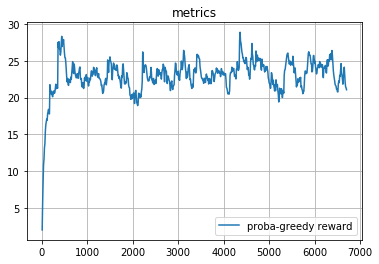

Random session examples


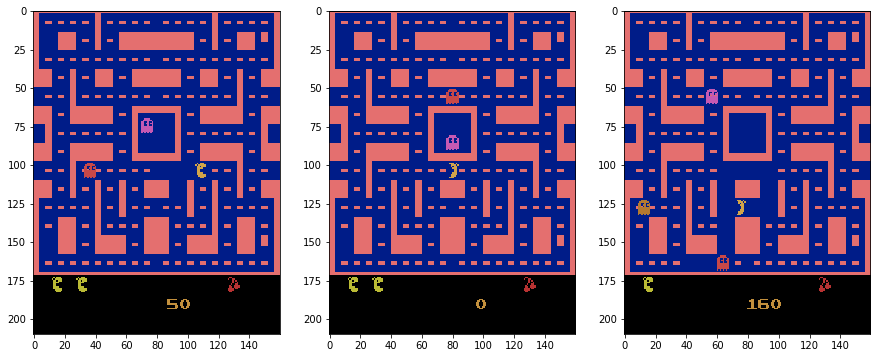

epoch 6710, loss 54.41962, reward 21.20292 
rec 53.720 reg 0.699
epoch 6720, loss 48.87319, reward 21.20762 
rec 48.168 reg 0.706
epoch 6730, loss 63.46241, reward 22.52436 
rec 62.755 reg 0.708
epoch 6740, loss 38.64658, reward 22.08443 
rec 37.944 reg 0.703
epoch 6750, loss 36.77130, reward 21.43848 
rec 36.077 reg 0.695
epoch 6760, loss 47.18255, reward 21.60713 
rec 46.488 reg 0.694
epoch 6770, loss 44.13781, reward 21.32142 
rec 43.443 reg 0.695
epoch 6780, loss 35.57132, reward 20.56428 
rec 34.881 reg 0.690
epoch 6790, loss 33.97951, reward 19.75785 
rec 33.295 reg 0.684
epoch 6800, loss 38.59281, reward 19.40707 
rec 37.911 reg 0.682
Learning curves:


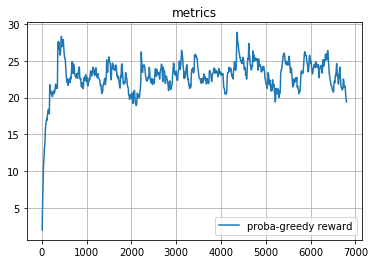

Random session examples


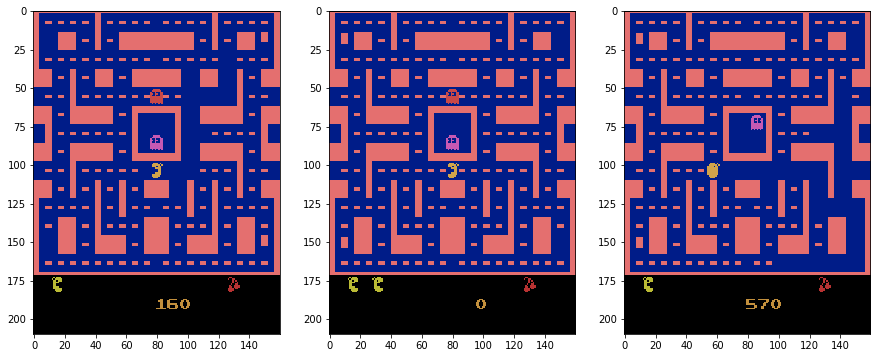

epoch 6810, loss 57.82921, reward 19.15386 
rec 57.150 reg 0.680
epoch 6820, loss 45.34619, reward 19.73847 
rec 44.671 reg 0.675
epoch 6830, loss 41.77311, reward 19.63963 
rec 41.102 reg 0.671
epoch 6840, loss 43.92193, reward 19.98816 
rec 43.257 reg 0.665
epoch 6850, loss 50.40967, reward 20.67685 
rec 49.747 reg 0.662
epoch 6860, loss 47.57954, reward 20.35916 
rec 46.919 reg 0.660
epoch 6870, loss 75.23647, reward 20.38575 
rec 74.579 reg 0.658
epoch 6880, loss 51.91748, reward 20.78467 
rec 51.261 reg 0.656
epoch 6890, loss 52.26686, reward 21.39370 
rec 51.614 reg 0.653
epoch 6900, loss 49.06552, reward 21.37933 
rec 48.415 reg 0.650
Learning curves:


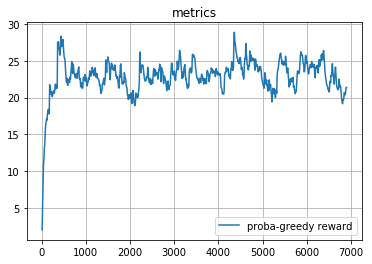

Random session examples


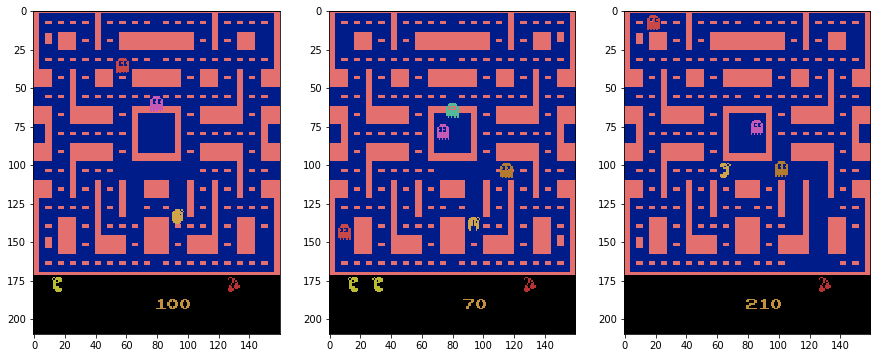

epoch 6910, loss 35.86690, reward 20.74140 
rec 35.220 reg 0.647
epoch 6920, loss 56.16219, reward 21.10476 
rec 55.519 reg 0.643
epoch 6930, loss 465.04511, reward 24.05678 
rec 464.406 reg 0.640
epoch 6940, loss 57.42459, reward 22.77611 
rec 56.782 reg 0.642
epoch 6950, loss 70.12635, reward 22.99850 
rec 69.482 reg 0.645
epoch 6960, loss 48.91723, reward 22.44865 
rec 48.274 reg 0.643
epoch 6970, loss 46.83175, reward 22.32878 
rec 46.190 reg 0.642
epoch 6980, loss 44.09207, reward 22.15840 
rec 43.451 reg 0.641
epoch 6990, loss 52.23891, reward 22.00506 
rec 51.598 reg 0.641
epoch 7000, loss 63.41905, reward 22.55456 
rec 62.778 reg 0.641
Learning curves:


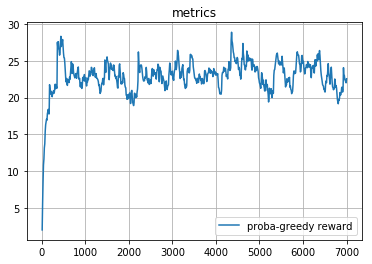

Random session examples


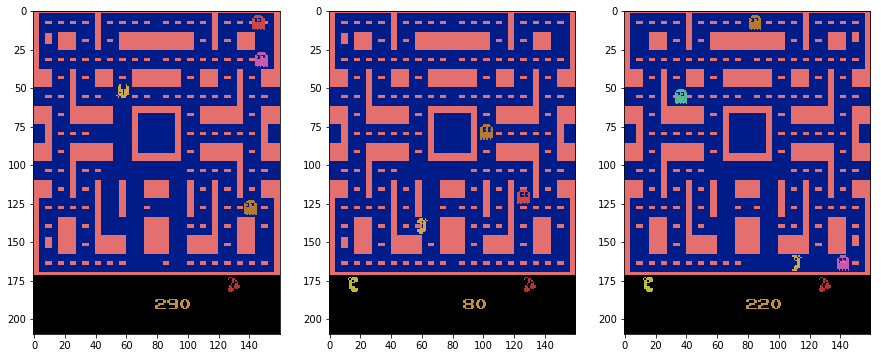

[2017-05-24 03:57:00,569] Making new env: MsPacman-v0
[2017-05-24 03:57:00,738] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 03:57:00,747] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.6.6612.video000000.mp4
[2017-05-24 03:57:01,940] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.6.6612.video000001.mp4


Episode finished after 536 timesteps, rw = 170.0
Episode finished after 558 timesteps, rw = 160.0
Episode finished after 571 timesteps, rw = 200.0
Episode finished after 462 timesteps, rw = 170.0
Episode finished after 616 timesteps, rw = 250.0
Episode finished after 595 timesteps, rw = 240.0
Episode finished after 1172 timesteps, rw = 420.0


[2017-05-24 03:57:10,071] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.6.6612.video000008.mp4


Episode finished after 1082 timesteps, rw = 460.0
Episode finished after 667 timesteps, rw = 170.0
Episode finished after 662 timesteps, rw = 240.0
Episode finished after 541 timesteps, rw = 130.0
Episode finished after 666 timesteps, rw = 170.0
Episode finished after 662 timesteps, rw = 240.0
Episode finished after 575 timesteps, rw = 160.0
Episode finished after 725 timesteps, rw = 240.0
Episode finished after 839 timesteps, rw = 280.0
Episode finished after 678 timesteps, rw = 180.0
Episode finished after 690 timesteps, rw = 310.0
Episode finished after 673 timesteps, rw = 260.0


[2017-05-24 03:57:22,119] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/proba_videos')


Episode finished after 559 timesteps, rw = 130.0
Mean 229.0, Var 7359.0
epoch 7010, loss 61.22263, reward 23.17410 
rec 60.583 reg 0.640
epoch 7020, loss 57.37140, reward 23.73169 
rec 56.734 reg 0.637
epoch 7030, loss 45.36543, reward 23.29602 
rec 44.732 reg 0.634
epoch 7040, loss 46.05884, reward 23.02892 
rec 45.428 reg 0.631
epoch 7050, loss 67.29635, reward 23.16353 
rec 66.668 reg 0.628
epoch 7060, loss 48.62741, reward 22.40967 
rec 48.002 reg 0.625
epoch 7070, loss 49.73868, reward 22.91871 
rec 49.117 reg 0.622
epoch 7080, loss 47.60342, reward 22.25184 
rec 46.984 reg 0.619
epoch 7090, loss 34.94768, reward 20.96415 
rec 34.331 reg 0.616
epoch 7100, loss 42.66101, reward 20.74274 
rec 42.047 reg 0.614
Learning curves:


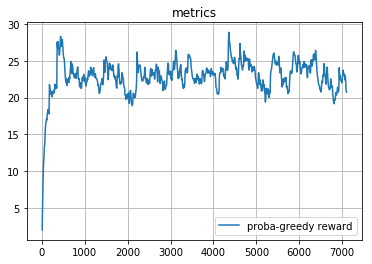

Random session examples


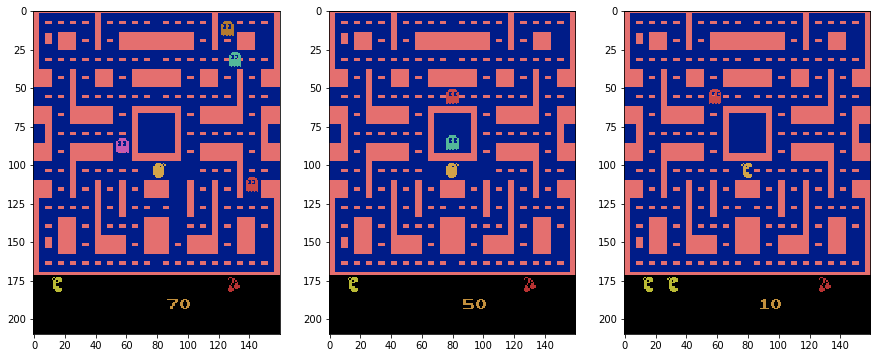

epoch 7110, loss 42.09245, reward 20.85596 
rec 41.476 reg 0.617
epoch 7120, loss 50.88456, reward 21.33287 
rec 50.261 reg 0.624
epoch 7130, loss 60.88974, reward 22.94958 
rec 60.259 reg 0.631
epoch 7140, loss 50.91733, reward 22.27962 
rec 50.275 reg 0.643
epoch 7150, loss 59.92397, reward 21.48916 
rec 59.264 reg 0.660
epoch 7160, loss 53.27571, reward 21.34024 
rec 52.607 reg 0.669
epoch 7170, loss 46.54031, reward 20.76872 
rec 45.867 reg 0.673
epoch 7180, loss 43.82175, reward 20.06685 
rec 43.147 reg 0.675
epoch 7190, loss 41.56039, reward 19.12266 
rec 40.886 reg 0.674
epoch 7200, loss 46.95774, reward 19.33540 
rec 46.284 reg 0.673
Learning curves:


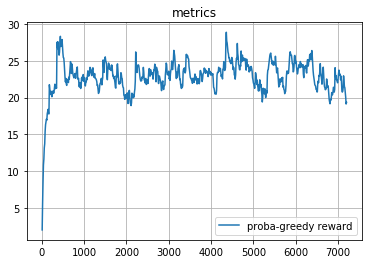

Random session examples


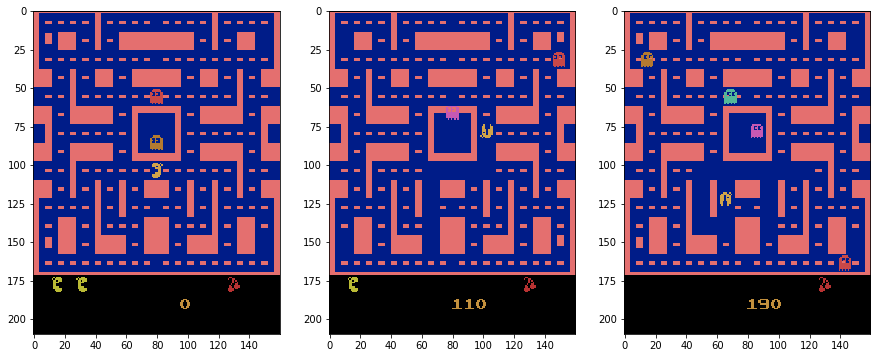

epoch 7210, loss 38.14333, reward 18.96436 
rec 37.472 reg 0.672
epoch 7220, loss 37.88287, reward 18.31792 
rec 37.214 reg 0.669
epoch 7230, loss 42.96658, reward 17.79863 
rec 42.302 reg 0.665
epoch 7240, loss 42.17406, reward 17.83127 
rec 41.511 reg 0.663
epoch 7250, loss 61.03427, reward 18.17314 
rec 60.367 reg 0.667
epoch 7260, loss 52.20531, reward 18.91833 
rec 51.538 reg 0.667
epoch 7270, loss 56.40608, reward 19.96399 
rec 55.743 reg 0.663
epoch 7280, loss 51.99686, reward 20.28009 
rec 51.338 reg 0.659
epoch 7290, loss 43.27743, reward 20.31458 
rec 42.623 reg 0.655
epoch 7300, loss 55.23062, reward 20.72063 
rec 54.580 reg 0.651
Learning curves:


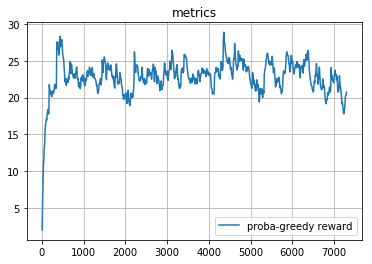

Random session examples


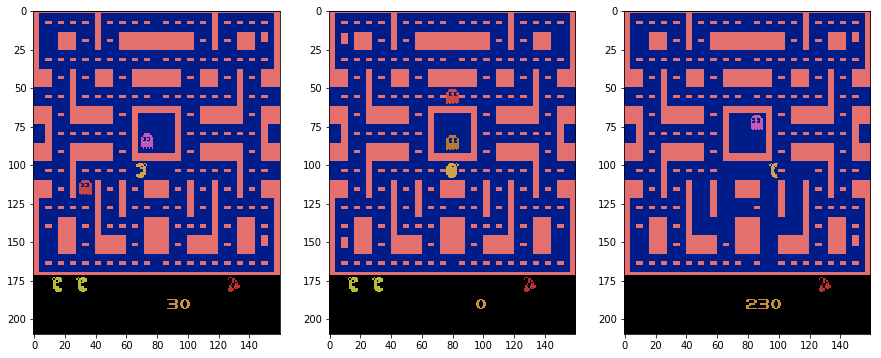

epoch 7310, loss 43.71603, reward 20.46106 
rec 43.069 reg 0.647
epoch 7320, loss 43.71042, reward 20.47746 
rec 43.067 reg 0.643
epoch 7330, loss 50.16911, reward 20.67971 
rec 49.529 reg 0.640
epoch 7340, loss 2877.63778, reward 26.42424 
rec 2876.999 reg 0.639
epoch 7350, loss 80.76837, reward 26.03182 
rec 80.102 reg 0.666
epoch 7360, loss 89.88852, reward 25.99113 
rec 89.203 reg 0.686
epoch 7370, loss 58.56889, reward 26.45452 
rec 57.873 reg 0.696
epoch 7380, loss 51.42054, reward 26.18407 
rec 50.719 reg 0.702
epoch 7390, loss 51.99265, reward 26.12816 
rec 51.285 reg 0.708
epoch 7400, loss 37.86291, reward 25.70285 
rec 37.152 reg 0.711
Learning curves:


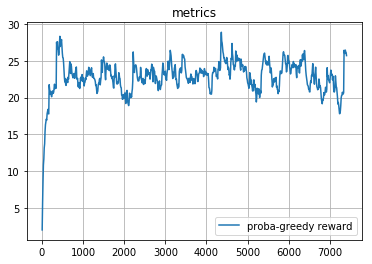

Random session examples


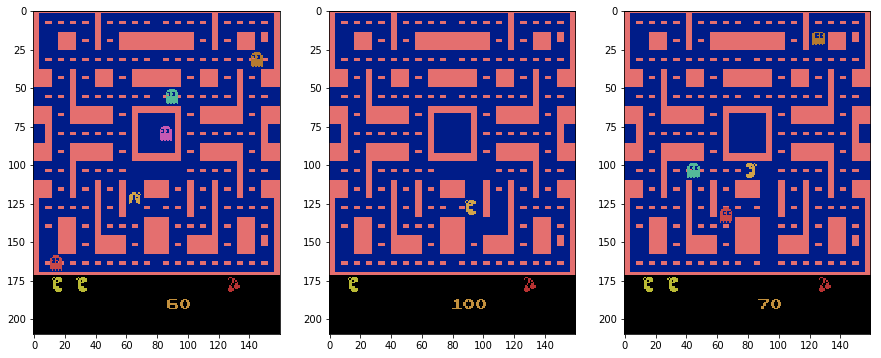

epoch 7410, loss 53.67569, reward 25.69506 
rec 52.956 reg 0.719
epoch 7420, loss 40.93711, reward 25.50056 
rec 40.213 reg 0.725
epoch 7430, loss 38.78757, reward 24.38800 
rec 38.063 reg 0.724
epoch 7440, loss 56.13970, reward 24.13670 
rec 55.419 reg 0.721
epoch 7450, loss 53.66463, reward 24.16053 
rec 52.931 reg 0.733
epoch 7460, loss 52.61000, reward 24.30698 
rec 51.870 reg 0.740
epoch 7470, loss 60.41597, reward 24.81378 
rec 59.677 reg 0.738
epoch 7480, loss 58.31360, reward 24.89490 
rec 57.580 reg 0.733
epoch 7490, loss 57.24003, reward 24.90541 
rec 56.513 reg 0.727
epoch 7500, loss 50.29818, reward 24.35237 
rec 49.576 reg 0.723
Learning curves:


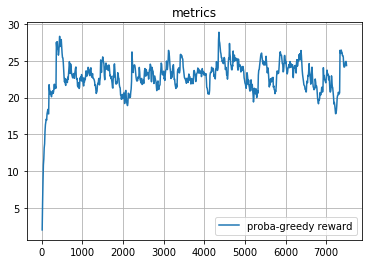

Random session examples


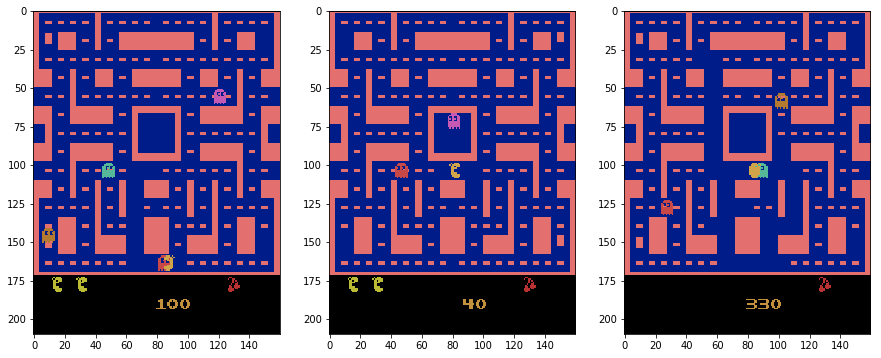

epoch 7510, loss 47.44372, reward 23.97963 
rec 46.727 reg 0.717
epoch 7520, loss 51.20810, reward 24.08167 
rec 50.497 reg 0.711
epoch 7530, loss 57.03416, reward 23.92350 
rec 56.327 reg 0.707
epoch 7540, loss 48.11101, reward 23.40615 
rec 47.406 reg 0.705
epoch 7550, loss 60.31718, reward 23.87804 
rec 59.615 reg 0.702
epoch 7560, loss 47.44133, reward 23.30273 
rec 46.741 reg 0.700
epoch 7570, loss 265.61540, reward 24.40996 
rec 264.918 reg 0.698
epoch 7580, loss 51.73860, reward 24.59396 
rec 51.042 reg 0.696
epoch 7590, loss 44.95745, reward 23.57207 
rec 44.263 reg 0.695
epoch 7600, loss 59.00740, reward 23.52736 
rec 58.316 reg 0.692
Learning curves:


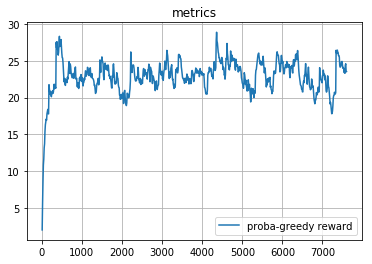

Random session examples


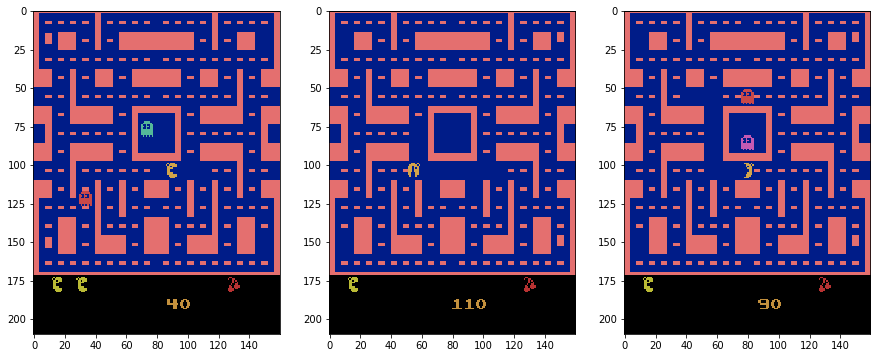

epoch 7610, loss 267.72745, reward 24.79962 
rec 267.038 reg 0.690
epoch 7620, loss 45.66421, reward 24.19466 
rec 44.975 reg 0.689
epoch 7630, loss 54.79253, reward 24.52520 
rec 54.107 reg 0.686
epoch 7640, loss 51.18670, reward 24.51018 
rec 50.505 reg 0.682
epoch 7650, loss 35.99201, reward 23.49666 
rec 35.311 reg 0.681
epoch 7660, loss 51.00842, reward 23.45949 
rec 50.329 reg 0.679
epoch 7670, loss 46.20023, reward 22.86354 
rec 45.524 reg 0.676
epoch 7680, loss 47.94804, reward 22.95219 
rec 47.273 reg 0.675
epoch 7690, loss 63.05399, reward 24.34447 
rec 62.380 reg 0.674
epoch 7700, loss 57.67234, reward 24.22252 
rec 56.999 reg 0.674
Learning curves:


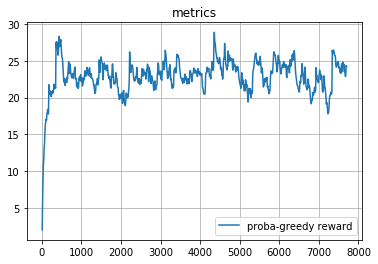

Random session examples


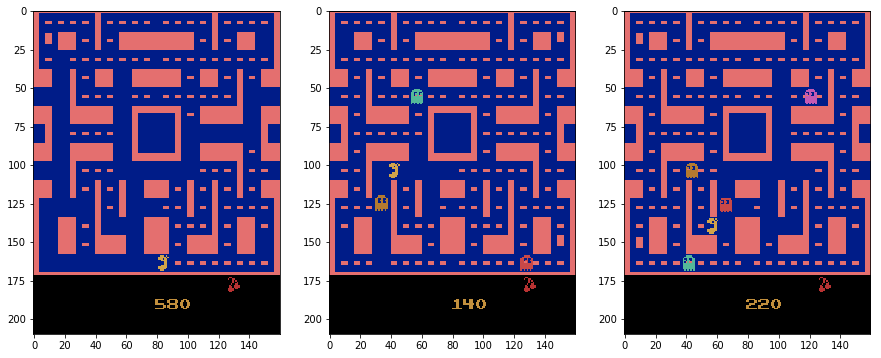

epoch 7710, loss 65.68855, reward 25.05027 
rec 65.013 reg 0.675
epoch 7720, loss 49.56806, reward 25.48274 
rec 48.891 reg 0.677
epoch 7730, loss 42.69061, reward 24.74697 
rec 42.015 reg 0.676
epoch 7740, loss 60.66292, reward 24.64727 
rec 59.983 reg 0.679
epoch 7750, loss 61.33523, reward 25.05755 
rec 60.655 reg 0.680
epoch 7760, loss 57.42937, reward 24.73929 
rec 56.750 reg 0.679
epoch 7770, loss 50.82366, reward 23.89036 
rec 50.144 reg 0.680
epoch 7780, loss 53.16717, reward 23.56383 
rec 52.490 reg 0.677
epoch 7790, loss 64.03752, reward 24.26994 
rec 63.363 reg 0.675
epoch 7800, loss 64.42011, reward 24.65545 
rec 63.746 reg 0.674
Learning curves:


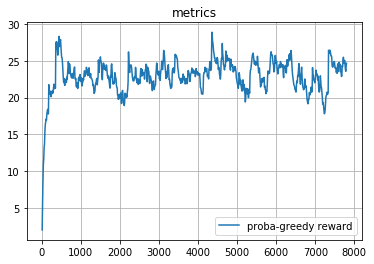

Random session examples


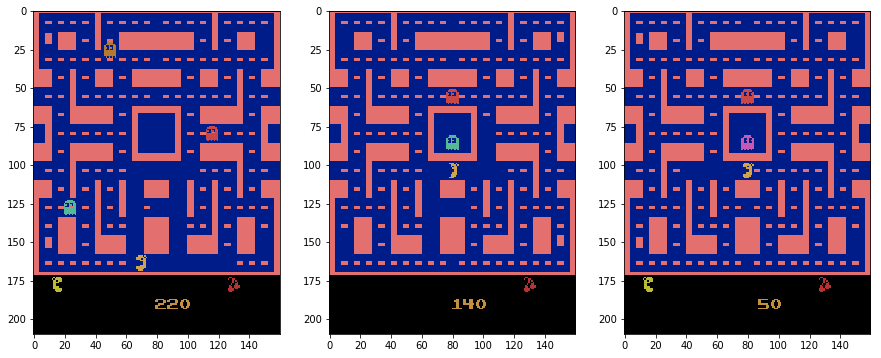

epoch 7810, loss 61.77116, reward 24.87740 
rec 61.099 reg 0.672
epoch 7820, loss 45.41632, reward 23.95216 
rec 44.748 reg 0.668
epoch 7830, loss 61.48428, reward 24.74445 
rec 60.820 reg 0.664
epoch 7840, loss 53.38934, reward 24.70750 
rec 52.727 reg 0.662
epoch 7850, loss 53.42252, reward 23.98675 
rec 52.762 reg 0.661
epoch 7860, loss 47.18586, reward 23.65058 
rec 46.527 reg 0.659
epoch 7870, loss 62.16236, reward 24.34802 
rec 61.507 reg 0.655
epoch 7880, loss 41.94970, reward 24.10072 
rec 41.296 reg 0.653
epoch 7890, loss 48.00472, reward 24.00315 
rec 47.351 reg 0.654
epoch 7900, loss 65.37629, reward 23.85283 
rec 64.723 reg 0.653
Learning curves:


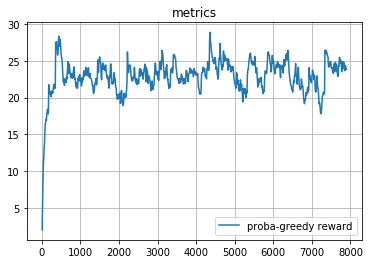

Random session examples


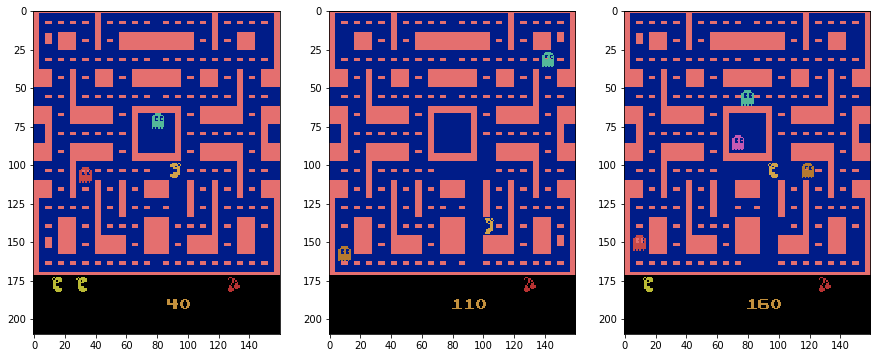

epoch 7910, loss 46.22130, reward 23.53005 
rec 45.570 reg 0.652
epoch 7920, loss 53.57935, reward 22.61454 
rec 52.930 reg 0.649
epoch 7930, loss 63.79703, reward 23.35309 
rec 63.149 reg 0.648
epoch 7940, loss 59.81117, reward 23.45528 
rec 59.164 reg 0.648
epoch 7950, loss 61.39694, reward 24.29725 
rec 60.749 reg 0.648
epoch 7960, loss 50.68201, reward 23.68003 
rec 50.036 reg 0.646
epoch 7970, loss 42.71024, reward 23.06202 
rec 42.066 reg 0.644
epoch 7980, loss 39.03717, reward 22.44332 
rec 38.395 reg 0.643
epoch 7990, loss 43.12727, reward 21.69899 
rec 42.482 reg 0.645
epoch 8000, loss 55.19958, reward 20.71659 
rec 54.548 reg 0.652
Learning curves:


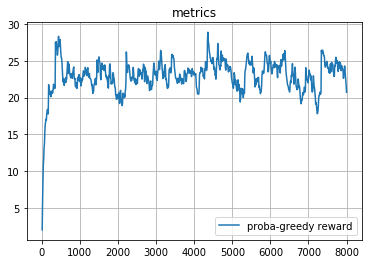

Random session examples


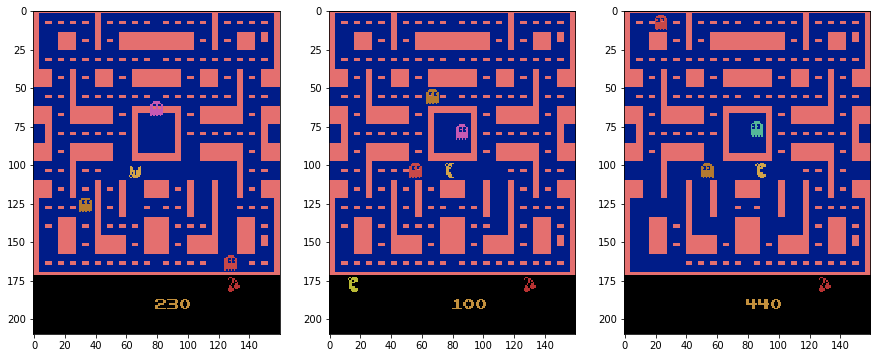

[2017-05-24 04:18:59,621] Making new env: MsPacman-v0
[2017-05-24 04:18:59,790] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 04:18:59,799] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.7.6612.video000000.mp4
[2017-05-24 04:19:01,542] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.7.6612.video000001.mp4


Episode finished after 834 timesteps, rw = 390.0
Episode finished after 683 timesteps, rw = 210.0
Episode finished after 671 timesteps, rw = 190.0
Episode finished after 581 timesteps, rw = 190.0
Episode finished after 702 timesteps, rw = 220.0
Episode finished after 614 timesteps, rw = 130.0
Episode finished after 700 timesteps, rw = 120.0


[2017-05-24 04:19:09,256] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.7.6612.video000008.mp4


Episode finished after 686 timesteps, rw = 120.0
Episode finished after 861 timesteps, rw = 210.0
Episode finished after 525 timesteps, rw = 250.0
Episode finished after 533 timesteps, rw = 200.0
Episode finished after 425 timesteps, rw = 110.0
Episode finished after 641 timesteps, rw = 180.0
Episode finished after 542 timesteps, rw = 180.0
Episode finished after 771 timesteps, rw = 300.0
Episode finished after 674 timesteps, rw = 310.0
Episode finished after 676 timesteps, rw = 240.0
Episode finished after 563 timesteps, rw = 220.0
Episode finished after 710 timesteps, rw = 340.0


[2017-05-24 04:19:21,473] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/proba_videos')


Episode finished after 569 timesteps, rw = 150.0
Mean 213.0, Var 5441.0
epoch 8010, loss 37.23472, reward 19.33243 
rec 36.580 reg 0.655
epoch 8020, loss 48.05210, reward 19.14919 
rec 47.397 reg 0.655
epoch 8030, loss 65.27760, reward 19.98427 
rec 64.617 reg 0.661
epoch 8040, loss 65.61669, reward 20.36084 
rec 64.945 reg 0.671
epoch 8050, loss 57.24481, reward 19.82476 
rec 56.568 reg 0.677
epoch 8060, loss 46.66340, reward 20.34228 
rec 45.981 reg 0.683
epoch 8070, loss 44.98336, reward 19.49555 
rec 44.297 reg 0.686
epoch 8080, loss 50.67057, reward 19.54600 
rec 49.977 reg 0.694
epoch 8090, loss 46.44025, reward 19.40390 
rec 45.742 reg 0.698
epoch 8100, loss 48.64711, reward 19.83851 
rec 47.949 reg 0.698
Learning curves:


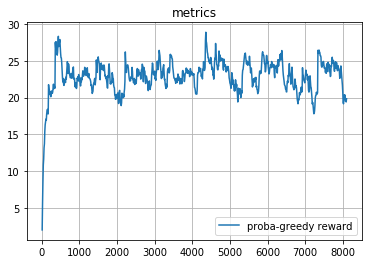

Random session examples


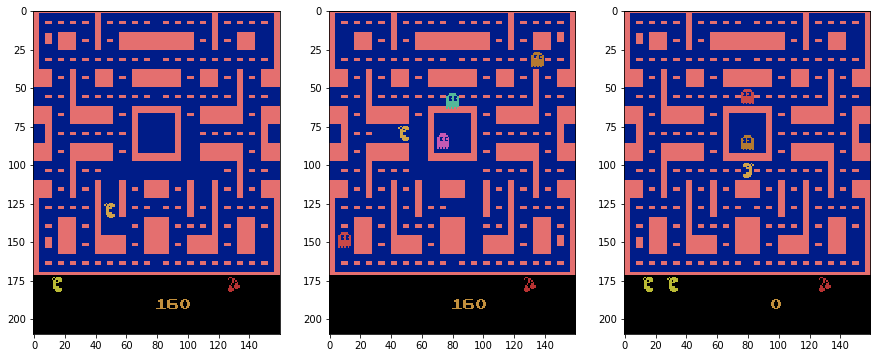

epoch 8110, loss 35.66831, reward 20.04216 
rec 34.973 reg 0.695
epoch 8120, loss 66.87176, reward 20.72544 
rec 66.180 reg 0.692
epoch 8130, loss 65.22299, reward 21.02790 
rec 64.531 reg 0.692
epoch 8140, loss 57.84142, reward 21.23761 
rec 57.150 reg 0.691
epoch 8150, loss 59.38498, reward 20.80135 
rec 58.692 reg 0.693
epoch 8160, loss 74.70523, reward 21.22121 
rec 74.007 reg 0.699
epoch 8170, loss 72.65081, reward 21.16159 
rec 71.950 reg 0.701
epoch 8180, loss 51.73276, reward 20.92043 
rec 51.031 reg 0.702
epoch 8190, loss 33.91924, reward 19.57839 
rec 33.215 reg 0.705
epoch 8200, loss 35.74553, reward 18.55805 
rec 35.038 reg 0.707
Learning curves:


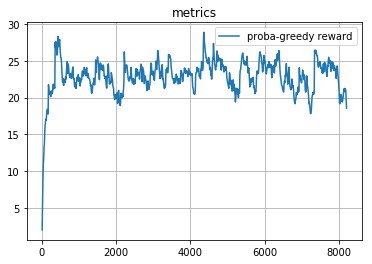

Random session examples


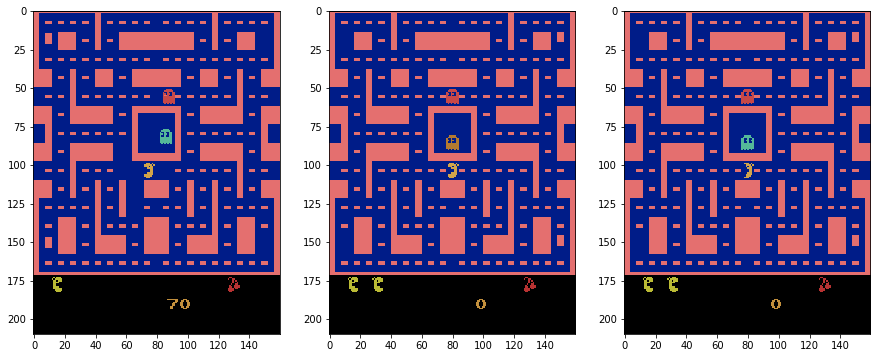

epoch 8210, loss 45.54414, reward 19.07725 
rec 44.837 reg 0.707
epoch 8220, loss 45.78732, reward 19.29452 
rec 45.078 reg 0.709
epoch 8230, loss 47.12458, reward 20.11507 
rec 46.412 reg 0.712
epoch 8240, loss 55.76971, reward 21.41606 
rec 55.055 reg 0.714
epoch 8250, loss 270.24438, reward 22.14946 
rec 269.530 reg 0.715
epoch 8260, loss 68.01392, reward 21.24701 
rec 67.285 reg 0.729
epoch 8270, loss 76.15935, reward 21.24731 
rec 75.402 reg 0.757
epoch 8280, loss 72.94273, reward 22.49758 
rec 72.169 reg 0.774
epoch 8290, loss 52.89451, reward 22.37282 
rec 52.113 reg 0.782
epoch 8300, loss 69.11203, reward 24.32304 
rec 68.317 reg 0.795
Learning curves:


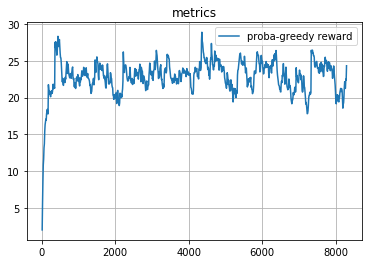

Random session examples


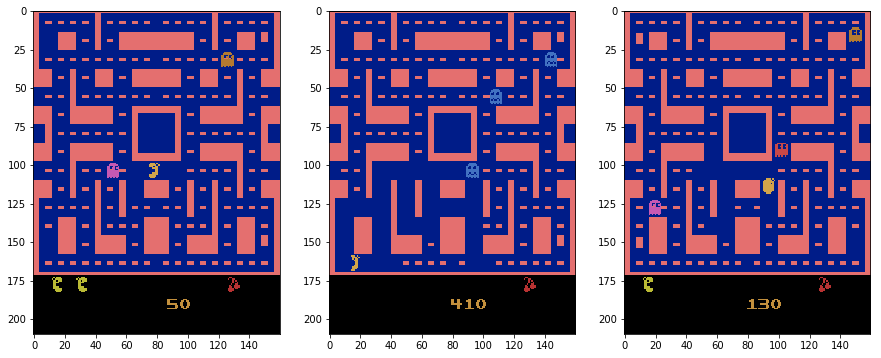

epoch 8310, loss 65.92467, reward 24.51573 
rec 65.105 reg 0.820
epoch 8320, loss 61.21322, reward 25.06416 
rec 60.377 reg 0.836
epoch 8330, loss 61.79594, reward 25.43274 
rec 60.952 reg 0.844
epoch 8340, loss 86.56060, reward 25.57697 
rec 85.717 reg 0.843
epoch 8350, loss 49.67529, reward 24.76927 
rec 48.837 reg 0.838
epoch 8360, loss 58.39668, reward 24.97985 
rec 57.562 reg 0.835
epoch 8370, loss 45.87691, reward 24.66936 
rec 45.047 reg 0.830
epoch 8380, loss 62.90374, reward 25.51493 
rec 62.081 reg 0.823
epoch 8390, loss 70.48151, reward 25.90093 
rec 69.664 reg 0.817
epoch 8400, loss 48.02157, reward 25.74834 
rec 47.210 reg 0.812
Learning curves:


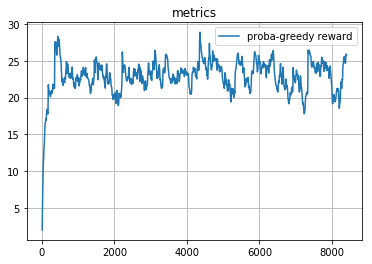

Random session examples


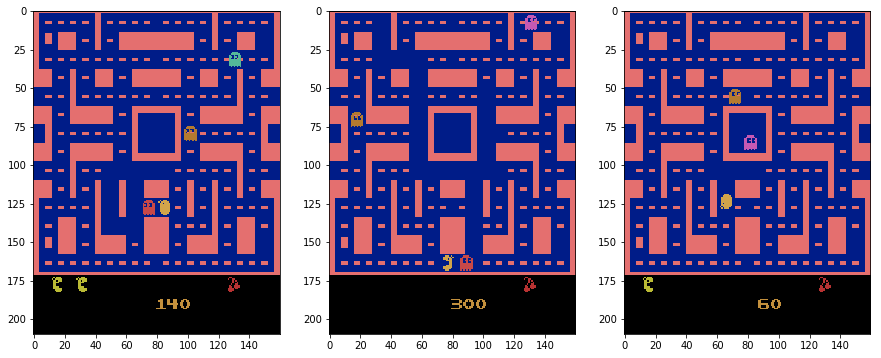

epoch 8410, loss 240.99142, reward 26.11101 
rec 240.186 reg 0.806
epoch 8420, loss 41.02925, reward 25.56240 
rec 40.230 reg 0.799
epoch 8430, loss 50.37184, reward 25.38116 
rec 49.580 reg 0.792
epoch 8440, loss 65.14325, reward 25.03055 
rec 64.359 reg 0.785
epoch 8450, loss 60.70761, reward 24.15249 
rec 59.928 reg 0.779
epoch 8460, loss 46.39406, reward 22.92474 
rec 45.617 reg 0.777
epoch 8470, loss 69.76702, reward 23.06977 
rec 68.995 reg 0.772
epoch 8480, loss 52.62198, reward 22.82529 
rec 51.855 reg 0.767
epoch 8490, loss 53.13922, reward 23.10526 
rec 52.378 reg 0.761
epoch 8500, loss 56.93271, reward 23.73224 
rec 56.175 reg 0.758
Learning curves:


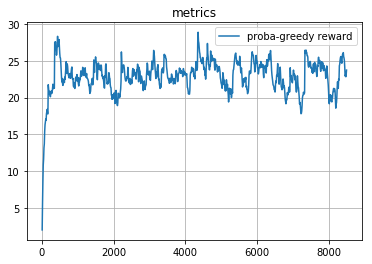

Random session examples


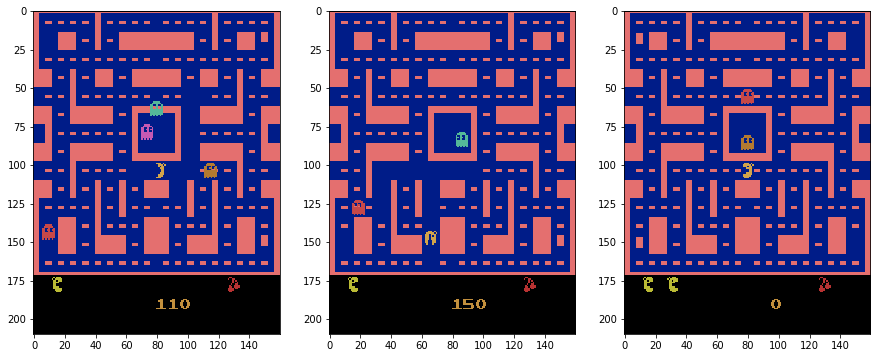

epoch 8510, loss 40.68094, reward 23.35901 
rec 39.928 reg 0.753
epoch 8520, loss 54.68060, reward 23.02311 
rec 53.931 reg 0.750
epoch 8530, loss 39.20341, reward 22.03330 
rec 38.449 reg 0.754
epoch 8540, loss 42.44118, reward 21.07997 
rec 41.689 reg 0.752
epoch 8550, loss 38.03060, reward 20.47197 
rec 37.279 reg 0.752
epoch 8560, loss 47.52289, reward 20.11228 
rec 46.771 reg 0.752
epoch 8570, loss 48.41845, reward 20.66355 
rec 47.668 reg 0.750
epoch 8580, loss 46.83235, reward 21.09719 
rec 46.088 reg 0.744
epoch 8590, loss 51.07597, reward 21.67497 
rec 50.340 reg 0.736
epoch 8600, loss 43.51960, reward 21.56998 
rec 42.790 reg 0.730
Learning curves:


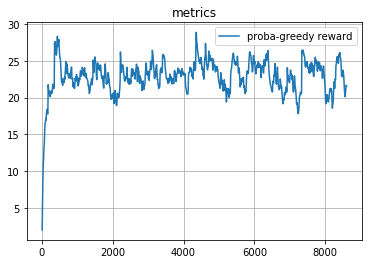

Random session examples


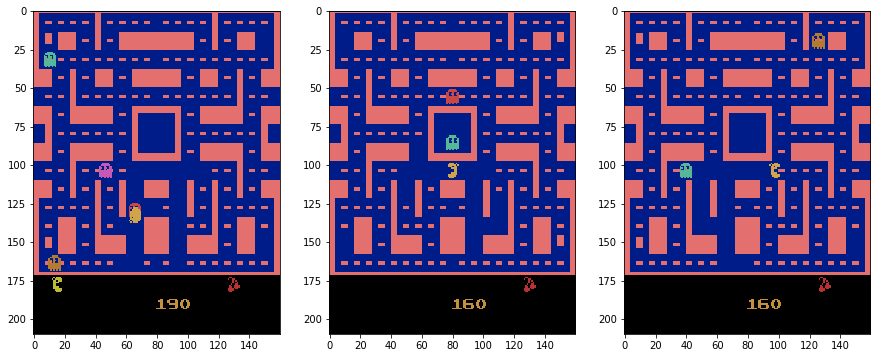

epoch 8610, loss 36.94618, reward 20.97548 
rec 36.221 reg 0.725
epoch 8620, loss 38.95697, reward 20.25293 
rec 38.235 reg 0.722
epoch 8630, loss 57.42290, reward 20.97764 
rec 56.706 reg 0.717
epoch 8640, loss 44.23377, reward 20.75487 
rec 43.521 reg 0.713
epoch 8650, loss 44.24418, reward 20.86689 
rec 43.532 reg 0.712
epoch 8660, loss 62.03323, reward 21.28020 
rec 61.324 reg 0.709
epoch 8670, loss 52.28046, reward 19.90218 
rec 51.574 reg 0.707
epoch 8680, loss 55.86855, reward 20.41196 
rec 55.164 reg 0.704
epoch 8690, loss 54.35461, reward 21.37076 
rec 53.649 reg 0.706
epoch 8700, loss 41.93286, reward 21.04619 
rec 41.227 reg 0.706
Learning curves:


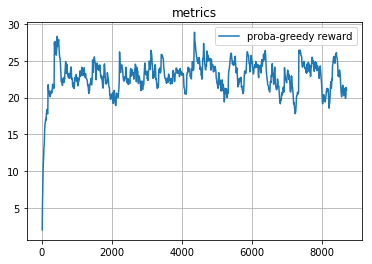

Random session examples


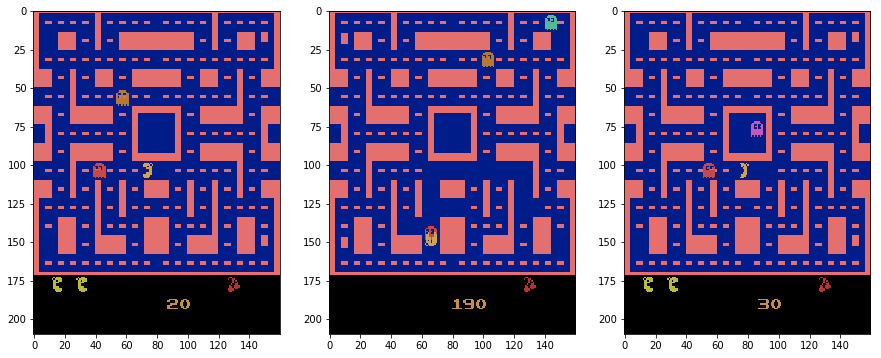

epoch 8710, loss 780.55767, reward 23.56657 
rec 779.852 reg 0.706
epoch 8720, loss 52.94774, reward 23.39741 
rec 52.241 reg 0.707
epoch 8730, loss 51.54088, reward 22.49517 
rec 50.836 reg 0.705
epoch 8740, loss 44.95710, reward 22.43315 
rec 44.251 reg 0.706
epoch 8750, loss 64.75268, reward 22.56484 
rec 64.046 reg 0.706
epoch 8760, loss 35.07539, reward 21.12085 
rec 34.361 reg 0.714
epoch 8770, loss 53.92880, reward 21.63377 
rec 53.203 reg 0.726
epoch 8780, loss 55.96035, reward 22.03289 
rec 55.224 reg 0.736
epoch 8790, loss 46.53449, reward 21.82960 
rec 45.796 reg 0.739
epoch 8800, loss 56.88832, reward 21.89664 
rec 56.149 reg 0.740
Learning curves:


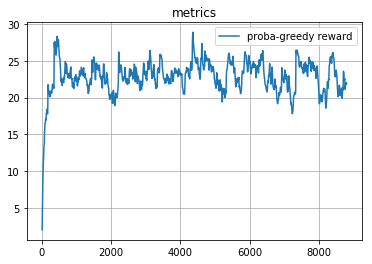

Random session examples


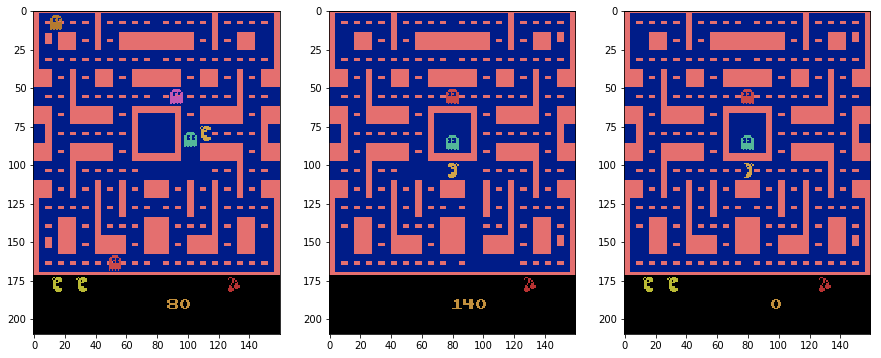

epoch 8810, loss 57.37430, reward 21.76948 
rec 56.634 reg 0.741
epoch 8820, loss 54.42916, reward 21.03003 
rec 53.692 reg 0.737
epoch 8830, loss 39.55848, reward 19.92703 
rec 38.827 reg 0.731
epoch 8840, loss 50.99899, reward 20.12182 
rec 50.272 reg 0.727
epoch 8850, loss 52.22019, reward 20.73464 
rec 51.495 reg 0.725
epoch 8860, loss 45.37422, reward 20.16118 
rec 44.647 reg 0.727
epoch 8870, loss 39.87988, reward 19.77006 
rec 39.154 reg 0.726
epoch 8880, loss 69.04535, reward 20.41805 
rec 68.320 reg 0.725
epoch 25810, loss 46.45996, reward 23.86774 
rec 45.576 reg 0.884
epoch 25820, loss 56.43448, reward 24.04347 
rec 55.551 reg 0.884
epoch 25830, loss 57.96840, reward 24.88912 
rec 57.086 reg 0.883
epoch 25840, loss 49.22460, reward 24.33771 
rec 48.343 reg 0.882
epoch 25850, loss 67.85268, reward 24.52894 
rec 66.972 reg 0.881
epoch 25860, loss 56.21635, reward 24.20104 
rec 55.335 reg 0.881
epoch 25870, loss 57.23976, reward 24.65594 
rec 56.359 reg 0.880
epoch 25880, loss 

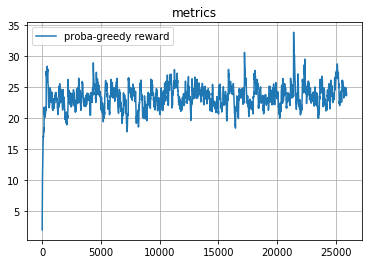

Random session examples


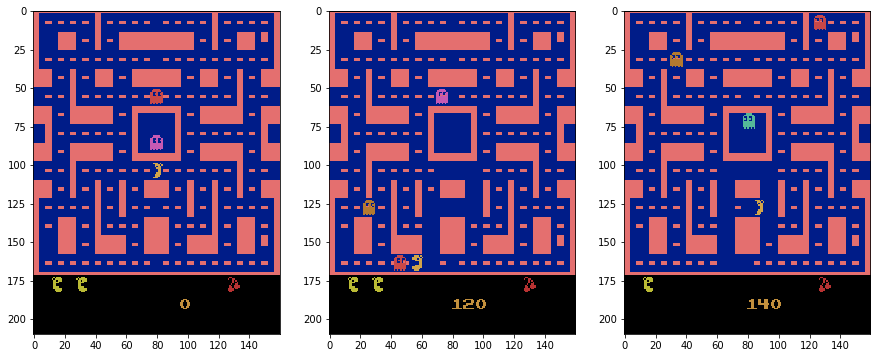

epoch 25910, loss 57.29086, reward 24.51539 
rec 56.415 reg 0.876
epoch 25920, loss 55.23996, reward 24.43885 
rec 54.365 reg 0.875
epoch 25930, loss 56.01593, reward 24.30746 
rec 55.140 reg 0.876
epoch 25940, loss 67.63987, reward 23.87672 
rec 66.763 reg 0.877
epoch 25950, loss 53.71537, reward 23.17655 
rec 52.836 reg 0.880
epoch 25960, loss 60.19616, reward 23.04639 
rec 59.316 reg 0.880
epoch 25970, loss 62.73141, reward 22.49175 
rec 61.851 reg 0.881
epoch 25980, loss 85.53997, reward 23.43008 
rec 84.647 reg 0.892
epoch 25990, loss 51.45624, reward 22.96207 
rec 50.553 reg 0.903
epoch 26000, loss 1586.44738, reward 26.22836 
rec 1585.537 reg 0.911
Learning curves:


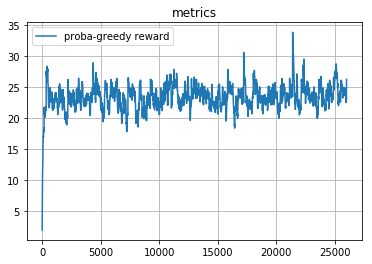

Random session examples


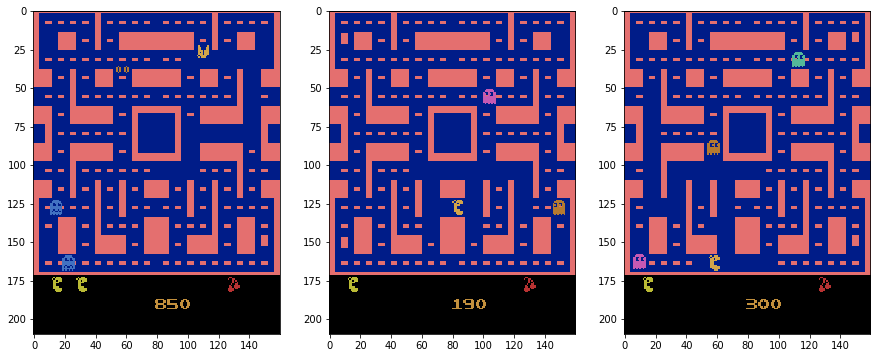

[2017-05-24 11:02:17,415] Making new env: MsPacman-v0
[2017-05-24 11:02:17,584] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 11:02:17,594] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.25.6612.video000000.mp4
[2017-05-24 11:02:19,457] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.25.6612.video000001.mp4


Episode finished after 854 timesteps, rw = 640.0
Episode finished after 521 timesteps, rw = 220.0
Episode finished after 628 timesteps, rw = 150.0
Episode finished after 716 timesteps, rw = 230.0
Episode finished after 403 timesteps, rw = 70.0
Episode finished after 621 timesteps, rw = 140.0
Episode finished after 740 timesteps, rw = 260.0


[2017-05-24 11:02:26,391] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.25.6612.video000008.mp4


Episode finished after 554 timesteps, rw = 150.0
Episode finished after 542 timesteps, rw = 250.0
Episode finished after 720 timesteps, rw = 260.0
Episode finished after 535 timesteps, rw = 230.0
Episode finished after 504 timesteps, rw = 140.0
Episode finished after 634 timesteps, rw = 140.0
Episode finished after 671 timesteps, rw = 210.0
Episode finished after 587 timesteps, rw = 240.0
Episode finished after 507 timesteps, rw = 140.0
Episode finished after 555 timesteps, rw = 150.0
Episode finished after 664 timesteps, rw = 160.0
Episode finished after 643 timesteps, rw = 170.0


[2017-05-24 11:02:37,844] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/proba_videos')


Episode finished after 590 timesteps, rw = 240.0
Mean 209.5, Var 12414.75
epoch 26010, loss 77.62189, reward 26.16803 
rec 76.693 reg 0.929
epoch 26020, loss 75.34476, reward 25.92622 
rec 74.407 reg 0.938
epoch 26030, loss 45.70484, reward 24.95860 
rec 44.763 reg 0.942
epoch 26040, loss 54.92153, reward 24.71274 
rec 53.977 reg 0.945
epoch 26050, loss 48.92044, reward 23.74147 
rec 47.973 reg 0.948
epoch 26060, loss 51.62057, reward 23.36732 
rec 50.664 reg 0.956
epoch 26070, loss 46.45415, reward 22.53059 
rec 45.484 reg 0.970
epoch 26080, loss 66.71321, reward 23.84003 
rec 65.735 reg 0.979
epoch 26090, loss 78.98158, reward 24.14353 
rec 77.992 reg 0.990
epoch 26100, loss 58.96091, reward 24.29167 
rec 57.960 reg 1.001
Learning curves:


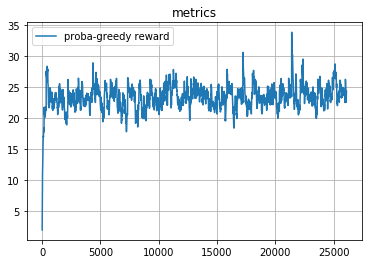

Random session examples


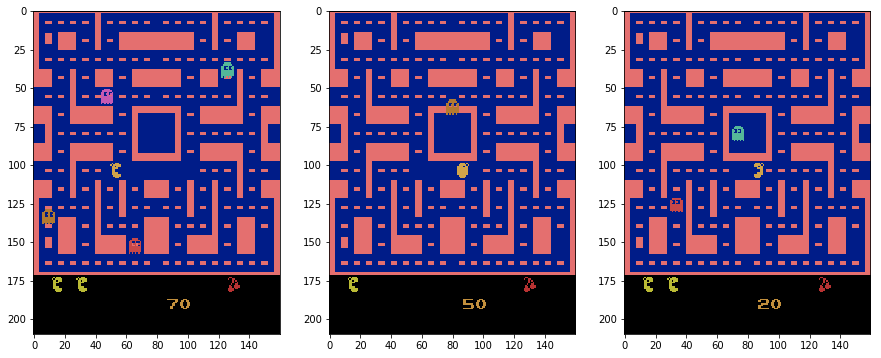

epoch 26110, loss 51.00600, reward 24.48751 
rec 50.004 reg 1.002
epoch 26120, loss 56.44899, reward 24.47626 
rec 55.452 reg 0.997
epoch 26130, loss 49.08681, reward 24.40363 
rec 48.089 reg 0.998
epoch 26140, loss 58.03291, reward 24.52577 
rec 57.037 reg 0.996
epoch 26150, loss 45.47372, reward 23.63569 
rec 44.479 reg 0.995
epoch 26160, loss 53.73959, reward 24.02212 
rec 52.747 reg 0.992
epoch 26170, loss 46.86722, reward 23.61991 
rec 45.879 reg 0.989
epoch 26180, loss 51.80368, reward 24.19542 
rec 50.819 reg 0.985
epoch 26190, loss 56.48420, reward 24.08838 
rec 55.504 reg 0.980
epoch 26200, loss 42.71482, reward 23.36704 
rec 41.738 reg 0.977
Learning curves:


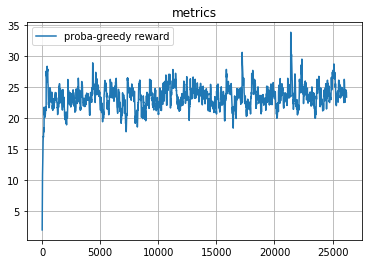

Random session examples


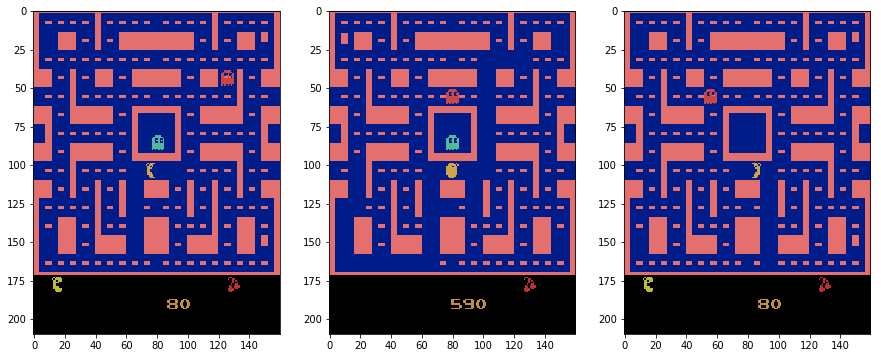

epoch 26210, loss 50.15205, reward 23.21783 
rec 49.179 reg 0.973
epoch 26220, loss 46.22037, reward 22.45855 
rec 45.251 reg 0.970
epoch 26230, loss 44.85188, reward 22.52520 
rec 43.886 reg 0.966
epoch 26240, loss 52.47390, reward 22.89768 
rec 51.510 reg 0.964
epoch 26250, loss 61.35355, reward 23.73291 
rec 60.392 reg 0.961
epoch 26260, loss 66.01664, reward 24.23462 
rec 65.058 reg 0.958
epoch 26270, loss 53.96850, reward 23.99866 
rec 53.013 reg 0.956
epoch 26280, loss 50.18748, reward 24.47379 
rec 49.233 reg 0.954
epoch 26290, loss 48.60560, reward 23.90141 
rec 47.653 reg 0.952
epoch 26300, loss 62.98989, reward 24.07377 
rec 62.040 reg 0.950
Learning curves:


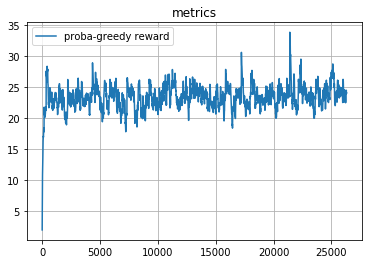

Random session examples


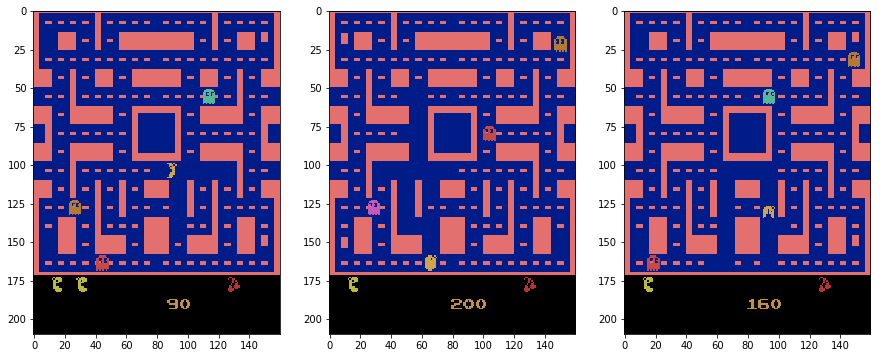

epoch 26310, loss 50.76756, reward 23.79139 
rec 49.820 reg 0.948
epoch 26320, loss 62.08392, reward 23.84975 
rec 61.137 reg 0.947
epoch 26330, loss 50.94271, reward 23.58978 
rec 49.996 reg 0.946
epoch 26340, loss 54.71315, reward 23.48080 
rec 53.769 reg 0.944
epoch 26350, loss 59.89828, reward 23.50772 
rec 58.951 reg 0.947
epoch 26360, loss 87.92299, reward 23.78195 
rec 86.970 reg 0.953
epoch 26370, loss 67.57919, reward 24.52875 
rec 66.627 reg 0.952
epoch 26380, loss 58.40101, reward 25.07588 
rec 57.453 reg 0.948
epoch 26390, loss 49.80457, reward 24.69329 
rec 48.860 reg 0.944
epoch 26400, loss 66.44785, reward 24.22396 
rec 65.506 reg 0.941
Learning curves:


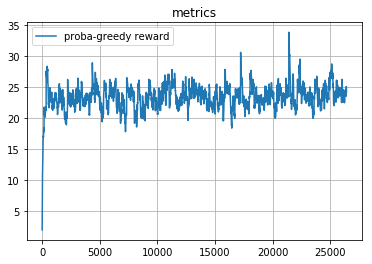

Random session examples


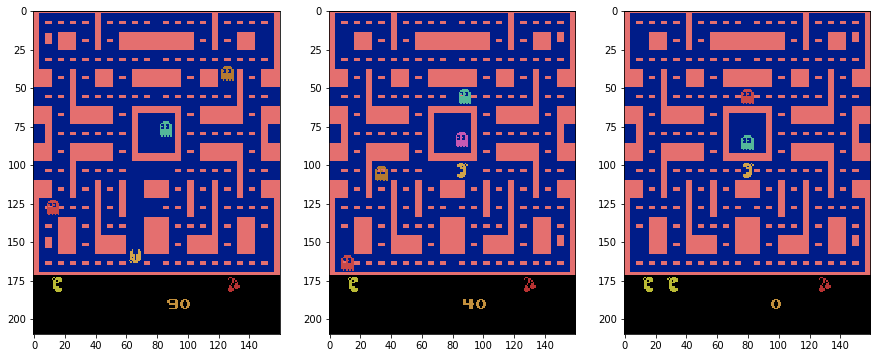

epoch 26410, loss 72.53797, reward 24.86407 
rec 71.599 reg 0.939
epoch 26420, loss 56.86255, reward 25.19016 
rec 55.925 reg 0.938
epoch 26430, loss 47.00172, reward 25.10864 
rec 46.064 reg 0.938
epoch 26440, loss 58.46925, reward 25.59778 
rec 57.534 reg 0.935
epoch 26450, loss 53.73913, reward 25.16300 
rec 52.807 reg 0.932
epoch 26460, loss 45.21480, reward 24.58420 
rec 44.286 reg 0.929
epoch 26470, loss 55.61294, reward 25.25078 
rec 54.687 reg 0.926
epoch 26480, loss 48.88236, reward 25.91320 
rec 47.958 reg 0.924
epoch 26490, loss 58.41823, reward 25.63438 
rec 57.496 reg 0.923
epoch 26500, loss 65.60648, reward 25.75844 
rec 64.685 reg 0.922
Learning curves:


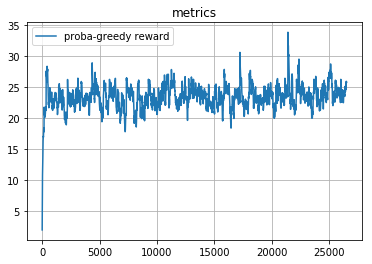

Random session examples


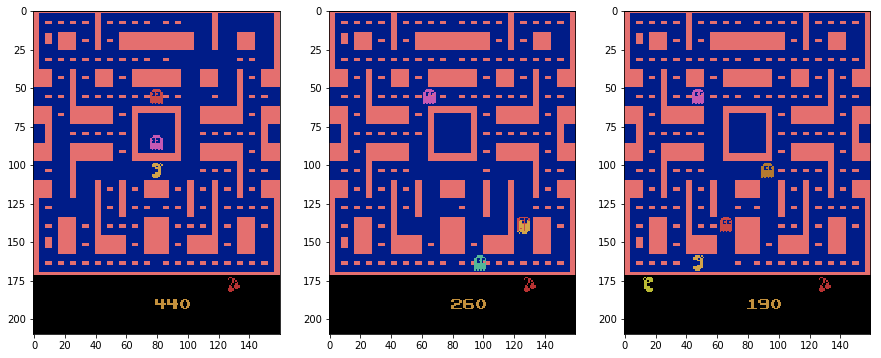

epoch 26510, loss 54.01899, reward 25.93260 
rec 53.098 reg 0.921
epoch 26520, loss 54.52656, reward 24.90184 
rec 53.600 reg 0.926
epoch 26530, loss 47.76706, reward 24.09916 
rec 46.841 reg 0.926
epoch 26540, loss 43.38271, reward 22.81424 
rec 42.459 reg 0.924
epoch 26550, loss 45.89029, reward 22.40782 
rec 44.969 reg 0.921
epoch 26560, loss 71.25176, reward 23.41703 
rec 70.333 reg 0.919
epoch 26570, loss 56.09786, reward 23.82533 
rec 55.181 reg 0.917
epoch 26580, loss 75.47677, reward 24.94280 
rec 74.562 reg 0.915
epoch 26590, loss 51.22827, reward 24.76102 
rec 50.316 reg 0.912
epoch 26600, loss 54.31199, reward 24.78492 
rec 53.401 reg 0.911
Learning curves:


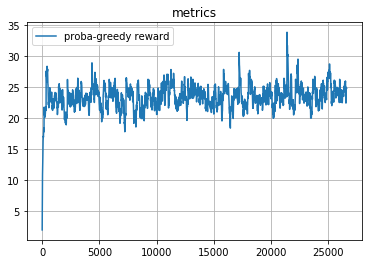

Random session examples


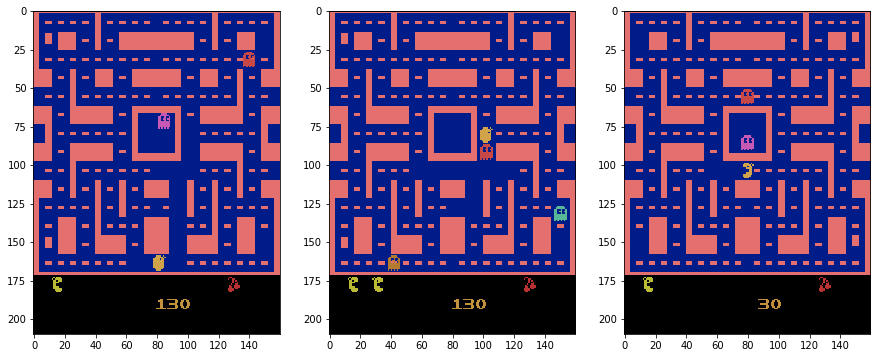

epoch 26610, loss 50.72590, reward 25.11892 
rec 49.816 reg 0.910
epoch 26620, loss 54.49095, reward 24.29453 
rec 53.582 reg 0.909
epoch 26630, loss 45.15839, reward 23.67758 
rec 44.251 reg 0.907
epoch 26640, loss 58.73786, reward 24.49732 
rec 57.830 reg 0.908
epoch 26650, loss 42.92789, reward 23.11009 
rec 42.020 reg 0.908
epoch 26660, loss 53.52690, reward 22.61158 
rec 52.618 reg 0.909
epoch 26670, loss 59.28916, reward 23.10042 
rec 58.381 reg 0.908
epoch 26680, loss 41.78887, reward 22.79038 
rec 40.881 reg 0.908
epoch 26690, loss 55.56410, reward 22.44884 
rec 54.657 reg 0.908
epoch 26700, loss 48.45456, reward 22.70396 
rec 47.548 reg 0.907
Learning curves:


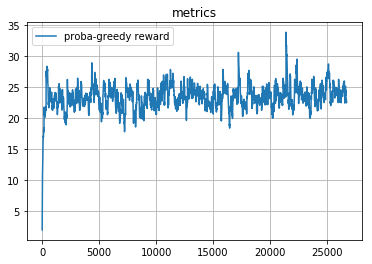

Random session examples


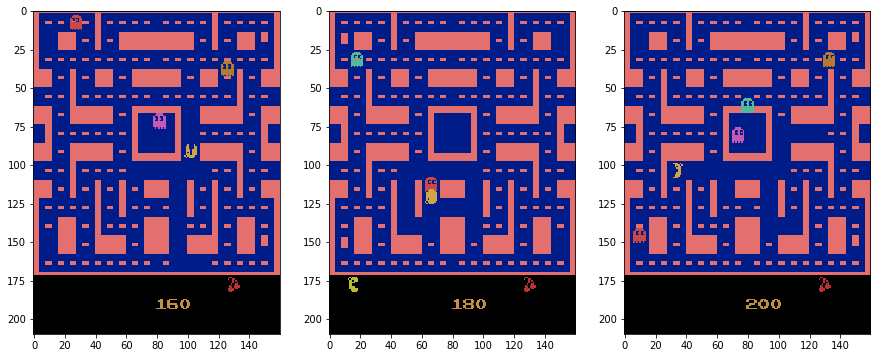

epoch 26710, loss 53.53429, reward 22.87106 
rec 52.628 reg 0.906
epoch 26720, loss 58.11065, reward 22.64646 
rec 57.205 reg 0.905
epoch 26730, loss 55.57736, reward 23.44431 
rec 54.673 reg 0.904
epoch 26740, loss 58.76167, reward 23.28738 
rec 57.854 reg 0.907
epoch 26750, loss 67.98402, reward 23.77114 
rec 67.077 reg 0.907
epoch 26760, loss 53.93771, reward 23.76903 
rec 53.031 reg 0.907
epoch 26770, loss 58.89566, reward 23.26712 
rec 57.988 reg 0.908
epoch 26780, loss 44.77852, reward 22.50291 
rec 43.871 reg 0.907
epoch 26790, loss 52.23539, reward 21.75262 
rec 51.330 reg 0.906
epoch 26800, loss 61.34813, reward 22.20236 
rec 60.444 reg 0.904
Learning curves:


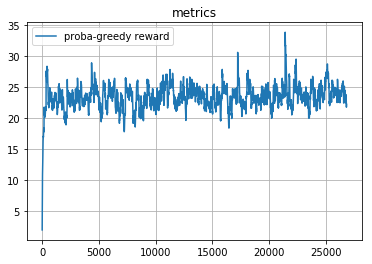

Random session examples


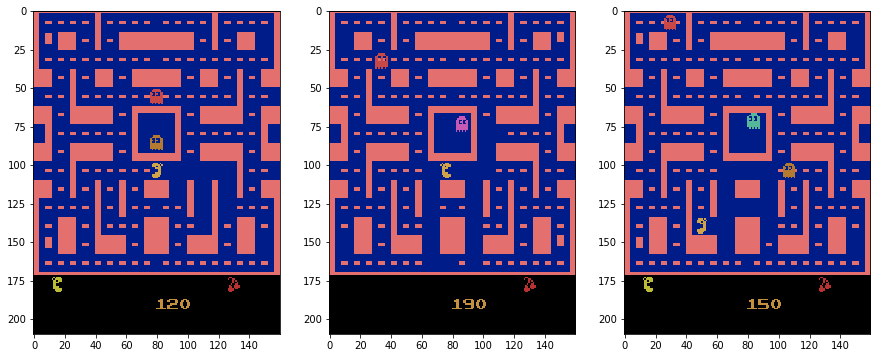

epoch 26810, loss 63.88514, reward 22.73212 
rec 62.983 reg 0.903
epoch 26820, loss 56.20570, reward 23.08391 
rec 55.304 reg 0.901
epoch 26830, loss 49.37672, reward 22.08802 
rec 48.477 reg 0.900
epoch 26840, loss 40.16018, reward 22.25422 
rec 39.261 reg 0.899
epoch 26850, loss 57.19357, reward 21.96630 
rec 56.295 reg 0.898
epoch 26860, loss 65.85377, reward 22.83217 
rec 64.956 reg 0.897
epoch 26870, loss 61.19209, reward 22.73645 
rec 60.295 reg 0.897
epoch 26880, loss 52.80157, reward 22.52530 
rec 51.904 reg 0.898
epoch 26890, loss 51.94263, reward 21.96027 
rec 51.041 reg 0.901
epoch 26900, loss 89.75539, reward 23.45175 
rec 88.849 reg 0.907
Learning curves:


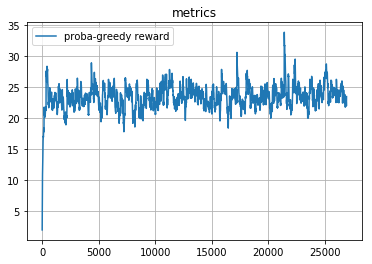

Random session examples


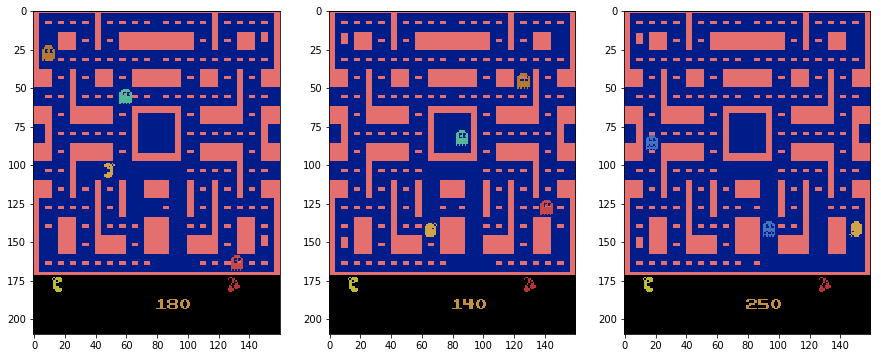

epoch 26910, loss 79.95067, reward 23.85657 
rec 79.039 reg 0.911
epoch 26920, loss 68.21636, reward 24.72091 
rec 67.301 reg 0.915
epoch 26930, loss 59.68600, reward 25.18632 
rec 58.769 reg 0.917
epoch 26940, loss 66.87151, reward 25.41769 
rec 65.955 reg 0.916
epoch 26950, loss 54.11022, reward 25.75092 
rec 53.196 reg 0.915
epoch 26960, loss 59.11615, reward 25.61333 
rec 58.200 reg 0.916
epoch 26970, loss 72.45587, reward 25.86450 
rec 71.538 reg 0.918
epoch 26980, loss 74.57303, reward 25.90305 
rec 73.655 reg 0.918
epoch 26990, loss 66.68968, reward 27.18774 
rec 65.771 reg 0.918
epoch 27000, loss 61.78640, reward 27.59397 
rec 60.869 reg 0.918
Learning curves:


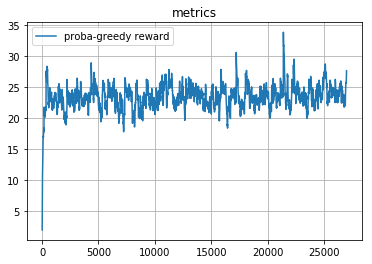

Random session examples


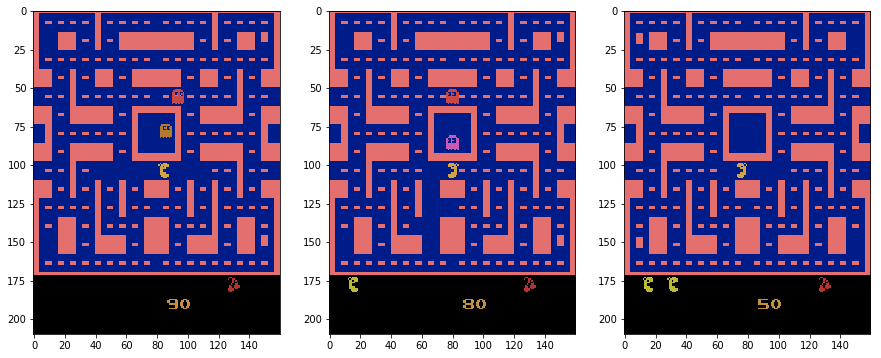

[2017-05-24 11:25:02,524] Making new env: MsPacman-v0
[2017-05-24 11:25:02,707] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-05-24 11:25:02,716] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.26.6612.video000000.mp4
[2017-05-24 11:25:04,022] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.26.6612.video000001.mp4


Episode finished after 612 timesteps, rw = 180.0
Episode finished after 704 timesteps, rw = 250.0
Episode finished after 596 timesteps, rw = 140.0
Episode finished after 685 timesteps, rw = 230.0
Episode finished after 867 timesteps, rw = 410.0
Episode finished after 842 timesteps, rw = 240.0
Episode finished after 641 timesteps, rw = 250.0


[2017-05-24 11:25:12,203] Starting new video recorder writing to /home/vishimtsev/folder/proba_videos/openaigym.video.26.6612.video000008.mp4


Episode finished after 685 timesteps, rw = 200.0
Episode finished after 686 timesteps, rw = 200.0
Episode finished after 576 timesteps, rw = 220.0
Episode finished after 646 timesteps, rw = 190.0
Episode finished after 723 timesteps, rw = 240.0
Episode finished after 513 timesteps, rw = 170.0
Episode finished after 594 timesteps, rw = 250.0
Episode finished after 858 timesteps, rw = 320.0
Episode finished after 650 timesteps, rw = 250.0
Episode finished after 439 timesteps, rw = 140.0
Episode finished after 630 timesteps, rw = 180.0
Episode finished after 661 timesteps, rw = 260.0


[2017-05-24 11:25:24,474] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/vishimtsev/folder/proba_videos')


Episode finished after 647 timesteps, rw = 260.0
Mean 229.0, Var 3619.0
epoch 27010, loss 57.93281, reward 28.27207 
rec 57.017 reg 0.916
epoch 27020, loss 47.52570, reward 26.88236 
rec 46.611 reg 0.914
epoch 27030, loss 52.93868, reward 26.63163 
rec 52.027 reg 0.912
epoch 27040, loss 56.98799, reward 26.53096 
rec 56.078 reg 0.910
epoch 27050, loss 49.50135, reward 26.75287 
rec 48.592 reg 0.909
epoch 27060, loss 55.17107, reward 25.70258 
rec 54.262 reg 0.909
epoch 27070, loss 57.74137, reward 24.31982 
rec 56.832 reg 0.910
epoch 27080, loss 63.63916, reward 24.07534 
rec 62.730 reg 0.910
epoch 27090, loss 52.73169, reward 23.16781 
rec 51.823 reg 0.908
epoch 27100, loss 58.64471, reward 23.60103 
rec 57.738 reg 0.906
Learning curves:


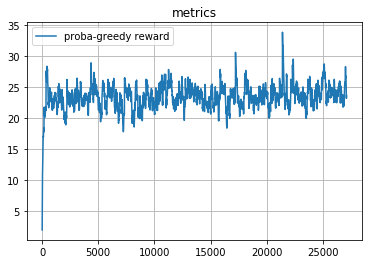

Random session examples


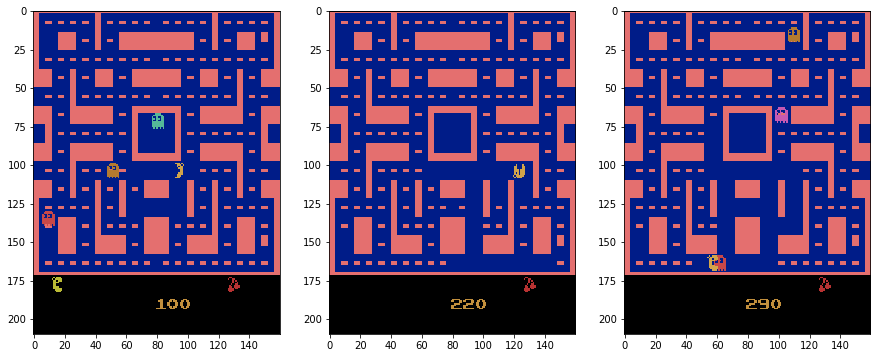

epoch 27110, loss 57.86983, reward 23.42842 
rec 56.964 reg 0.905
epoch 27120, loss 49.96842, reward 22.71058 
rec 49.064 reg 0.904
epoch 27130, loss 267.21814, reward 24.93952 
rec 266.314 reg 0.905
epoch 27140, loss 49.35384, reward 24.75807 
rec 48.448 reg 0.906
epoch 27150, loss 57.74758, reward 25.40726 
rec 56.842 reg 0.906
epoch 27160, loss 56.62038, reward 25.24154 
rec 55.715 reg 0.906
epoch 27170, loss 64.52080, reward 25.27988 
rec 63.615 reg 0.905
epoch 27180, loss 68.41699, reward 25.25190 
rec 67.514 reg 0.903
epoch 27190, loss 50.85086, reward 24.22671 
rec 49.948 reg 0.903
epoch 27200, loss 61.85690, reward 24.17904 
rec 60.955 reg 0.902
Learning curves:


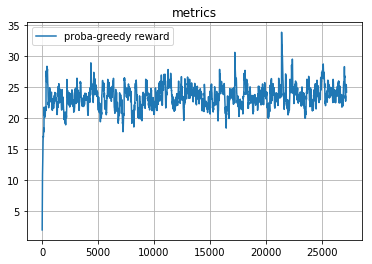

Random session examples


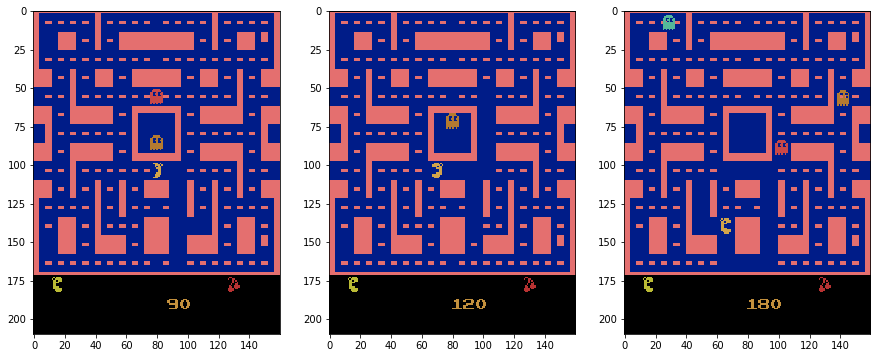

epoch 27210, loss 51.62687, reward 24.57363 
rec 50.721 reg 0.906
epoch 27220, loss 50.74413, reward 23.92877 
rec 49.839 reg 0.905
epoch 27230, loss 54.96200, reward 24.03589 
rec 54.058 reg 0.904
epoch 27240, loss 45.24789, reward 23.44480 
rec 44.347 reg 0.901
epoch 27250, loss 58.75596, reward 23.91282 
rec 57.857 reg 0.899
epoch 27260, loss 64.37262, reward 25.27154 
rec 63.475 reg 0.897
epoch 27270, loss 54.60029, reward 25.30689 
rec 53.704 reg 0.897
epoch 27280, loss 50.46674, reward 24.90120 
rec 49.571 reg 0.896
epoch 27290, loss 41.19679, reward 23.47358 
rec 40.301 reg 0.896
epoch 27300, loss 50.28336, reward 23.12622 
rec 49.389 reg 0.895
Learning curves:


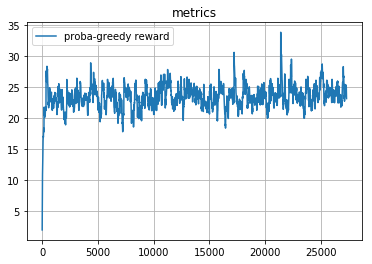

Random session examples


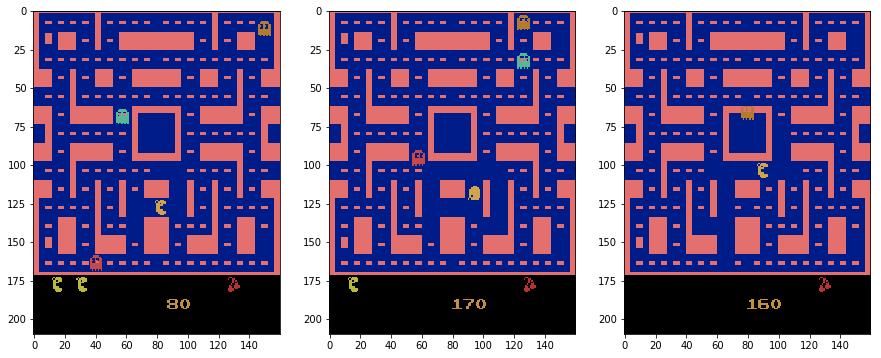

epoch 27310, loss 63.49850, reward 23.12610 
rec 62.604 reg 0.894
epoch 27320, loss 39.50640, reward 22.12599 
rec 38.613 reg 0.894
epoch 27330, loss 59.78702, reward 22.28839 
rec 58.893 reg 0.894
epoch 27340, loss 55.84446, reward 21.99705 
rec 54.948 reg 0.896
epoch 27350, loss 62.76624, reward 22.67235 
rec 61.869 reg 0.897
epoch 27360, loss 51.17033, reward 21.96761 
rec 50.273 reg 0.897
epoch 27370, loss 70.25809, reward 22.14585 
rec 69.361 reg 0.897
epoch 27380, loss 64.53855, reward 23.18126 
rec 63.642 reg 0.897
epoch 27390, loss 59.83747, reward 22.55064 
rec 58.940 reg 0.898
epoch 27400, loss 75.18034, reward 24.29557 
rec 74.273 reg 0.908
Learning curves:


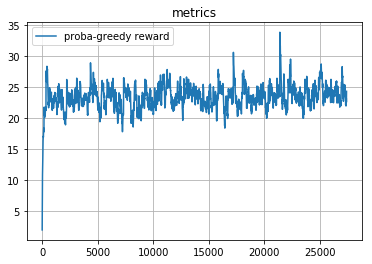

Random session examples


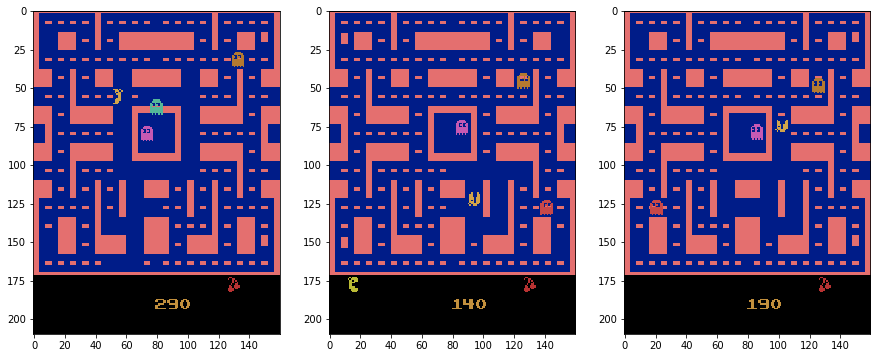

epoch 27410, loss 88.51923, reward 25.42852 
rec 87.607 reg 0.912
epoch 27420, loss 54.77418, reward 24.88567 
rec 53.863 reg 0.912
epoch 27430, loss 57.15844, reward 25.33460 
rec 56.247 reg 0.911
epoch 27440, loss 102.64184, reward 25.30114 
rec 101.729 reg 0.913
epoch 27450, loss 58.60801, reward 25.02103 
rec 57.694 reg 0.914
epoch 27460, loss 62.20730, reward 25.01892 
rec 61.294 reg 0.913
epoch 27470, loss 59.57033, reward 24.51703 
rec 58.658 reg 0.912
epoch 27480, loss 57.32675, reward 24.62783 
rec 56.414 reg 0.913
epoch 27490, loss 54.91272, reward 24.79004 
rec 53.999 reg 0.914
epoch 27500, loss 65.25052, reward 24.31104 
rec 64.337 reg 0.913
Learning curves:


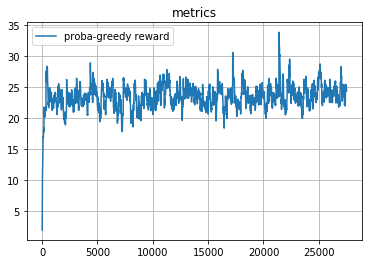

Random session examples


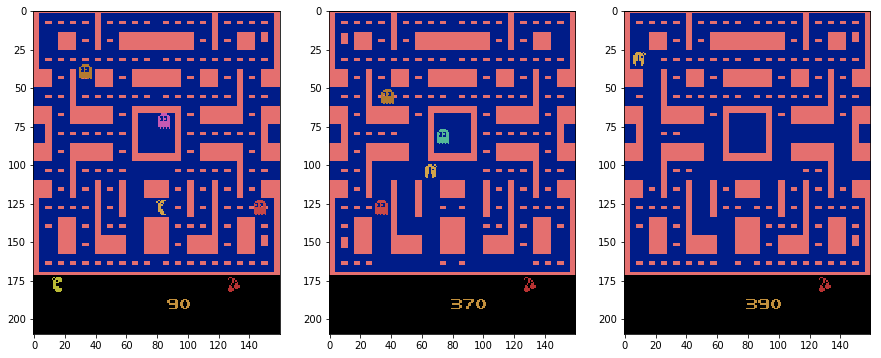

epoch 27510, loss 55.76231, reward 24.44244 
rec 54.849 reg 0.913
epoch 27520, loss 52.69676, reward 23.49819 
rec 51.785 reg 0.912
epoch 27530, loss 38.89844, reward 22.02337 
rec 37.987 reg 0.911
epoch 27540, loss 56.16430, reward 21.13354 
rec 55.253 reg 0.911
epoch 27550, loss 37.88366, reward 20.64518 
rec 36.973 reg 0.911
epoch 27560, loss 38.32508, reward 20.26816 
rec 37.416 reg 0.909
epoch 27570, loss 47.04374, reward 19.55385 
rec 46.138 reg 0.906
epoch 27580, loss 48.15098, reward 19.16096 
rec 47.247 reg 0.904
epoch 27590, loss 50.86596, reward 19.24487 
rec 49.964 reg 0.902
epoch 27600, loss 227.85017, reward 21.44538 
rec 226.949 reg 0.901
Learning curves:


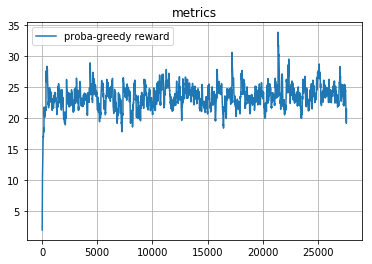

Random session examples


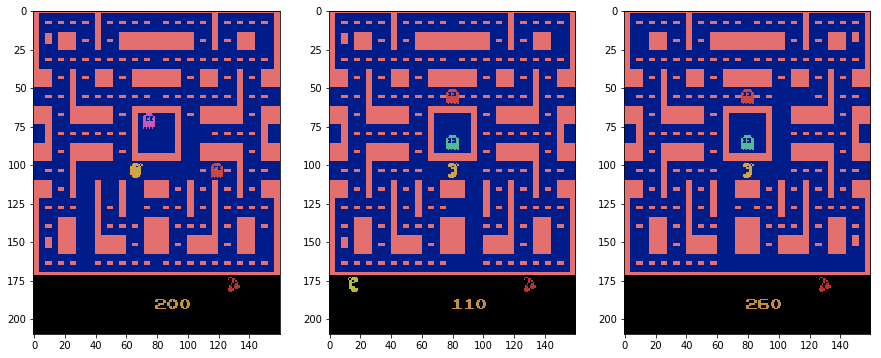

epoch 27610, loss 60.76668, reward 21.92584 
rec 59.867 reg 0.900
epoch 27620, loss 55.93555, reward 22.48326 
rec 55.029 reg 0.906
epoch 27630, loss 59.27287, reward 22.79743 
rec 58.361 reg 0.912
epoch 27640, loss 80.05013, reward 23.58019 
rec 79.137 reg 0.913
epoch 27650, loss 65.94513, reward 24.22217 
rec 65.033 reg 0.912
epoch 27660, loss 63.61999, reward 24.29995 
rec 62.710 reg 0.910
epoch 27670, loss 56.67064, reward 25.30746 
rec 55.761 reg 0.909
epoch 27680, loss 57.06352, reward 24.58921 
rec 56.154 reg 0.909
epoch 27690, loss 73.12893, reward 24.75529 
rec 72.220 reg 0.909
epoch 27700, loss 57.52262, reward 24.96726 
rec 56.612 reg 0.911
Learning curves:


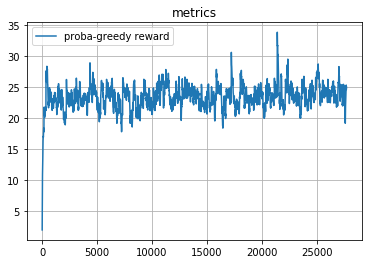

Random session examples


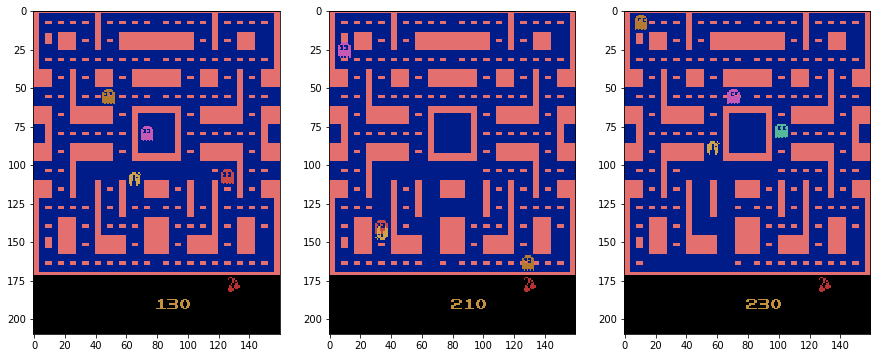

epoch 27710, loss 47.11368, reward 23.90804 
rec 46.203 reg 0.910
epoch 27720, loss 52.04748, reward 22.89223 
rec 51.139 reg 0.909
epoch 27730, loss 68.49244, reward 23.54051 
rec 67.583 reg 0.910
epoch 27740, loss 72.35536, reward 24.31146 
rec 71.437 reg 0.918
epoch 27750, loss 66.04190, reward 23.94281 
rec 65.122 reg 0.920
epoch 27760, loss 55.29868, reward 23.67353 
rec 54.380 reg 0.919
epoch 27770, loss 61.06839, reward 23.86868 
rec 60.147 reg 0.922
epoch 27780, loss 54.28611, reward 23.41931 
rec 53.364 reg 0.923
epoch 27790, loss 56.18410, reward 22.82738 
rec 55.264 reg 0.920
epoch 27800, loss 72.17884, reward 23.48214 
rec 71.261 reg 0.918
Learning curves:


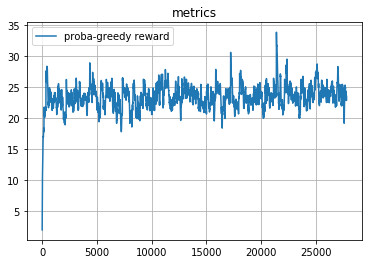

Random session examples


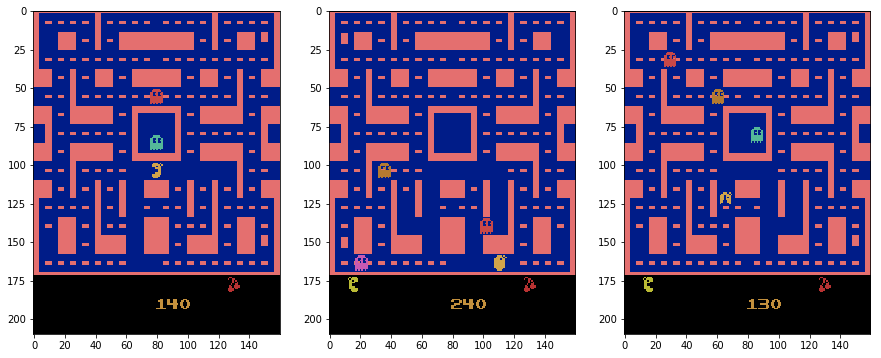

epoch 27810, loss 62.49072, reward 23.82143 
rec 61.575 reg 0.916
epoch 27820, loss 52.29486, reward 23.81428 
rec 51.381 reg 0.913
epoch 27830, loss 47.91261, reward 23.43286 
rec 47.001 reg 0.911
epoch 27840, loss 51.34657, reward 23.15207 
rec 50.438 reg 0.909
epoch 27850, loss 53.30854, reward 23.33686 
rec 52.401 reg 0.907
epoch 27860, loss 55.06971, reward 24.87818 
rec 54.164 reg 0.905
epoch 27870, loss 252.26174, reward 25.82786 
rec 251.359 reg 0.903
epoch 27880, loss 51.12923, reward 25.37007 
rec 50.228 reg 0.901


In [ ]:
%%time

n_epochs = 30000

for i in range(n_epochs):    
    #train
    update_pool(env,pool,replay_seq_len)
    resolver.rng.seed(i)    
    loss,avg_reward = train_fun()
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
#     if epoch_counter%1 ==0:
#         current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/1000.)
#         resolver.epsilon.set_value(np.float32(current_epsilon))
    
    ##record current learning progress and show learning curves
    if epoch_counter%10 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["proba-greedy reward"][epoch_counter] = ma_reward_current
        
        
#         #greedy train
#         resolver.epsilon.set_value(0)
#         update_pool(env,pool,replay_seq_len)

#         avg_reward_greedy = evaluation_fun()[-1]
#         ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
#         score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
#         resolver.epsilon.set_value(np.float32(current_epsilon))
#         update_pool(env,pool,replay_seq_len)

        print("epoch %i, loss %.5f, reward %.5f " % (epoch_counter,full_loss,ma_reward_current))
        print("rec %.3f reg %.3f" % (q_loss,l2_penalty))

    if epoch_counter %100 ==0:
        print("Learning curves:")
        score_log.plot()


        print("Random session examples")
        display_sessions()
    
    #run several sessions of game, record videos and save obtained results
    if epoch_counter %1000 ==0:
        
        save_path = 'proba_videos/MSPacman-v0_' + str(epoch_counter)

        subm_env = gym.make(GAME_TITLE)
        subm_env = gym.wrappers.Monitor(subm_env, 'proba_videos/', force=True)

        rws = []

        for i_episode in xrange(20):

            #initial observation
            observation = subm_env.reset()
            #initial memory
            prev_memories = "zeros"

            s_reward =0.
            t = 0
            while True:

                action,new_memories = step([observation],prev_memories,batch_size=1)
                observation, reward, done, info = subm_env.step(action[0])

                s_reward += reward

                prev_memories = new_memories
                if done:
                    print("Episode finished after {} timesteps, rw = {}".format(t+1,s_reward))
                    rws.append(s_reward)
                    break
                t+=1

        subm_env.close()

        rws = np.array(rws)
        print("Mean {}, Var {}".format(np.mean(rws), np.var(rws)))
        np.savez(open('rws4hist_proba_'+str(epoch_counter)+'.npz', 'wb'), rws=rws)
        
    epoch_counter  +=1
    
# Time to drink some coffee!

## Record videos

In [ ]:
save_path = 'proba1_videos/MSPacman-v0_' + str(epoch_counter-1)

subm_env = gym.make(GAME_TITLE)
subm_env = gym.wrappers.Monitor(subm_env, 'proba1_videos/')

rws = []

for i_episode in xrange(220):

    #initial observation
    observation = subm_env.reset()
    #initial memory
    prev_memories = "zeros"

    s_reward =0.
    t = 0
    while True:

        action,new_memories = step([observation],prev_memories,batch_size=1)
        observation, reward, done, info = subm_env.step(action[0])

        s_reward += reward

        prev_memories = new_memories
        if done:
            print("Episode finished after {} timesteps, rw = {}".format(t+1,s_reward))
            rws.append(s_reward)
            break
        t+=1

subm_env.close()

rws = np.array(rws)
np.savez(open('rws5hist_proba_'+str(epoch_counter-1)+'.npz', 'wb'), rws=rws)

In [ ]:
np.save(open('proba_greedy_log.pcl', 'wb'), score_log['proba-greedy reward'])

(array([  9.,   3.,   3.,   0.,   1.,  88.,   0.,   9.,   2.,   0.,   0.,
         46.,  24.,   5.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  18.,   2.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   5.]),
 array([   70. ,   101.6,   133.2,   164.8,   196.4,   228. ,   259.6,
          291.2,   322.8,   354.4,   386. ,   417.6,   449.2,   480.8,
          512.4,   544. ,   575.6,   607.2,   638.8,   670.4,   702. ,
          733.6,   765.2,   796.8,   828.4,   860. ,   891.6,   923.2,
          954.8,   986.4,  1018. ,  1049.6,  1081.2,  1112.8,  1144.4,
         1176. ,  1207.6,  1239.2,  1270.8,  1302.4,  1334. ,  1365.6,
         1397.2,  1428.8,  1460.4,  1492. ,  1523.6,  1555.2,  1586.8,
         1618.4,  1650. ]),
 <a list of 50 Patch objects>)

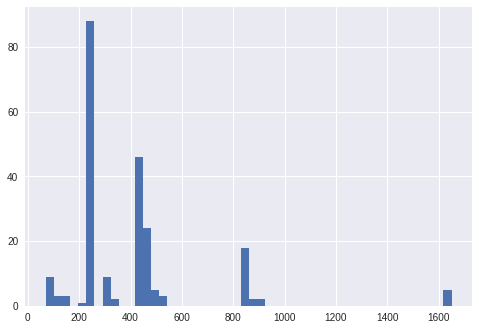

In [77]:
plt.hist(rws, bins=50)

In [79]:
gym.upload?